# EEGNet

This notebook provides a modified reimplementation of the popular CNN-based EEG classifier: EEGNet by [Lawhern et al](http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta).
Most modifications include parameter changes to make it better suited for short-length windows as the original paper used input over 2 seconds long.
The knowledge and utilities obtained from experimental notebooks six and seven are used throughout this notebook.

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
Baseline correction was done on the first second of the epoch, meaning the second before the visual queue was shown.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Same subject, same session
   - Results
   - Longer window length 
- Same subject, new session
   - Results
   - Longer window length 
- New subject
   - Results
   - Longer window length

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGModels
from EEGModels import EEGNet

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Same subject, same session

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model provided through the `EEGModels.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 2500 epochs, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/4/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook4_eegnet_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 2500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_model

#### Results

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

The training plots are given below.
B is dark blue, C is light blue and E is light green.
Convergence is already reached after 500 epochs.

![Accuracy plot](figures/4/samesubject_samesession/accuracy.png)
![Loss plot](figures/4/samesubject_samesession/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/4/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/4/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

### Longer window length

An experiment was performed where the window size was changed to 1.5 seconds.
This is done by including 0.25 seconds before and after the queue is shown, totalling 0.25 + 1 + 0.25 = 1.5 seconds.
The following parameters were changed:
- Samples = 300 (from 100)
- kernLength = 150 (from 50)
- F1 = 16 (from 8)
- F2 = 32 (from 16)
- D = 4 (from 2)

The performed experiment is equal besides this.
The following results were obtained:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8802 @ epoch 383                   | 0.3736 @ epoch 632               | 0.7708                                           | 0.7812                                            |
| C           | 0.9479 @ epoch 2290                  | 0.2454 @ epoch 1094              | 0.9531                                           | 0.9375                                            |
| E           | 0.9529 @ epoch 896                   | 0.1631 @ epoch 1224              | 0.9319                                           | 0.9215                                            |

Whilst the accuracy improved for the test set significantly for subject C and E, the added complexity and overfitting tendencies is something that should be taken into account when working with longer windows.

The training plots are given below.
B is dark blue, C is light blue and E is green.
Convergence takes more time but is still achieved under 1000 epochs and it becomes apparent that there are now signs of overfitting with divergence occurring.

![Accuracy plot](figures/4/samesubject_samesession_longer_window/accuracy.png)
![Loss plot](figures/4/samesubject_samesession_longer_window/loss.png)

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 300, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 16, # number of temporal filters. (default: 8)
        F2 = 32, # number of pointwise filters. (default: 16)
        D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a 1.5 second window
                mne_epochs_data = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook4_eegnet_singlesession_longer_window_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 2500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_model

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/4/samesubject_samesession_longer_window/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, new session

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model provided through the `EEGModels.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 2500 epochs, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set



In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/4/samesubject_differentsession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook4_eegnet_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 2500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_model

#### Results

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.3375                                           | 0.3375                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.3379                                           | 0.3379                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.3351                                           | 0.3351                                            |

It becomes clear from the CM that the model always predicts a neutral task for the unseen session.
The model does not generalize well.

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/4/samesubject_newsession/accuracy.png)
![Loss plot](figures/4/samesubject_newsession/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/4/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

### Longer window length

An experiment was performed where the window size was changed to 1.5 seconds.
This is done by including 0.25 seconds before and after the queue is shown, totalling 0.25 + 1 + 0.25 = 1.5 seconds.
The following parameters were changed:
- Samples = 300 (from 100)
- kernLength = 150 (from 50)
- F1 = 16 (from 8)
- F2 = 32 (from 16)
- D = 4 (from 2)

The performed experiment is equal besides this.
The following results were obtained:


| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.7378 @ epoch 2483                  | 0.6887 @ epoch 204               | 0.3375                                           | 0.3375                                            |
| C           | 0.9149 @ epoch 885                   | 0.3764 @ epoch 208               | 0.3379                                           | 0.3379                                            |
| E           | 0.8333 @ epoch 233                   | 0.4867 @ epoch 302               | 0.3351                                           | 0.3351                                            |


The training plots are given below.
B is dark blue, C is light blue and E is green.
Again, there is a clear sign of divergence!

![Accuracy plot](figures/4/samesubject_newsession_longer_window/accuracy.png)
![Loss plot](figures/4/samesubject_newsession_longer_window/loss.png)

In [6]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = True # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 300, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 16, # number of temporal filters. (default: 8)
        F2 = 32, # number of pointwise filters. (default: 16)
        D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a 1.5 seconds window
                mne_epochs_data = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/4/samesubject_differentsession_longer_window/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/4/samesubject_differentsession_longer_window/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook4_eegnet_newsession_longer_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 2500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/4/samesubject_differentsession_longer_window/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_model


####################################################
# TRAINING FOR SUBJECT B
####################################################

Shape of all data (epochs, channels, samples): (1918, 21, 300)
Epoch 1/2500
10/11 [==========================>...] - ETA: 0s - loss: 1.1529 - accuracy: 0.3336
Epoch 1: val_loss improved from inf to 1.09774, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.37847, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectB\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 2s 95ms/step - loss: 1.1517 - accuracy: 0.3294 - val_loss: 1.0977 - val_accuracy: 0.3785
Epoch 2/2500
10/11 [==========================>...] - ETA: 0s - loss: 1.0937 - accuracy: 0.3828
Epoch 2: val_loss improved from 1.09774 to 1.09692, saving model to saved_variables/4/samesubject_differentsession_longer_window/subje

11/11 [==============================] - 1s 77ms/step - loss: 0.9388 - accuracy: 0.5641 - val_loss: 1.0379 - val_accuracy: 0.5382
Epoch 17/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.9392 - accuracy: 0.5602
Epoch 17: val_loss improved from 1.03794 to 1.02956, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 17: val_accuracy improved from 0.53819 to 0.56076, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectB\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 76ms/step - loss: 0.9369 - accuracy: 0.5618 - val_loss: 1.0296 - val_accuracy: 0.5608
Epoch 18/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.9106 - accuracy: 0.6055
Epoch 18: val_loss improved from 1.02956 to 1.02385, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 18: va

10/11 [==========================>...] - ETA: 0s - loss: 0.8289 - accuracy: 0.6539
Epoch 32: val_loss improved from 0.88143 to 0.87431, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 32: val_accuracy improved from 0.64931 to 0.65104, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectB\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 77ms/step - loss: 0.8241 - accuracy: 0.6580 - val_loss: 0.8743 - val_accuracy: 0.6510
Epoch 33/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.8098 - accuracy: 0.6633
Epoch 33: val_loss improved from 0.87431 to 0.86766, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 33: val_accuracy did not improve from 0.65104
11/11 [==============================] - 1s 70ms/step - loss: 0.8044 - accuracy: 0.6662 - val_loss: 0.86

11/11 [==============================] - 1s 119ms/step - loss: 0.7610 - accuracy: 0.6915 - val_loss: 0.7846 - val_accuracy: 0.6562
Epoch 50/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.7527 - accuracy: 0.6812
Epoch 50: val_loss did not improve from 0.78460

Epoch 50: val_accuracy did not improve from 0.65625
11/11 [==============================] - 1s 77ms/step - loss: 0.7547 - accuracy: 0.6788 - val_loss: 0.7888 - val_accuracy: 0.6493
Epoch 51/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.7545 - accuracy: 0.6867
Epoch 51: val_loss improved from 0.78460 to 0.78089, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 51: val_accuracy improved from 0.65625 to 0.65799, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectB\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 76ms/step - loss: 0.7544 - accuracy: 0.6848

11/11 [==============================] - 1s 89ms/step - loss: 0.7200 - accuracy: 0.7154 - val_loss: 0.7474 - val_accuracy: 0.6719
Epoch 70/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.7318 - accuracy: 0.7055
Epoch 70: val_loss did not improve from 0.74382

Epoch 70: val_accuracy did not improve from 0.67882
11/11 [==============================] - 1s 100ms/step - loss: 0.7299 - accuracy: 0.7064 - val_loss: 0.7495 - val_accuracy: 0.6736
Epoch 71/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.7273 - accuracy: 0.6992
Epoch 71: val_loss improved from 0.74382 to 0.74333, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 71: val_accuracy did not improve from 0.67882
11/11 [==============================] - 1s 95ms/step - loss: 0.7261 - accuracy: 0.7027 - val_loss: 0.7433 - val_accuracy: 0.6701
Epoch 72/2500
11/11 [==============================] - ETA: 0s - loss: 0.7156 - accur


Epoch 91: val_accuracy did not improve from 0.69271
11/11 [==============================] - 1s 93ms/step - loss: 0.6735 - accuracy: 0.7280 - val_loss: 0.7311 - val_accuracy: 0.6823
Epoch 92/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.6699 - accuracy: 0.7273
Epoch 92: val_loss did not improve from 0.72620

Epoch 92: val_accuracy did not improve from 0.69271
11/11 [==============================] - 1s 90ms/step - loss: 0.6660 - accuracy: 0.7317 - val_loss: 0.7268 - val_accuracy: 0.6771
Epoch 93/2500
11/11 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.7295
Epoch 93: val_loss improved from 0.72620 to 0.72421, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 93: val_accuracy did not improve from 0.69271
11/11 [==============================] - 1s 101ms/step - loss: 0.6788 - accuracy: 0.7295 - val_loss: 0.7242 - val_accuracy: 0.6771
Epoch 94/2500
10/11 [===========

Epoch 114/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.6624 - accuracy: 0.7234
Epoch 114: val_loss did not improve from 0.71203

Epoch 114: val_accuracy did not improve from 0.69965
11/11 [==============================] - 1s 86ms/step - loss: 0.6592 - accuracy: 0.7273 - val_loss: 0.7160 - val_accuracy: 0.6927
Epoch 115/2500
11/11 [==============================] - ETA: 0s - loss: 0.6618 - accuracy: 0.7452
Epoch 115: val_loss improved from 0.71203 to 0.71105, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 115: val_accuracy did not improve from 0.69965
11/11 [==============================] - 1s 75ms/step - loss: 0.6618 - accuracy: 0.7452 - val_loss: 0.7111 - val_accuracy: 0.6892
Epoch 116/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.6519 - accuracy: 0.7484
Epoch 116: val_loss did not improve from 0.71105

Epoch 116: val_accuracy did not improve from 0.69965
11/11 [==

Epoch 136/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.6186 - accuracy: 0.7578
Epoch 136: val_loss did not improve from 0.69912

Epoch 136: val_accuracy did not improve from 0.70833
11/11 [==============================] - 1s 69ms/step - loss: 0.6201 - accuracy: 0.7571 - val_loss: 0.7045 - val_accuracy: 0.7014
Epoch 137/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.6400 - accuracy: 0.7383
Epoch 137: val_loss did not improve from 0.69912

Epoch 137: val_accuracy did not improve from 0.70833
11/11 [==============================] - 1s 69ms/step - loss: 0.6369 - accuracy: 0.7414 - val_loss: 0.7131 - val_accuracy: 0.6979
Epoch 138/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.6467 - accuracy: 0.7359
Epoch 138: val_loss did not improve from 0.69912

Epoch 138: val_accuracy did not improve from 0.70833
11/11 [==============================] - 1s 72ms/step - loss: 0.6462 - accuracy: 0.7362 - val_loss: 0.7044 - val_accuracy: 0.6962
Epoch 1

11/11 [==============================] - 1s 69ms/step - loss: 0.6017 - accuracy: 0.7489 - val_loss: 0.7044 - val_accuracy: 0.6962
Epoch 160/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.6185 - accuracy: 0.7680
Epoch 160: val_loss did not improve from 0.69679

Epoch 160: val_accuracy did not improve from 0.71354
11/11 [==============================] - 1s 70ms/step - loss: 0.6161 - accuracy: 0.7697 - val_loss: 0.7095 - val_accuracy: 0.6979
Epoch 161/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.6351 - accuracy: 0.7391
Epoch 161: val_loss did not improve from 0.69679

Epoch 161: val_accuracy did not improve from 0.71354
11/11 [==============================] - 1s 75ms/step - loss: 0.6342 - accuracy: 0.7414 - val_loss: 0.7004 - val_accuracy: 0.7066
Epoch 162/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.6204 - accuracy: 0.7492
Epoch 162: val_loss did not improve from 0.69679

Epoch 162: val_accuracy did not improve from 0.71354
11/11 [

Epoch 183/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5988 - accuracy: 0.7680
Epoch 183: val_loss did not improve from 0.69375

Epoch 183: val_accuracy did not improve from 0.71875
11/11 [==============================] - 1s 68ms/step - loss: 0.6068 - accuracy: 0.7615 - val_loss: 0.7050 - val_accuracy: 0.7083
Epoch 184/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5813 - accuracy: 0.7688
Epoch 184: val_loss did not improve from 0.69375

Epoch 184: val_accuracy did not improve from 0.71875
11/11 [==============================] - 1s 77ms/step - loss: 0.5912 - accuracy: 0.7653 - val_loss: 0.7074 - val_accuracy: 0.7083
Epoch 185/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5970 - accuracy: 0.7609
Epoch 185: val_loss did not improve from 0.69375

Epoch 185: val_accuracy did not improve from 0.71875
11/11 [==============================] - 1s 66ms/step - loss: 0.5996 - accuracy: 0.7586 - val_loss: 0.6993 - val_accuracy: 0.7031
Epoch 1

10/11 [==========================>...] - ETA: 0s - loss: 0.5829 - accuracy: 0.7773
Epoch 206: val_loss did not improve from 0.68871

Epoch 206: val_accuracy did not improve from 0.71875
11/11 [==============================] - 1s 76ms/step - loss: 0.5809 - accuracy: 0.7742 - val_loss: 0.6944 - val_accuracy: 0.7170
Epoch 207/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5904 - accuracy: 0.7672
Epoch 207: val_loss did not improve from 0.68871

Epoch 207: val_accuracy did not improve from 0.71875
11/11 [==============================] - 1s 74ms/step - loss: 0.5910 - accuracy: 0.7705 - val_loss: 0.6976 - val_accuracy: 0.7066
Epoch 208/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5864 - accuracy: 0.7570
Epoch 208: val_loss did not improve from 0.68871

Epoch 208: val_accuracy did not improve from 0.71875
11/11 [==============================] - 1s 69ms/step - loss: 0.5822 - accuracy: 0.7608 - val_loss: 0.7043 - val_accuracy: 0.6944
Epoch 209/2500
10/11 [


Epoch 230: val_accuracy did not improve from 0.72049
11/11 [==============================] - 1s 78ms/step - loss: 0.5797 - accuracy: 0.7705 - val_loss: 0.6907 - val_accuracy: 0.7135
Epoch 231/2500
11/11 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.7802
Epoch 231: val_loss did not improve from 0.68871

Epoch 231: val_accuracy did not improve from 0.72049
11/11 [==============================] - 1s 81ms/step - loss: 0.5825 - accuracy: 0.7802 - val_loss: 0.6889 - val_accuracy: 0.7153
Epoch 232/2500
11/11 [==============================] - ETA: 0s - loss: 0.5634 - accuracy: 0.7951
Epoch 232: val_loss did not improve from 0.68871

Epoch 232: val_accuracy did not improve from 0.72049
11/11 [==============================] - 1s 83ms/step - loss: 0.5634 - accuracy: 0.7951 - val_loss: 0.7032 - val_accuracy: 0.7066
Epoch 233/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5903 - accuracy: 0.7578
Epoch 233: val_loss did not improve from 0.68871

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.5717 - accuracy: 0.7758
Epoch 255: val_loss did not improve from 0.68871

Epoch 255: val_accuracy did not improve from 0.72049
11/11 [==============================] - 1s 78ms/step - loss: 0.5667 - accuracy: 0.7772 - val_loss: 0.6935 - val_accuracy: 0.7066
Epoch 256/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5574 - accuracy: 0.7828
Epoch 256: val_loss did not improve from 0.68871

Epoch 256: val_accuracy did not improve from 0.72049
11/11 [==============================] - 1s 74ms/step - loss: 0.5523 - accuracy: 0.7869 - val_loss: 0.6919 - val_accuracy: 0.7049
Epoch 257/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5747 - accuracy: 0.7719
Epoch 257: val_loss did not improve from 0.68871

Epoch 257: val_accuracy did not improve from 0.72049
11/11 [==============================] - 1s 78ms/step - loss: 0.5779 - accuracy: 0.7712 - val_loss: 0.6981 - val_accuracy: 0.7066
Epoch 258/2500
10/11 [

Epoch 280/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5422 - accuracy: 0.7859
Epoch 280: val_loss did not improve from 0.68871

Epoch 280: val_accuracy did not improve from 0.72049
11/11 [==============================] - 1s 86ms/step - loss: 0.5429 - accuracy: 0.7839 - val_loss: 0.7024 - val_accuracy: 0.7083
Epoch 281/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5415 - accuracy: 0.7937
Epoch 281: val_loss did not improve from 0.68871

Epoch 281: val_accuracy did not improve from 0.72049
11/11 [==============================] - 1s 77ms/step - loss: 0.5446 - accuracy: 0.7928 - val_loss: 0.7144 - val_accuracy: 0.6997
Epoch 282/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5576 - accuracy: 0.7734
Epoch 282: val_loss did not improve from 0.68871

Epoch 282: val_accuracy did not improve from 0.72049
11/11 [==============================] - 1s 76ms/step - loss: 0.5641 - accuracy: 0.7668 - val_loss: 0.7021 - val_accuracy: 0.6997
Epoch 2


Epoch 304: val_accuracy did not improve from 0.72569
11/11 [==============================] - 1s 84ms/step - loss: 0.5484 - accuracy: 0.7765 - val_loss: 0.7099 - val_accuracy: 0.7083
Epoch 305/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5449 - accuracy: 0.7836
Epoch 305: val_loss did not improve from 0.68871

Epoch 305: val_accuracy did not improve from 0.72569
11/11 [==============================] - 1s 81ms/step - loss: 0.5427 - accuracy: 0.7854 - val_loss: 0.7169 - val_accuracy: 0.7031
Epoch 306/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5423 - accuracy: 0.7805
Epoch 306: val_loss did not improve from 0.68871

Epoch 306: val_accuracy did not improve from 0.72569
11/11 [==============================] - 1s 81ms/step - loss: 0.5446 - accuracy: 0.7802 - val_loss: 0.7092 - val_accuracy: 0.7049
Epoch 307/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5305 - accuracy: 0.7937
Epoch 307: val_loss did not improve from 0.68871

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.5227 - accuracy: 0.7969
Epoch 329: val_loss did not improve from 0.68871

Epoch 329: val_accuracy did not improve from 0.72569
11/11 [==============================] - 1s 78ms/step - loss: 0.5242 - accuracy: 0.7958 - val_loss: 0.7080 - val_accuracy: 0.7118
Epoch 330/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5142 - accuracy: 0.7969
Epoch 330: val_loss did not improve from 0.68871

Epoch 330: val_accuracy did not improve from 0.72569
11/11 [==============================] - 1s 79ms/step - loss: 0.5168 - accuracy: 0.7951 - val_loss: 0.7154 - val_accuracy: 0.7101
Epoch 331/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5193 - accuracy: 0.7977
Epoch 331: val_loss did not improve from 0.68871

Epoch 331: val_accuracy did not improve from 0.72569
11/11 [==============================] - 1s 79ms/step - loss: 0.5185 - accuracy: 0.7973 - val_loss: 0.7175 - val_accuracy: 0.7170
Epoch 332/2500
11/11 [

Epoch 354/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5191 - accuracy: 0.7969
Epoch 354: val_loss did not improve from 0.68871

Epoch 354: val_accuracy did not improve from 0.72569
11/11 [==============================] - 1s 76ms/step - loss: 0.5196 - accuracy: 0.7973 - val_loss: 0.7281 - val_accuracy: 0.7222
Epoch 355/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5240 - accuracy: 0.8055
Epoch 355: val_loss did not improve from 0.68871

Epoch 355: val_accuracy did not improve from 0.72569
11/11 [==============================] - 1s 77ms/step - loss: 0.5244 - accuracy: 0.8048 - val_loss: 0.7166 - val_accuracy: 0.7049
Epoch 356/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5273 - accuracy: 0.7930
Epoch 356: val_loss did not improve from 0.68871

Epoch 356: val_accuracy did not improve from 0.72569
11/11 [==============================] - 1s 82ms/step - loss: 0.5239 - accuracy: 0.7951 - val_loss: 0.7233 - val_accuracy: 0.7170
Epoch 3

Epoch 379/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4972 - accuracy: 0.8141
Epoch 379: val_loss did not improve from 0.68871

Epoch 379: val_accuracy did not improve from 0.72569
11/11 [==============================] - 1s 77ms/step - loss: 0.4948 - accuracy: 0.8145 - val_loss: 0.7091 - val_accuracy: 0.7257
Epoch 380/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5066 - accuracy: 0.7961
Epoch 380: val_loss did not improve from 0.68871

Epoch 380: val_accuracy did not improve from 0.72569
11/11 [==============================] - 1s 78ms/step - loss: 0.5032 - accuracy: 0.7981 - val_loss: 0.7119 - val_accuracy: 0.7222
Epoch 381/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4917 - accuracy: 0.8148
Epoch 381: val_loss did not improve from 0.68871

Epoch 381: val_accuracy did not improve from 0.72569
11/11 [==============================] - 1s 73ms/step - loss: 0.4932 - accuracy: 0.8122 - val_loss: 0.7237 - val_accuracy: 0.7188
Epoch 3

Epoch 404/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4998 - accuracy: 0.8016
Epoch 404: val_loss did not improve from 0.68871

Epoch 404: val_accuracy improved from 0.72569 to 0.73090, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectB\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 77ms/step - loss: 0.4986 - accuracy: 0.8018 - val_loss: 0.6997 - val_accuracy: 0.7309
Epoch 405/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4979 - accuracy: 0.7984
Epoch 405: val_loss did not improve from 0.68871

Epoch 405: val_accuracy did not improve from 0.73090
11/11 [==============================] - 1s 67ms/step - loss: 0.4920 - accuracy: 0.8025 - val_loss: 0.7092 - val_accuracy: 0.7240
Epoch 406/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5345 - accuracy: 0.7867
Epoch 406: val_loss did not improve from 0.68871

Epoch 406: val_accuracy did not improve from 0.73090
11/11 [==


Epoch 428: val_accuracy did not improve from 0.73090
11/11 [==============================] - 1s 90ms/step - loss: 0.5086 - accuracy: 0.8010 - val_loss: 0.7183 - val_accuracy: 0.7188
Epoch 429/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4990 - accuracy: 0.8016
Epoch 429: val_loss did not improve from 0.68871

Epoch 429: val_accuracy did not improve from 0.73090
11/11 [==============================] - 1s 86ms/step - loss: 0.4935 - accuracy: 0.8063 - val_loss: 0.7062 - val_accuracy: 0.7222
Epoch 430/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.5118 - accuracy: 0.8031
Epoch 430: val_loss did not improve from 0.68871

Epoch 430: val_accuracy did not improve from 0.73090
11/11 [==============================] - 1s 79ms/step - loss: 0.5145 - accuracy: 0.8010 - val_loss: 0.7206 - val_accuracy: 0.7153
Epoch 431/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4984 - accuracy: 0.8062
Epoch 431: val_loss did not improve from 0.68871

Epoch 

Epoch 453/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4886 - accuracy: 0.8078
Epoch 453: val_loss did not improve from 0.68871

Epoch 453: val_accuracy did not improve from 0.73264
11/11 [==============================] - 1s 69ms/step - loss: 0.4911 - accuracy: 0.8063 - val_loss: 0.7217 - val_accuracy: 0.7188
Epoch 454/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4901 - accuracy: 0.8141
Epoch 454: val_loss did not improve from 0.68871

Epoch 454: val_accuracy did not improve from 0.73264
11/11 [==============================] - 1s 80ms/step - loss: 0.4876 - accuracy: 0.8130 - val_loss: 0.7127 - val_accuracy: 0.7135
Epoch 455/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4763 - accuracy: 0.8203
Epoch 455: val_loss did not improve from 0.68871

Epoch 455: val_accuracy did not improve from 0.73264
11/11 [==============================] - 1s 80ms/step - loss: 0.4758 - accuracy: 0.8219 - val_loss: 0.7129 - val_accuracy: 0.7153
Epoch 4

Epoch 478/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4904 - accuracy: 0.8047
Epoch 478: val_loss did not improve from 0.68871

Epoch 478: val_accuracy did not improve from 0.73264
11/11 [==============================] - 1s 68ms/step - loss: 0.4923 - accuracy: 0.8033 - val_loss: 0.7283 - val_accuracy: 0.7118
Epoch 479/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4779 - accuracy: 0.8141
Epoch 479: val_loss did not improve from 0.68871

Epoch 479: val_accuracy did not improve from 0.73264
11/11 [==============================] - 1s 76ms/step - loss: 0.4827 - accuracy: 0.8107 - val_loss: 0.7305 - val_accuracy: 0.7101
Epoch 480/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4765 - accuracy: 0.8117
Epoch 480: val_loss did not improve from 0.68871

Epoch 480: val_accuracy did not improve from 0.73264
11/11 [==============================] - 1s 67ms/step - loss: 0.4820 - accuracy: 0.8077 - val_loss: 0.7339 - val_accuracy: 0.7170
Epoch 4

Epoch 503/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4932 - accuracy: 0.8000
Epoch 503: val_loss did not improve from 0.68871

Epoch 503: val_accuracy did not improve from 0.73264
11/11 [==============================] - 1s 72ms/step - loss: 0.4950 - accuracy: 0.7988 - val_loss: 0.7326 - val_accuracy: 0.7135
Epoch 504/2500
11/11 [==============================] - ETA: 0s - loss: 0.4779 - accuracy: 0.8122
Epoch 504: val_loss did not improve from 0.68871

Epoch 504: val_accuracy did not improve from 0.73264
11/11 [==============================] - 1s 84ms/step - loss: 0.4779 - accuracy: 0.8122 - val_loss: 0.7385 - val_accuracy: 0.7188
Epoch 505/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4922 - accuracy: 0.8039
Epoch 505: val_loss did not improve from 0.68871

Epoch 505: val_accuracy did not improve from 0.73264
11/11 [==============================] - 1s 98ms/step - loss: 0.4861 - accuracy: 0.8048 - val_loss: 0.7274 - val_accuracy: 0.7153
Epoch 5


Epoch 527: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 70ms/step - loss: 0.4745 - accuracy: 0.8182 - val_loss: 0.7244 - val_accuracy: 0.7274
Epoch 528/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4589 - accuracy: 0.8227
Epoch 528: val_loss did not improve from 0.68871

Epoch 528: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.4621 - accuracy: 0.8204 - val_loss: 0.7297 - val_accuracy: 0.7170
Epoch 529/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4777 - accuracy: 0.8125
Epoch 529: val_loss did not improve from 0.68871

Epoch 529: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 69ms/step - loss: 0.4747 - accuracy: 0.8137 - val_loss: 0.7423 - val_accuracy: 0.7135
Epoch 530/2500
11/11 [==============================] - ETA: 0s - loss: 0.4953 - accuracy: 0.7854
Epoch 530: val_loss did not improve from 0.68871

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.4623 - accuracy: 0.8227
Epoch 552: val_loss did not improve from 0.68871

Epoch 552: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.4569 - accuracy: 0.8234 - val_loss: 0.7310 - val_accuracy: 0.7049
Epoch 553/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4842 - accuracy: 0.8047
Epoch 553: val_loss did not improve from 0.68871

Epoch 553: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 65ms/step - loss: 0.4800 - accuracy: 0.8077 - val_loss: 0.7294 - val_accuracy: 0.7188
Epoch 554/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4805 - accuracy: 0.8188
Epoch 554: val_loss did not improve from 0.68871

Epoch 554: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.4805 - accuracy: 0.8152 - val_loss: 0.7397 - val_accuracy: 0.7188
Epoch 555/2500
10/11 [

Epoch 577/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4446 - accuracy: 0.8305
Epoch 577: val_loss did not improve from 0.68871

Epoch 577: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.4399 - accuracy: 0.8316 - val_loss: 0.7346 - val_accuracy: 0.7153
Epoch 578/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4835 - accuracy: 0.8000
Epoch 578: val_loss did not improve from 0.68871

Epoch 578: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 70ms/step - loss: 0.4804 - accuracy: 0.8010 - val_loss: 0.7338 - val_accuracy: 0.7292
Epoch 579/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4506 - accuracy: 0.8211
Epoch 579: val_loss did not improve from 0.68871

Epoch 579: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.4539 - accuracy: 0.8189 - val_loss: 0.7541 - val_accuracy: 0.7240
Epoch 5

Epoch 602/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4540 - accuracy: 0.8203
Epoch 602: val_loss did not improve from 0.68871

Epoch 602: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 71ms/step - loss: 0.4500 - accuracy: 0.8219 - val_loss: 0.7542 - val_accuracy: 0.7101
Epoch 603/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4387 - accuracy: 0.8289
Epoch 603: val_loss did not improve from 0.68871

Epoch 603: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 72ms/step - loss: 0.4398 - accuracy: 0.8279 - val_loss: 0.7534 - val_accuracy: 0.7049
Epoch 604/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4659 - accuracy: 0.8242
Epoch 604: val_loss did not improve from 0.68871

Epoch 604: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 72ms/step - loss: 0.4679 - accuracy: 0.8234 - val_loss: 0.7509 - val_accuracy: 0.7101
Epoch 6

Epoch 627/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4374 - accuracy: 0.8508
Epoch 627: val_loss did not improve from 0.68871

Epoch 627: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 69ms/step - loss: 0.4436 - accuracy: 0.8487 - val_loss: 0.7729 - val_accuracy: 0.7049
Epoch 628/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4448 - accuracy: 0.8289
Epoch 628: val_loss did not improve from 0.68871

Epoch 628: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 74ms/step - loss: 0.4466 - accuracy: 0.8279 - val_loss: 0.7480 - val_accuracy: 0.7083
Epoch 629/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4597 - accuracy: 0.8148
Epoch 629: val_loss did not improve from 0.68871

Epoch 629: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 73ms/step - loss: 0.4647 - accuracy: 0.8137 - val_loss: 0.7589 - val_accuracy: 0.6927
Epoch 6

Epoch 652/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4359 - accuracy: 0.8188
Epoch 652: val_loss did not improve from 0.68871

Epoch 652: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 71ms/step - loss: 0.4454 - accuracy: 0.8152 - val_loss: 0.7497 - val_accuracy: 0.7188
Epoch 653/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4597 - accuracy: 0.8062
Epoch 653: val_loss did not improve from 0.68871

Epoch 653: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 73ms/step - loss: 0.4540 - accuracy: 0.8122 - val_loss: 0.7532 - val_accuracy: 0.7101
Epoch 654/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4519 - accuracy: 0.8266
Epoch 654: val_loss did not improve from 0.68871

Epoch 654: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 73ms/step - loss: 0.4480 - accuracy: 0.8256 - val_loss: 0.7669 - val_accuracy: 0.7014
Epoch 6

Epoch 677/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4386 - accuracy: 0.8320
Epoch 677: val_loss did not improve from 0.68871

Epoch 677: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.4398 - accuracy: 0.8308 - val_loss: 0.7447 - val_accuracy: 0.7170
Epoch 678/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4713 - accuracy: 0.8148
Epoch 678: val_loss did not improve from 0.68871

Epoch 678: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 69ms/step - loss: 0.4697 - accuracy: 0.8159 - val_loss: 0.7907 - val_accuracy: 0.6979
Epoch 679/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4402 - accuracy: 0.8305
Epoch 679: val_loss did not improve from 0.68871

Epoch 679: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 72ms/step - loss: 0.4388 - accuracy: 0.8301 - val_loss: 0.7557 - val_accuracy: 0.7049
Epoch 6

Epoch 702/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4275 - accuracy: 0.8328
Epoch 702: val_loss did not improve from 0.68871

Epoch 702: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 69ms/step - loss: 0.4311 - accuracy: 0.8316 - val_loss: 0.7565 - val_accuracy: 0.7083
Epoch 703/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4368 - accuracy: 0.8406
Epoch 703: val_loss did not improve from 0.68871

Epoch 703: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 63ms/step - loss: 0.4289 - accuracy: 0.8450 - val_loss: 0.7519 - val_accuracy: 0.7118
Epoch 704/2500
11/11 [==============================] - ETA: 0s - loss: 0.4318 - accuracy: 0.8279
Epoch 704: val_loss did not improve from 0.68871

Epoch 704: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 68ms/step - loss: 0.4318 - accuracy: 0.8279 - val_loss: 0.7633 - val_accuracy: 0.7135
Epoch 7

Epoch 727/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4333 - accuracy: 0.8289
Epoch 727: val_loss did not improve from 0.68871

Epoch 727: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 72ms/step - loss: 0.4305 - accuracy: 0.8286 - val_loss: 0.7701 - val_accuracy: 0.7153
Epoch 728/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4344 - accuracy: 0.8375
Epoch 728: val_loss did not improve from 0.68871

Epoch 728: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 73ms/step - loss: 0.4330 - accuracy: 0.8383 - val_loss: 0.7710 - val_accuracy: 0.7101
Epoch 729/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4448 - accuracy: 0.8219
Epoch 729: val_loss did not improve from 0.68871

Epoch 729: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 71ms/step - loss: 0.4465 - accuracy: 0.8204 - val_loss: 0.7587 - val_accuracy: 0.7101
Epoch 7

Epoch 752/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4477 - accuracy: 0.8188
Epoch 752: val_loss did not improve from 0.68871

Epoch 752: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 71ms/step - loss: 0.4455 - accuracy: 0.8204 - val_loss: 0.7544 - val_accuracy: 0.7188
Epoch 753/2500
11/11 [==============================] - ETA: 0s - loss: 0.4185 - accuracy: 0.8323
Epoch 753: val_loss did not improve from 0.68871

Epoch 753: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 97ms/step - loss: 0.4185 - accuracy: 0.8323 - val_loss: 0.7525 - val_accuracy: 0.7188
Epoch 754/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4388 - accuracy: 0.8344
Epoch 754: val_loss did not improve from 0.68871

Epoch 754: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 85ms/step - loss: 0.4371 - accuracy: 0.8353 - val_loss: 0.7491 - val_accuracy: 0.7188
Epoch 7

Epoch 777/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4063 - accuracy: 0.8438
Epoch 777: val_loss did not improve from 0.68871

Epoch 777: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 73ms/step - loss: 0.4152 - accuracy: 0.8398 - val_loss: 0.7611 - val_accuracy: 0.7205
Epoch 778/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4154 - accuracy: 0.8359
Epoch 778: val_loss did not improve from 0.68871

Epoch 778: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 62ms/step - loss: 0.4155 - accuracy: 0.8361 - val_loss: 0.7697 - val_accuracy: 0.7118
Epoch 779/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4111 - accuracy: 0.8422
Epoch 779: val_loss did not improve from 0.68871

Epoch 779: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 66ms/step - loss: 0.4186 - accuracy: 0.8376 - val_loss: 0.7770 - val_accuracy: 0.7205
Epoch 7

Epoch 802/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4000 - accuracy: 0.8414
Epoch 802: val_loss did not improve from 0.68871

Epoch 802: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 65ms/step - loss: 0.4047 - accuracy: 0.8405 - val_loss: 0.7635 - val_accuracy: 0.7153
Epoch 803/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4285 - accuracy: 0.8242
Epoch 803: val_loss did not improve from 0.68871

Epoch 803: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.4245 - accuracy: 0.8271 - val_loss: 0.8029 - val_accuracy: 0.7014
Epoch 804/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4308 - accuracy: 0.8328
Epoch 804: val_loss did not improve from 0.68871

Epoch 804: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 69ms/step - loss: 0.4298 - accuracy: 0.8331 - val_loss: 0.7930 - val_accuracy: 0.6910
Epoch 8

Epoch 827/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4011 - accuracy: 0.8500
Epoch 827: val_loss did not improve from 0.68871

Epoch 827: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 78ms/step - loss: 0.4079 - accuracy: 0.8480 - val_loss: 0.7841 - val_accuracy: 0.7188
Epoch 828/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3883 - accuracy: 0.8453
Epoch 828: val_loss did not improve from 0.68871

Epoch 828: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.3838 - accuracy: 0.8495 - val_loss: 0.7795 - val_accuracy: 0.7222
Epoch 829/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4105 - accuracy: 0.8328
Epoch 829: val_loss did not improve from 0.68871

Epoch 829: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 65ms/step - loss: 0.4101 - accuracy: 0.8338 - val_loss: 0.7755 - val_accuracy: 0.7205
Epoch 8

Epoch 852/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4250 - accuracy: 0.8367
Epoch 852: val_loss did not improve from 0.68871

Epoch 852: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 77ms/step - loss: 0.4308 - accuracy: 0.8331 - val_loss: 0.7711 - val_accuracy: 0.7101
Epoch 853/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4131 - accuracy: 0.8406
Epoch 853: val_loss did not improve from 0.68871

Epoch 853: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 76ms/step - loss: 0.4184 - accuracy: 0.8376 - val_loss: 0.7661 - val_accuracy: 0.7188
Epoch 854/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4245 - accuracy: 0.8391
Epoch 854: val_loss did not improve from 0.68871

Epoch 854: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 77ms/step - loss: 0.4275 - accuracy: 0.8376 - val_loss: 0.7696 - val_accuracy: 0.7205
Epoch 8

Epoch 877/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3951 - accuracy: 0.8531
Epoch 877: val_loss did not improve from 0.68871

Epoch 877: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 70ms/step - loss: 0.3942 - accuracy: 0.8532 - val_loss: 0.7702 - val_accuracy: 0.7257
Epoch 878/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3956 - accuracy: 0.8531
Epoch 878: val_loss did not improve from 0.68871

Epoch 878: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 69ms/step - loss: 0.3982 - accuracy: 0.8495 - val_loss: 0.7881 - val_accuracy: 0.7153
Epoch 879/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3802 - accuracy: 0.8484
Epoch 879: val_loss did not improve from 0.68871

Epoch 879: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.3794 - accuracy: 0.8472 - val_loss: 0.7882 - val_accuracy: 0.6979
Epoch 8

Epoch 902/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4042 - accuracy: 0.8469
Epoch 902: val_loss did not improve from 0.68871

Epoch 902: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 68ms/step - loss: 0.4009 - accuracy: 0.8480 - val_loss: 0.7729 - val_accuracy: 0.7240
Epoch 903/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4020 - accuracy: 0.8609
Epoch 903: val_loss did not improve from 0.68871

Epoch 903: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 74ms/step - loss: 0.4054 - accuracy: 0.8584 - val_loss: 0.7922 - val_accuracy: 0.7170
Epoch 904/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4105 - accuracy: 0.8422
Epoch 904: val_loss did not improve from 0.68871

Epoch 904: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 68ms/step - loss: 0.4095 - accuracy: 0.8435 - val_loss: 0.7767 - val_accuracy: 0.7153
Epoch 9

Epoch 927/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3946 - accuracy: 0.8344
Epoch 927: val_loss did not improve from 0.68871

Epoch 927: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 71ms/step - loss: 0.4041 - accuracy: 0.8301 - val_loss: 0.8006 - val_accuracy: 0.7049
Epoch 928/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3994 - accuracy: 0.8438
Epoch 928: val_loss did not improve from 0.68871

Epoch 928: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 71ms/step - loss: 0.4017 - accuracy: 0.8450 - val_loss: 0.8026 - val_accuracy: 0.7049
Epoch 929/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3803 - accuracy: 0.8547
Epoch 929: val_loss did not improve from 0.68871

Epoch 929: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 70ms/step - loss: 0.3788 - accuracy: 0.8562 - val_loss: 0.8029 - val_accuracy: 0.7135
Epoch 9

Epoch 952/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4014 - accuracy: 0.8555
Epoch 952: val_loss did not improve from 0.68871

Epoch 952: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 66ms/step - loss: 0.4047 - accuracy: 0.8525 - val_loss: 0.7926 - val_accuracy: 0.7170
Epoch 953/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4061 - accuracy: 0.8375
Epoch 953: val_loss did not improve from 0.68871

Epoch 953: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 68ms/step - loss: 0.4020 - accuracy: 0.8405 - val_loss: 0.7877 - val_accuracy: 0.7205
Epoch 954/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3894 - accuracy: 0.8375
Epoch 954: val_loss did not improve from 0.68871

Epoch 954: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.3901 - accuracy: 0.8383 - val_loss: 0.7865 - val_accuracy: 0.7135
Epoch 9

Epoch 977/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4067 - accuracy: 0.8273
Epoch 977: val_loss did not improve from 0.68871

Epoch 977: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 69ms/step - loss: 0.4016 - accuracy: 0.8308 - val_loss: 0.7869 - val_accuracy: 0.7222
Epoch 978/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3702 - accuracy: 0.8594
Epoch 978: val_loss did not improve from 0.68871

Epoch 978: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.3696 - accuracy: 0.8592 - val_loss: 0.8016 - val_accuracy: 0.7118
Epoch 979/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3819 - accuracy: 0.8570
Epoch 979: val_loss did not improve from 0.68871

Epoch 979: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 70ms/step - loss: 0.3879 - accuracy: 0.8554 - val_loss: 0.7982 - val_accuracy: 0.7188
Epoch 9

Epoch 1002/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3913 - accuracy: 0.8438
Epoch 1002: val_loss did not improve from 0.68871

Epoch 1002: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 69ms/step - loss: 0.3824 - accuracy: 0.8495 - val_loss: 0.7987 - val_accuracy: 0.7153
Epoch 1003/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3607 - accuracy: 0.8609
Epoch 1003: val_loss did not improve from 0.68871

Epoch 1003: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 71ms/step - loss: 0.3617 - accuracy: 0.8614 - val_loss: 0.7900 - val_accuracy: 0.7222
Epoch 1004/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3700 - accuracy: 0.8508
Epoch 1004: val_loss did not improve from 0.68871

Epoch 1004: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 70ms/step - loss: 0.3763 - accuracy: 0.8465 - val_loss: 0.7785 - val_accuracy: 0.717

11/11 [==============================] - 1s 72ms/step - loss: 0.3791 - accuracy: 0.8651 - val_loss: 0.7935 - val_accuracy: 0.7031
Epoch 1027/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3831 - accuracy: 0.8500
Epoch 1027: val_loss did not improve from 0.68871

Epoch 1027: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 75ms/step - loss: 0.3863 - accuracy: 0.8487 - val_loss: 0.8089 - val_accuracy: 0.7222
Epoch 1028/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3972 - accuracy: 0.8375
Epoch 1028: val_loss did not improve from 0.68871

Epoch 1028: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 70ms/step - loss: 0.3961 - accuracy: 0.8353 - val_loss: 0.7885 - val_accuracy: 0.7101
Epoch 1029/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3699 - accuracy: 0.8594
Epoch 1029: val_loss did not improve from 0.68871

Epoch 1029: val_accuracy did not improve from 0.7343

10/11 [==========================>...] - ETA: 0s - loss: 0.3900 - accuracy: 0.8469
Epoch 1051: val_loss did not improve from 0.68871

Epoch 1051: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 63ms/step - loss: 0.3914 - accuracy: 0.8465 - val_loss: 0.8116 - val_accuracy: 0.7170
Epoch 1052/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3675 - accuracy: 0.8594
Epoch 1052: val_loss did not improve from 0.68871

Epoch 1052: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 70ms/step - loss: 0.3686 - accuracy: 0.8607 - val_loss: 0.8032 - val_accuracy: 0.7049
Epoch 1053/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3893 - accuracy: 0.8484
Epoch 1053: val_loss did not improve from 0.68871

Epoch 1053: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 70ms/step - loss: 0.3896 - accuracy: 0.8472 - val_loss: 0.8217 - val_accuracy: 0.7153
Epoch 1054/250

11/11 [==============================] - 1s 69ms/step - loss: 0.4072 - accuracy: 0.8353 - val_loss: 0.8104 - val_accuracy: 0.7153
Epoch 1076/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3830 - accuracy: 0.8406
Epoch 1076: val_loss did not improve from 0.68871

Epoch 1076: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 69ms/step - loss: 0.3772 - accuracy: 0.8450 - val_loss: 0.8083 - val_accuracy: 0.7031
Epoch 1077/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4321 - accuracy: 0.8320
Epoch 1077: val_loss did not improve from 0.68871

Epoch 1077: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 68ms/step - loss: 0.4225 - accuracy: 0.8361 - val_loss: 0.8100 - val_accuracy: 0.6979
Epoch 1078/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3761 - accuracy: 0.8492
Epoch 1078: val_loss did not improve from 0.68871

Epoch 1078: val_accuracy did not improve from 0.7343

10/11 [==========================>...] - ETA: 0s - loss: 0.3777 - accuracy: 0.8531
Epoch 1100: val_loss did not improve from 0.68871

Epoch 1100: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 68ms/step - loss: 0.3804 - accuracy: 0.8532 - val_loss: 0.7997 - val_accuracy: 0.7205
Epoch 1101/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3779 - accuracy: 0.8555
Epoch 1101: val_loss did not improve from 0.68871

Epoch 1101: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.3767 - accuracy: 0.8562 - val_loss: 0.8277 - val_accuracy: 0.7083
Epoch 1102/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3649 - accuracy: 0.8711
Epoch 1102: val_loss did not improve from 0.68871

Epoch 1102: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.3652 - accuracy: 0.8689 - val_loss: 0.8092 - val_accuracy: 0.7066
Epoch 1103/250

11/11 [==============================] - 1s 66ms/step - loss: 0.3554 - accuracy: 0.8689 - val_loss: 0.8177 - val_accuracy: 0.7101
Epoch 1125/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3801 - accuracy: 0.8602
Epoch 1125: val_loss did not improve from 0.68871

Epoch 1125: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 66ms/step - loss: 0.3800 - accuracy: 0.8599 - val_loss: 0.8121 - val_accuracy: 0.7083
Epoch 1126/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3598 - accuracy: 0.8656
Epoch 1126: val_loss did not improve from 0.68871

Epoch 1126: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 68ms/step - loss: 0.3605 - accuracy: 0.8651 - val_loss: 0.8659 - val_accuracy: 0.6944
Epoch 1127/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3567 - accuracy: 0.8641
Epoch 1127: val_loss did not improve from 0.68871

Epoch 1127: val_accuracy did not improve from 0.7343

10/11 [==========================>...] - ETA: 0s - loss: 0.3465 - accuracy: 0.8656
Epoch 1149: val_loss did not improve from 0.68871

Epoch 1149: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 73ms/step - loss: 0.3478 - accuracy: 0.8659 - val_loss: 0.8139 - val_accuracy: 0.7083
Epoch 1150/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3715 - accuracy: 0.8578
Epoch 1150: val_loss did not improve from 0.68871

Epoch 1150: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 83ms/step - loss: 0.3652 - accuracy: 0.8621 - val_loss: 0.8397 - val_accuracy: 0.7031
Epoch 1151/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3599 - accuracy: 0.8531
Epoch 1151: val_loss did not improve from 0.68871

Epoch 1151: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 83ms/step - loss: 0.3609 - accuracy: 0.8525 - val_loss: 0.8203 - val_accuracy: 0.6927
Epoch 1152/250

11/11 [==============================] - 1s 68ms/step - loss: 0.3647 - accuracy: 0.8681 - val_loss: 0.8093 - val_accuracy: 0.7083
Epoch 1174/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3697 - accuracy: 0.8547
Epoch 1174: val_loss did not improve from 0.68871

Epoch 1174: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 69ms/step - loss: 0.3664 - accuracy: 0.8547 - val_loss: 0.8163 - val_accuracy: 0.7170
Epoch 1175/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3454 - accuracy: 0.8633
Epoch 1175: val_loss did not improve from 0.68871

Epoch 1175: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 66ms/step - loss: 0.3454 - accuracy: 0.8629 - val_loss: 0.8006 - val_accuracy: 0.7188
Epoch 1176/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3733 - accuracy: 0.8555
Epoch 1176: val_loss did not improve from 0.68871

Epoch 1176: val_accuracy did not improve from 0.7343

11/11 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.8666
Epoch 1198: val_loss did not improve from 0.68871

Epoch 1198: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 75ms/step - loss: 0.3487 - accuracy: 0.8666 - val_loss: 0.8243 - val_accuracy: 0.7153
Epoch 1199/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3445 - accuracy: 0.8797
Epoch 1199: val_loss did not improve from 0.68871

Epoch 1199: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 74ms/step - loss: 0.3478 - accuracy: 0.8785 - val_loss: 0.8235 - val_accuracy: 0.7153
Epoch 1200/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3573 - accuracy: 0.8687
Epoch 1200: val_loss did not improve from 0.68871

Epoch 1200: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 69ms/step - loss: 0.3687 - accuracy: 0.8614 - val_loss: 0.7994 - val_accuracy: 0.6944
Epoch 1201/250

11/11 [==============================] - 1s 71ms/step - loss: 0.3675 - accuracy: 0.8577 - val_loss: 0.7980 - val_accuracy: 0.7118
Epoch 1223/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3637 - accuracy: 0.8664
Epoch 1223: val_loss did not improve from 0.68871

Epoch 1223: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 74ms/step - loss: 0.3647 - accuracy: 0.8651 - val_loss: 0.8186 - val_accuracy: 0.7101
Epoch 1224/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3830 - accuracy: 0.8578
Epoch 1224: val_loss did not improve from 0.68871

Epoch 1224: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 71ms/step - loss: 0.3869 - accuracy: 0.8569 - val_loss: 0.8132 - val_accuracy: 0.7135
Epoch 1225/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3688 - accuracy: 0.8477
Epoch 1225: val_loss did not improve from 0.68871

Epoch 1225: val_accuracy did not improve from 0.7343

10/11 [==========================>...] - ETA: 0s - loss: 0.3551 - accuracy: 0.8617
Epoch 1247: val_loss did not improve from 0.68871

Epoch 1247: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 71ms/step - loss: 0.3503 - accuracy: 0.8644 - val_loss: 0.8093 - val_accuracy: 0.7170
Epoch 1248/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3269 - accuracy: 0.8813
Epoch 1248: val_loss did not improve from 0.68871

Epoch 1248: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 70ms/step - loss: 0.3298 - accuracy: 0.8808 - val_loss: 0.8298 - val_accuracy: 0.7101
Epoch 1249/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3627 - accuracy: 0.8578
Epoch 1249: val_loss did not improve from 0.68871

Epoch 1249: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 69ms/step - loss: 0.3616 - accuracy: 0.8607 - val_loss: 0.8333 - val_accuracy: 0.7031
Epoch 1250/250

11/11 [==============================] - 1s 66ms/step - loss: 0.3572 - accuracy: 0.8569 - val_loss: 0.8320 - val_accuracy: 0.7031
Epoch 1272/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3626 - accuracy: 0.8633
Epoch 1272: val_loss did not improve from 0.68871

Epoch 1272: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 70ms/step - loss: 0.3673 - accuracy: 0.8614 - val_loss: 0.8259 - val_accuracy: 0.7031
Epoch 1273/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3429 - accuracy: 0.8734
Epoch 1273: val_loss did not improve from 0.68871

Epoch 1273: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.3407 - accuracy: 0.8748 - val_loss: 0.8121 - val_accuracy: 0.7101
Epoch 1274/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3598 - accuracy: 0.8602
Epoch 1274: val_loss did not improve from 0.68871

Epoch 1274: val_accuracy did not improve from 0.7343

10/11 [==========================>...] - ETA: 0s - loss: 0.3477 - accuracy: 0.8641
Epoch 1296: val_loss did not improve from 0.68871

Epoch 1296: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 76ms/step - loss: 0.3444 - accuracy: 0.8651 - val_loss: 0.8088 - val_accuracy: 0.7153
Epoch 1297/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3514 - accuracy: 0.8695
Epoch 1297: val_loss did not improve from 0.68871

Epoch 1297: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 77ms/step - loss: 0.3462 - accuracy: 0.8711 - val_loss: 0.8255 - val_accuracy: 0.6944
Epoch 1298/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3567 - accuracy: 0.8680
Epoch 1298: val_loss did not improve from 0.68871

Epoch 1298: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 81ms/step - loss: 0.3542 - accuracy: 0.8689 - val_loss: 0.7958 - val_accuracy: 0.7188
Epoch 1299/250

11/11 [==============================] - 1s 70ms/step - loss: 0.3522 - accuracy: 0.8614 - val_loss: 0.8203 - val_accuracy: 0.7101
Epoch 1321/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3803 - accuracy: 0.8477
Epoch 1321: val_loss did not improve from 0.68871

Epoch 1321: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 72ms/step - loss: 0.3787 - accuracy: 0.8472 - val_loss: 0.8180 - val_accuracy: 0.7135
Epoch 1322/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3464 - accuracy: 0.8625
Epoch 1322: val_loss did not improve from 0.68871

Epoch 1322: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 73ms/step - loss: 0.3397 - accuracy: 0.8659 - val_loss: 0.8143 - val_accuracy: 0.7118
Epoch 1323/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3727 - accuracy: 0.8687
Epoch 1323: val_loss did not improve from 0.68871

Epoch 1323: val_accuracy did not improve from 0.7343

10/11 [==========================>...] - ETA: 0s - loss: 0.3444 - accuracy: 0.8672
Epoch 1345: val_loss did not improve from 0.68871

Epoch 1345: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 68ms/step - loss: 0.3487 - accuracy: 0.8674 - val_loss: 0.8017 - val_accuracy: 0.7170
Epoch 1346/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3345 - accuracy: 0.8813
Epoch 1346: val_loss did not improve from 0.68871

Epoch 1346: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.3384 - accuracy: 0.8793 - val_loss: 0.8096 - val_accuracy: 0.7135
Epoch 1347/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3619 - accuracy: 0.8445
Epoch 1347: val_loss did not improve from 0.68871

Epoch 1347: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 71ms/step - loss: 0.3624 - accuracy: 0.8458 - val_loss: 0.8324 - val_accuracy: 0.7118
Epoch 1348/250

11/11 [==============================] - 1s 64ms/step - loss: 0.3323 - accuracy: 0.8681 - val_loss: 0.8048 - val_accuracy: 0.7049
Epoch 1370/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3537 - accuracy: 0.8789
Epoch 1370: val_loss did not improve from 0.68871

Epoch 1370: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 69ms/step - loss: 0.3570 - accuracy: 0.8770 - val_loss: 0.8001 - val_accuracy: 0.7205
Epoch 1371/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3391 - accuracy: 0.8648
Epoch 1371: val_loss did not improve from 0.68871

Epoch 1371: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 68ms/step - loss: 0.3428 - accuracy: 0.8636 - val_loss: 0.8158 - val_accuracy: 0.7135
Epoch 1372/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3479 - accuracy: 0.8555
Epoch 1372: val_loss did not improve from 0.68871

Epoch 1372: val_accuracy did not improve from 0.7343

10/11 [==========================>...] - ETA: 0s - loss: 0.3342 - accuracy: 0.8695
Epoch 1394: val_loss did not improve from 0.68871

Epoch 1394: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 68ms/step - loss: 0.3330 - accuracy: 0.8711 - val_loss: 0.8259 - val_accuracy: 0.7205
Epoch 1395/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3545 - accuracy: 0.8586
Epoch 1395: val_loss did not improve from 0.68871

Epoch 1395: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 79ms/step - loss: 0.3515 - accuracy: 0.8577 - val_loss: 0.8045 - val_accuracy: 0.7118
Epoch 1396/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3650 - accuracy: 0.8562
Epoch 1396: val_loss did not improve from 0.68871

Epoch 1396: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 67ms/step - loss: 0.3694 - accuracy: 0.8562 - val_loss: 0.8153 - val_accuracy: 0.7135
Epoch 1397/250

11/11 [==============================] - 1s 68ms/step - loss: 0.3326 - accuracy: 0.8666 - val_loss: 0.8121 - val_accuracy: 0.7101
Epoch 1419/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3367 - accuracy: 0.8633
Epoch 1419: val_loss did not improve from 0.68871

Epoch 1419: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 63ms/step - loss: 0.3371 - accuracy: 0.8644 - val_loss: 0.8415 - val_accuracy: 0.7083
Epoch 1420/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3298 - accuracy: 0.8695
Epoch 1420: val_loss did not improve from 0.68871

Epoch 1420: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 74ms/step - loss: 0.3361 - accuracy: 0.8666 - val_loss: 0.8199 - val_accuracy: 0.7101
Epoch 1421/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3624 - accuracy: 0.8586
Epoch 1421: val_loss did not improve from 0.68871

Epoch 1421: val_accuracy did not improve from 0.7343

10/11 [==========================>...] - ETA: 0s - loss: 0.3261 - accuracy: 0.8727
Epoch 1443: val_loss did not improve from 0.68871

Epoch 1443: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 66ms/step - loss: 0.3259 - accuracy: 0.8733 - val_loss: 0.8247 - val_accuracy: 0.7066
Epoch 1444/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3383 - accuracy: 0.8727
Epoch 1444: val_loss did not improve from 0.68871

Epoch 1444: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 62ms/step - loss: 0.3372 - accuracy: 0.8756 - val_loss: 0.8337 - val_accuracy: 0.7083
Epoch 1445/2500
11/11 [==============================] - ETA: 0s - loss: 0.3440 - accuracy: 0.8681
Epoch 1445: val_loss did not improve from 0.68871

Epoch 1445: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 97ms/step - loss: 0.3440 - accuracy: 0.8681 - val_loss: 0.8322 - val_accuracy: 0.6997
Epoch 1446/250

11/11 [==============================] - 1s 65ms/step - loss: 0.3320 - accuracy: 0.8733 - val_loss: 0.8291 - val_accuracy: 0.7188
Epoch 1468/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3361 - accuracy: 0.8672
Epoch 1468: val_loss did not improve from 0.68871

Epoch 1468: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 66ms/step - loss: 0.3413 - accuracy: 0.8644 - val_loss: 0.8168 - val_accuracy: 0.7083
Epoch 1469/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3231 - accuracy: 0.8687
Epoch 1469: val_loss did not improve from 0.68871

Epoch 1469: val_accuracy did not improve from 0.73438
11/11 [==============================] - 1s 65ms/step - loss: 0.3213 - accuracy: 0.8703 - val_loss: 0.8433 - val_accuracy: 0.7083
Epoch 1470/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3291 - accuracy: 0.8867
Epoch 1470: val_loss did not improve from 0.68871

Epoch 1470: val_accuracy did not improve from 0.7343

Epoch 1492/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3563 - accuracy: 0.8594
Epoch 1492: val_loss did not improve from 0.68871

Epoch 1492: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 68ms/step - loss: 0.3563 - accuracy: 0.8599 - val_loss: 0.8066 - val_accuracy: 0.7274
Epoch 1493/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3317 - accuracy: 0.8766
Epoch 1493: val_loss did not improve from 0.68871

Epoch 1493: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 68ms/step - loss: 0.3269 - accuracy: 0.8778 - val_loss: 0.8262 - val_accuracy: 0.7188
Epoch 1494/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3387 - accuracy: 0.8695
Epoch 1494: val_loss did not improve from 0.68871

Epoch 1494: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 71ms/step - loss: 0.3480 - accuracy: 0.8644 - val_loss: 0.8323 - val_accuracy: 0.715

11/11 [==============================] - 1s 72ms/step - loss: 0.3566 - accuracy: 0.8592 - val_loss: 0.8436 - val_accuracy: 0.7188
Epoch 1517/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3355 - accuracy: 0.8711
Epoch 1517: val_loss did not improve from 0.68871

Epoch 1517: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 69ms/step - loss: 0.3319 - accuracy: 0.8741 - val_loss: 0.8431 - val_accuracy: 0.7083
Epoch 1518/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3286 - accuracy: 0.8797
Epoch 1518: val_loss did not improve from 0.68871

Epoch 1518: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 73ms/step - loss: 0.3276 - accuracy: 0.8800 - val_loss: 0.8386 - val_accuracy: 0.7135
Epoch 1519/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3456 - accuracy: 0.8594
Epoch 1519: val_loss did not improve from 0.68871

Epoch 1519: val_accuracy did not improve from 0.7361

10/11 [==========================>...] - ETA: 0s - loss: 0.3065 - accuracy: 0.8898
Epoch 1541: val_loss did not improve from 0.68871

Epoch 1541: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 77ms/step - loss: 0.3093 - accuracy: 0.8867 - val_loss: 0.8383 - val_accuracy: 0.7049
Epoch 1542/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3464 - accuracy: 0.8687
Epoch 1542: val_loss did not improve from 0.68871

Epoch 1542: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 73ms/step - loss: 0.3533 - accuracy: 0.8651 - val_loss: 0.8441 - val_accuracy: 0.7066
Epoch 1543/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3331 - accuracy: 0.8703
Epoch 1543: val_loss did not improve from 0.68871

Epoch 1543: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 85ms/step - loss: 0.3316 - accuracy: 0.8711 - val_loss: 0.8246 - val_accuracy: 0.7222
Epoch 1544/250

11/11 [==============================] - 1s 75ms/step - loss: 0.3468 - accuracy: 0.8584 - val_loss: 0.8354 - val_accuracy: 0.7014
Epoch 1566/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3347 - accuracy: 0.8727
Epoch 1566: val_loss did not improve from 0.68871

Epoch 1566: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 70ms/step - loss: 0.3316 - accuracy: 0.8741 - val_loss: 0.8829 - val_accuracy: 0.6962
Epoch 1567/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3340 - accuracy: 0.8648
Epoch 1567: val_loss did not improve from 0.68871

Epoch 1567: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 67ms/step - loss: 0.3294 - accuracy: 0.8674 - val_loss: 0.8576 - val_accuracy: 0.6962
Epoch 1568/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3125 - accuracy: 0.8742
Epoch 1568: val_loss did not improve from 0.68871

Epoch 1568: val_accuracy did not improve from 0.7361

10/11 [==========================>...] - ETA: 0s - loss: 0.3388 - accuracy: 0.8570
Epoch 1590: val_loss did not improve from 0.68871

Epoch 1590: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 69ms/step - loss: 0.3410 - accuracy: 0.8584 - val_loss: 0.8375 - val_accuracy: 0.7049
Epoch 1591/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3209 - accuracy: 0.8820
Epoch 1591: val_loss did not improve from 0.68871

Epoch 1591: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 66ms/step - loss: 0.3196 - accuracy: 0.8823 - val_loss: 0.8522 - val_accuracy: 0.7066
Epoch 1592/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3297 - accuracy: 0.8805
Epoch 1592: val_loss did not improve from 0.68871

Epoch 1592: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 67ms/step - loss: 0.3245 - accuracy: 0.8838 - val_loss: 0.8436 - val_accuracy: 0.7170
Epoch 1593/250

11/11 [==============================] - 1s 131ms/step - loss: 0.3060 - accuracy: 0.8860 - val_loss: 0.8246 - val_accuracy: 0.7049
Epoch 1615/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2913 - accuracy: 0.9008
Epoch 1615: val_loss did not improve from 0.68871

Epoch 1615: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 99ms/step - loss: 0.2896 - accuracy: 0.9009 - val_loss: 0.8406 - val_accuracy: 0.7083
Epoch 1616/2500
11/11 [==============================] - ETA: 0s - loss: 0.3188 - accuracy: 0.8793
Epoch 1616: val_loss did not improve from 0.68871

Epoch 1616: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 123ms/step - loss: 0.3188 - accuracy: 0.8793 - val_loss: 0.8244 - val_accuracy: 0.7135
Epoch 1617/2500
11/11 [==============================] - ETA: 0s - loss: 0.3108 - accuracy: 0.8808
Epoch 1617: val_loss did not improve from 0.68871

Epoch 1617: val_accuracy did not improve from 0.73

10/11 [==========================>...] - ETA: 0s - loss: 0.3134 - accuracy: 0.8773
Epoch 1639: val_loss did not improve from 0.68871

Epoch 1639: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 73ms/step - loss: 0.3187 - accuracy: 0.8756 - val_loss: 0.8500 - val_accuracy: 0.7066
Epoch 1640/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3042 - accuracy: 0.8867
Epoch 1640: val_loss did not improve from 0.68871

Epoch 1640: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 68ms/step - loss: 0.3040 - accuracy: 0.8860 - val_loss: 0.8378 - val_accuracy: 0.7014
Epoch 1641/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3113 - accuracy: 0.8781
Epoch 1641: val_loss did not improve from 0.68871

Epoch 1641: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 70ms/step - loss: 0.3079 - accuracy: 0.8793 - val_loss: 0.8493 - val_accuracy: 0.7101
Epoch 1642/250

11/11 [==============================] - 1s 77ms/step - loss: 0.3173 - accuracy: 0.8815 - val_loss: 0.8329 - val_accuracy: 0.7153
Epoch 1664/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3409 - accuracy: 0.8758
Epoch 1664: val_loss did not improve from 0.68871

Epoch 1664: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 84ms/step - loss: 0.3448 - accuracy: 0.8748 - val_loss: 0.8330 - val_accuracy: 0.7135
Epoch 1665/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3104 - accuracy: 0.8820
Epoch 1665: val_loss did not improve from 0.68871

Epoch 1665: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 81ms/step - loss: 0.3144 - accuracy: 0.8785 - val_loss: 0.8523 - val_accuracy: 0.7101
Epoch 1666/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3388 - accuracy: 0.8766
Epoch 1666: val_loss did not improve from 0.68871

Epoch 1666: val_accuracy did not improve from 0.7361

10/11 [==========================>...] - ETA: 0s - loss: 0.3166 - accuracy: 0.8672
Epoch 1688: val_loss did not improve from 0.68871

Epoch 1688: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 68ms/step - loss: 0.3192 - accuracy: 0.8659 - val_loss: 0.8503 - val_accuracy: 0.7049
Epoch 1689/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3092 - accuracy: 0.8883
Epoch 1689: val_loss did not improve from 0.68871

Epoch 1689: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 69ms/step - loss: 0.3051 - accuracy: 0.8897 - val_loss: 0.8467 - val_accuracy: 0.7170
Epoch 1690/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3042 - accuracy: 0.8789
Epoch 1690: val_loss did not improve from 0.68871

Epoch 1690: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 63ms/step - loss: 0.3062 - accuracy: 0.8770 - val_loss: 0.8619 - val_accuracy: 0.7118
Epoch 1691/250

11/11 [==============================] - 1s 82ms/step - loss: 0.3231 - accuracy: 0.8711 - val_loss: 0.8339 - val_accuracy: 0.7153
Epoch 1713/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2947 - accuracy: 0.8852
Epoch 1713: val_loss did not improve from 0.68871

Epoch 1713: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 67ms/step - loss: 0.2988 - accuracy: 0.8800 - val_loss: 0.8278 - val_accuracy: 0.7188
Epoch 1714/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3190 - accuracy: 0.8867
Epoch 1714: val_loss did not improve from 0.68871

Epoch 1714: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 75ms/step - loss: 0.3199 - accuracy: 0.8838 - val_loss: 0.8365 - val_accuracy: 0.7188
Epoch 1715/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3088 - accuracy: 0.8805
Epoch 1715: val_loss did not improve from 0.68871

Epoch 1715: val_accuracy did not improve from 0.7361

10/11 [==========================>...] - ETA: 0s - loss: 0.3022 - accuracy: 0.8852
Epoch 1737: val_loss did not improve from 0.68871

Epoch 1737: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 78ms/step - loss: 0.3054 - accuracy: 0.8867 - val_loss: 0.8380 - val_accuracy: 0.7049
Epoch 1738/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2980 - accuracy: 0.8844
Epoch 1738: val_loss did not improve from 0.68871

Epoch 1738: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 83ms/step - loss: 0.3014 - accuracy: 0.8823 - val_loss: 0.8365 - val_accuracy: 0.7188
Epoch 1739/2500
11/11 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.8875
Epoch 1739: val_loss did not improve from 0.68871

Epoch 1739: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 91ms/step - loss: 0.2965 - accuracy: 0.8875 - val_loss: 0.8304 - val_accuracy: 0.7170
Epoch 1740/250

11/11 [==============================] - 1s 87ms/step - loss: 0.3247 - accuracy: 0.8696 - val_loss: 0.8618 - val_accuracy: 0.7118
Epoch 1762/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2952 - accuracy: 0.8805
Epoch 1762: val_loss did not improve from 0.68871

Epoch 1762: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 85ms/step - loss: 0.2928 - accuracy: 0.8808 - val_loss: 0.8691 - val_accuracy: 0.7101
Epoch 1763/2500
11/11 [==============================] - ETA: 0s - loss: 0.3149 - accuracy: 0.8838
Epoch 1763: val_loss did not improve from 0.68871

Epoch 1763: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 84ms/step - loss: 0.3149 - accuracy: 0.8838 - val_loss: 0.8503 - val_accuracy: 0.7153
Epoch 1764/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3063 - accuracy: 0.8820
Epoch 1764: val_loss did not improve from 0.68871

Epoch 1764: val_accuracy did not improve from 0.7361

10/11 [==========================>...] - ETA: 0s - loss: 0.2867 - accuracy: 0.8922
Epoch 1786: val_loss did not improve from 0.68871

Epoch 1786: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 86ms/step - loss: 0.2899 - accuracy: 0.8905 - val_loss: 0.8497 - val_accuracy: 0.7083
Epoch 1787/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3040 - accuracy: 0.8898
Epoch 1787: val_loss did not improve from 0.68871

Epoch 1787: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 88ms/step - loss: 0.3056 - accuracy: 0.8882 - val_loss: 0.8576 - val_accuracy: 0.7066
Epoch 1788/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3188 - accuracy: 0.8727
Epoch 1788: val_loss did not improve from 0.68871

Epoch 1788: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 92ms/step - loss: 0.3150 - accuracy: 0.8748 - val_loss: 0.8796 - val_accuracy: 0.7066
Epoch 1789/250

11/11 [==============================] - 1s 80ms/step - loss: 0.3254 - accuracy: 0.8920 - val_loss: 0.8594 - val_accuracy: 0.7066
Epoch 1811/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3304 - accuracy: 0.8758
Epoch 1811: val_loss did not improve from 0.68871

Epoch 1811: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 77ms/step - loss: 0.3272 - accuracy: 0.8778 - val_loss: 0.8564 - val_accuracy: 0.7101
Epoch 1812/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3057 - accuracy: 0.8852
Epoch 1812: val_loss did not improve from 0.68871

Epoch 1812: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 81ms/step - loss: 0.3060 - accuracy: 0.8838 - val_loss: 0.8591 - val_accuracy: 0.7118
Epoch 1813/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2967 - accuracy: 0.8750
Epoch 1813: val_loss did not improve from 0.68871

Epoch 1813: val_accuracy did not improve from 0.7361

10/11 [==========================>...] - ETA: 0s - loss: 0.3224 - accuracy: 0.8867
Epoch 1835: val_loss did not improve from 0.68871

Epoch 1835: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 76ms/step - loss: 0.3187 - accuracy: 0.8882 - val_loss: 0.8432 - val_accuracy: 0.7222
Epoch 1836/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2964 - accuracy: 0.8883
Epoch 1836: val_loss did not improve from 0.68871

Epoch 1836: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 78ms/step - loss: 0.2963 - accuracy: 0.8897 - val_loss: 0.8428 - val_accuracy: 0.7240
Epoch 1837/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2894 - accuracy: 0.8883
Epoch 1837: val_loss did not improve from 0.68871

Epoch 1837: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 77ms/step - loss: 0.2941 - accuracy: 0.8860 - val_loss: 0.8532 - val_accuracy: 0.7222
Epoch 1838/250

11/11 [==============================] - 1s 73ms/step - loss: 0.2990 - accuracy: 0.8852 - val_loss: 0.8672 - val_accuracy: 0.7170
Epoch 1860/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3061 - accuracy: 0.8875
Epoch 1860: val_loss did not improve from 0.68871

Epoch 1860: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 74ms/step - loss: 0.3009 - accuracy: 0.8897 - val_loss: 0.8770 - val_accuracy: 0.7049
Epoch 1861/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3124 - accuracy: 0.8828
Epoch 1861: val_loss did not improve from 0.68871

Epoch 1861: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 78ms/step - loss: 0.3168 - accuracy: 0.8808 - val_loss: 0.8692 - val_accuracy: 0.7135
Epoch 1862/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3222 - accuracy: 0.8773
Epoch 1862: val_loss did not improve from 0.68871

Epoch 1862: val_accuracy did not improve from 0.7361

11/11 [==============================] - ETA: 0s - loss: 0.2936 - accuracy: 0.8867
Epoch 1884: val_loss did not improve from 0.68871

Epoch 1884: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 90ms/step - loss: 0.2936 - accuracy: 0.8867 - val_loss: 0.8708 - val_accuracy: 0.7309
Epoch 1885/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3110 - accuracy: 0.8805
Epoch 1885: val_loss did not improve from 0.68871

Epoch 1885: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 91ms/step - loss: 0.3105 - accuracy: 0.8800 - val_loss: 0.8651 - val_accuracy: 0.7205
Epoch 1886/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2900 - accuracy: 0.8867
Epoch 1886: val_loss did not improve from 0.68871

Epoch 1886: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 88ms/step - loss: 0.2955 - accuracy: 0.8852 - val_loss: 0.8606 - val_accuracy: 0.7257
Epoch 1887/250

11/11 [==============================] - 1s 74ms/step - loss: 0.2849 - accuracy: 0.8897 - val_loss: 0.8582 - val_accuracy: 0.7135
Epoch 1909/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3014 - accuracy: 0.8953
Epoch 1909: val_loss did not improve from 0.68871

Epoch 1909: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 69ms/step - loss: 0.3070 - accuracy: 0.8942 - val_loss: 0.8564 - val_accuracy: 0.7083
Epoch 1910/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2964 - accuracy: 0.8867
Epoch 1910: val_loss did not improve from 0.68871

Epoch 1910: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 81ms/step - loss: 0.2949 - accuracy: 0.8882 - val_loss: 0.8674 - val_accuracy: 0.7014
Epoch 1911/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2899 - accuracy: 0.8906
Epoch 1911: val_loss did not improve from 0.68871

Epoch 1911: val_accuracy did not improve from 0.7361

11/11 [==============================] - ETA: 0s - loss: 0.2915 - accuracy: 0.8934
Epoch 1933: val_loss did not improve from 0.68871

Epoch 1933: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 92ms/step - loss: 0.2915 - accuracy: 0.8934 - val_loss: 0.8854 - val_accuracy: 0.7049
Epoch 1934/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2680 - accuracy: 0.8977
Epoch 1934: val_loss did not improve from 0.68871

Epoch 1934: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 86ms/step - loss: 0.2687 - accuracy: 0.8979 - val_loss: 0.8537 - val_accuracy: 0.7135
Epoch 1935/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3050 - accuracy: 0.8891
Epoch 1935: val_loss did not improve from 0.68871

Epoch 1935: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 93ms/step - loss: 0.3030 - accuracy: 0.8897 - val_loss: 0.8540 - val_accuracy: 0.7188
Epoch 1936/250

11/11 [==============================] - 1s 77ms/step - loss: 0.2930 - accuracy: 0.8867 - val_loss: 0.8648 - val_accuracy: 0.7101
Epoch 1958/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2830 - accuracy: 0.8938
Epoch 1958: val_loss did not improve from 0.68871

Epoch 1958: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 77ms/step - loss: 0.2895 - accuracy: 0.8920 - val_loss: 0.8489 - val_accuracy: 0.7240
Epoch 1959/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2823 - accuracy: 0.8883
Epoch 1959: val_loss did not improve from 0.68871

Epoch 1959: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 74ms/step - loss: 0.2861 - accuracy: 0.8875 - val_loss: 0.8484 - val_accuracy: 0.7188
Epoch 1960/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2966 - accuracy: 0.8922
Epoch 1960: val_loss did not improve from 0.68871

Epoch 1960: val_accuracy did not improve from 0.7361

11/11 [==============================] - ETA: 0s - loss: 0.2794 - accuracy: 0.9009
Epoch 1982: val_loss did not improve from 0.68871

Epoch 1982: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 74ms/step - loss: 0.2794 - accuracy: 0.9009 - val_loss: 0.8754 - val_accuracy: 0.7135
Epoch 1983/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3030 - accuracy: 0.8773
Epoch 1983: val_loss did not improve from 0.68871

Epoch 1983: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 80ms/step - loss: 0.3111 - accuracy: 0.8726 - val_loss: 0.8680 - val_accuracy: 0.7101
Epoch 1984/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2927 - accuracy: 0.8977
Epoch 1984: val_loss did not improve from 0.68871

Epoch 1984: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 77ms/step - loss: 0.2930 - accuracy: 0.8964 - val_loss: 0.8553 - val_accuracy: 0.7170
Epoch 1985/250

11/11 [==============================] - 1s 92ms/step - loss: 0.2879 - accuracy: 0.8957 - val_loss: 0.8629 - val_accuracy: 0.7170
Epoch 2007/2500
11/11 [==============================] - ETA: 0s - loss: 0.2924 - accuracy: 0.8838
Epoch 2007: val_loss did not improve from 0.68871

Epoch 2007: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 100ms/step - loss: 0.2924 - accuracy: 0.8838 - val_loss: 0.8600 - val_accuracy: 0.7309
Epoch 2008/2500
11/11 [==============================] - ETA: 0s - loss: 0.3107 - accuracy: 0.8897
Epoch 2008: val_loss did not improve from 0.68871

Epoch 2008: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 100ms/step - loss: 0.3107 - accuracy: 0.8897 - val_loss: 0.8596 - val_accuracy: 0.7257
Epoch 2009/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2944 - accuracy: 0.8906
Epoch 2009: val_loss did not improve from 0.68871

Epoch 2009: val_accuracy did not improve from 0.73

10/11 [==========================>...] - ETA: 0s - loss: 0.2858 - accuracy: 0.8867
Epoch 2031: val_loss did not improve from 0.68871

Epoch 2031: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 68ms/step - loss: 0.2840 - accuracy: 0.8882 - val_loss: 0.8881 - val_accuracy: 0.7014
Epoch 2032/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2860 - accuracy: 0.8914
Epoch 2032: val_loss did not improve from 0.68871

Epoch 2032: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 81ms/step - loss: 0.2846 - accuracy: 0.8920 - val_loss: 0.8555 - val_accuracy: 0.7101
Epoch 2033/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2662 - accuracy: 0.9062
Epoch 2033: val_loss did not improve from 0.68871

Epoch 2033: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 72ms/step - loss: 0.2624 - accuracy: 0.9083 - val_loss: 0.8686 - val_accuracy: 0.7049
Epoch 2034/250

11/11 [==============================] - 1s 71ms/step - loss: 0.2927 - accuracy: 0.8882 - val_loss: 0.8932 - val_accuracy: 0.7170
Epoch 2056/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2890 - accuracy: 0.8883
Epoch 2056: val_loss did not improve from 0.68871

Epoch 2056: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 74ms/step - loss: 0.2851 - accuracy: 0.8905 - val_loss: 0.8777 - val_accuracy: 0.7014
Epoch 2057/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2688 - accuracy: 0.9016
Epoch 2057: val_loss did not improve from 0.68871

Epoch 2057: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 77ms/step - loss: 0.2673 - accuracy: 0.9039 - val_loss: 0.8643 - val_accuracy: 0.7153
Epoch 2058/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3021 - accuracy: 0.8891
Epoch 2058: val_loss did not improve from 0.68871

Epoch 2058: val_accuracy did not improve from 0.7361

10/11 [==========================>...] - ETA: 0s - loss: 0.3003 - accuracy: 0.8789
Epoch 2080: val_loss did not improve from 0.68871

Epoch 2080: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 75ms/step - loss: 0.2989 - accuracy: 0.8808 - val_loss: 0.8866 - val_accuracy: 0.7014
Epoch 2081/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2669 - accuracy: 0.9023
Epoch 2081: val_loss did not improve from 0.68871

Epoch 2081: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 73ms/step - loss: 0.2701 - accuracy: 0.9016 - val_loss: 0.8894 - val_accuracy: 0.7188
Epoch 2082/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2718 - accuracy: 0.8969
Epoch 2082: val_loss did not improve from 0.68871

Epoch 2082: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 73ms/step - loss: 0.2802 - accuracy: 0.8912 - val_loss: 0.8788 - val_accuracy: 0.7257
Epoch 2083/250

11/11 [==============================] - 1s 105ms/step - loss: 0.2896 - accuracy: 0.8920 - val_loss: 0.8998 - val_accuracy: 0.7014
Epoch 2105/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2899 - accuracy: 0.8891
Epoch 2105: val_loss did not improve from 0.68871

Epoch 2105: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 78ms/step - loss: 0.2948 - accuracy: 0.8867 - val_loss: 0.8748 - val_accuracy: 0.7066
Epoch 2106/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3111 - accuracy: 0.8687
Epoch 2106: val_loss did not improve from 0.68871

Epoch 2106: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 79ms/step - loss: 0.3050 - accuracy: 0.8726 - val_loss: 0.8713 - val_accuracy: 0.7153
Epoch 2107/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2953 - accuracy: 0.8828
Epoch 2107: val_loss did not improve from 0.68871

Epoch 2107: val_accuracy did not improve from 0.736

10/11 [==========================>...] - ETA: 0s - loss: 0.2859 - accuracy: 0.8867
Epoch 2129: val_loss did not improve from 0.68871

Epoch 2129: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 87ms/step - loss: 0.2828 - accuracy: 0.8875 - val_loss: 0.8973 - val_accuracy: 0.7049
Epoch 2130/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2805 - accuracy: 0.8977
Epoch 2130: val_loss did not improve from 0.68871

Epoch 2130: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 77ms/step - loss: 0.2766 - accuracy: 0.8994 - val_loss: 0.8973 - val_accuracy: 0.7031
Epoch 2131/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2690 - accuracy: 0.9016
Epoch 2131: val_loss did not improve from 0.68871

Epoch 2131: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 73ms/step - loss: 0.2719 - accuracy: 0.9016 - val_loss: 0.8919 - val_accuracy: 0.7083
Epoch 2132/250

11/11 [==============================] - 1s 73ms/step - loss: 0.2922 - accuracy: 0.8942 - val_loss: 0.8704 - val_accuracy: 0.7083
Epoch 2154/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2726 - accuracy: 0.8992
Epoch 2154: val_loss did not improve from 0.68871

Epoch 2154: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 75ms/step - loss: 0.2762 - accuracy: 0.8987 - val_loss: 0.8702 - val_accuracy: 0.7135
Epoch 2155/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2879 - accuracy: 0.8898
Epoch 2155: val_loss did not improve from 0.68871

Epoch 2155: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 72ms/step - loss: 0.2826 - accuracy: 0.8927 - val_loss: 0.8598 - val_accuracy: 0.7083
Epoch 2156/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2902 - accuracy: 0.8945
Epoch 2156: val_loss did not improve from 0.68871

Epoch 2156: val_accuracy did not improve from 0.7361

10/11 [==========================>...] - ETA: 0s - loss: 0.2597 - accuracy: 0.9031
Epoch 2178: val_loss did not improve from 0.68871

Epoch 2178: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 72ms/step - loss: 0.2598 - accuracy: 0.9016 - val_loss: 0.8820 - val_accuracy: 0.7118
Epoch 2179/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2829 - accuracy: 0.8938
Epoch 2179: val_loss did not improve from 0.68871

Epoch 2179: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 72ms/step - loss: 0.2790 - accuracy: 0.8949 - val_loss: 0.8788 - val_accuracy: 0.7135
Epoch 2180/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2507 - accuracy: 0.9133
Epoch 2180: val_loss did not improve from 0.68871

Epoch 2180: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 70ms/step - loss: 0.2535 - accuracy: 0.9113 - val_loss: 0.8825 - val_accuracy: 0.7170
Epoch 2181/250

11/11 [==============================] - 1s 73ms/step - loss: 0.2560 - accuracy: 0.9069 - val_loss: 0.9011 - val_accuracy: 0.7066
Epoch 2203/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3083 - accuracy: 0.8727
Epoch 2203: val_loss did not improve from 0.68871

Epoch 2203: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 75ms/step - loss: 0.3090 - accuracy: 0.8726 - val_loss: 0.8918 - val_accuracy: 0.7031
Epoch 2204/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2862 - accuracy: 0.8906
Epoch 2204: val_loss did not improve from 0.68871

Epoch 2204: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 73ms/step - loss: 0.2813 - accuracy: 0.8942 - val_loss: 0.8833 - val_accuracy: 0.7083
Epoch 2205/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2949 - accuracy: 0.8930
Epoch 2205: val_loss did not improve from 0.68871

Epoch 2205: val_accuracy did not improve from 0.7361

10/11 [==========================>...] - ETA: 0s - loss: 0.2920 - accuracy: 0.8813
Epoch 2227: val_loss did not improve from 0.68871

Epoch 2227: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 77ms/step - loss: 0.2938 - accuracy: 0.8800 - val_loss: 0.8800 - val_accuracy: 0.7135
Epoch 2228/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2786 - accuracy: 0.8914
Epoch 2228: val_loss did not improve from 0.68871

Epoch 2228: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 77ms/step - loss: 0.2774 - accuracy: 0.8927 - val_loss: 0.8738 - val_accuracy: 0.7135
Epoch 2229/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2874 - accuracy: 0.8875
Epoch 2229: val_loss did not improve from 0.68871

Epoch 2229: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 74ms/step - loss: 0.2875 - accuracy: 0.8882 - val_loss: 0.8646 - val_accuracy: 0.7257
Epoch 2230/250

11/11 [==============================] - 1s 64ms/step - loss: 0.2958 - accuracy: 0.8905 - val_loss: 0.8937 - val_accuracy: 0.7101
Epoch 2252/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2812 - accuracy: 0.8875
Epoch 2252: val_loss did not improve from 0.68871

Epoch 2252: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 71ms/step - loss: 0.2833 - accuracy: 0.8882 - val_loss: 0.9348 - val_accuracy: 0.6979
Epoch 2253/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3072 - accuracy: 0.8859
Epoch 2253: val_loss did not improve from 0.68871

Epoch 2253: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 73ms/step - loss: 0.3057 - accuracy: 0.8867 - val_loss: 0.8840 - val_accuracy: 0.7326
Epoch 2254/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2797 - accuracy: 0.8938
Epoch 2254: val_loss did not improve from 0.68871

Epoch 2254: val_accuracy did not improve from 0.7361

10/11 [==========================>...] - ETA: 0s - loss: 0.2938 - accuracy: 0.8930
Epoch 2276: val_loss did not improve from 0.68871

Epoch 2276: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 74ms/step - loss: 0.2930 - accuracy: 0.8942 - val_loss: 0.8927 - val_accuracy: 0.7205
Epoch 2277/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2864 - accuracy: 0.8883
Epoch 2277: val_loss did not improve from 0.68871

Epoch 2277: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 73ms/step - loss: 0.2859 - accuracy: 0.8882 - val_loss: 0.8756 - val_accuracy: 0.7257
Epoch 2278/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2996 - accuracy: 0.8859
Epoch 2278: val_loss did not improve from 0.68871

Epoch 2278: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 75ms/step - loss: 0.3081 - accuracy: 0.8830 - val_loss: 0.8815 - val_accuracy: 0.7205
Epoch 2279/250

11/11 [==============================] - 1s 75ms/step - loss: 0.2485 - accuracy: 0.9165 - val_loss: 0.9044 - val_accuracy: 0.7170
Epoch 2301/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2520 - accuracy: 0.9070
Epoch 2301: val_loss did not improve from 0.68871

Epoch 2301: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 76ms/step - loss: 0.2509 - accuracy: 0.9083 - val_loss: 0.8895 - val_accuracy: 0.7257
Epoch 2302/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2940 - accuracy: 0.8891
Epoch 2302: val_loss did not improve from 0.68871

Epoch 2302: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 78ms/step - loss: 0.2900 - accuracy: 0.8905 - val_loss: 0.9040 - val_accuracy: 0.7135
Epoch 2303/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2702 - accuracy: 0.9016
Epoch 2303: val_loss did not improve from 0.68871

Epoch 2303: val_accuracy did not improve from 0.7361

10/11 [==========================>...] - ETA: 0s - loss: 0.2769 - accuracy: 0.8930
Epoch 2325: val_loss did not improve from 0.68871

Epoch 2325: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 71ms/step - loss: 0.2774 - accuracy: 0.8920 - val_loss: 0.9050 - val_accuracy: 0.7222
Epoch 2326/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2642 - accuracy: 0.9008
Epoch 2326: val_loss did not improve from 0.68871

Epoch 2326: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 72ms/step - loss: 0.2636 - accuracy: 0.9009 - val_loss: 0.8893 - val_accuracy: 0.7257
Epoch 2327/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2751 - accuracy: 0.8977
Epoch 2327: val_loss did not improve from 0.68871

Epoch 2327: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 74ms/step - loss: 0.2748 - accuracy: 0.8972 - val_loss: 0.8825 - val_accuracy: 0.7188
Epoch 2328/250

11/11 [==============================] - 1s 73ms/step - loss: 0.2976 - accuracy: 0.8882 - val_loss: 0.8892 - val_accuracy: 0.7222
Epoch 2350/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2668 - accuracy: 0.9016
Epoch 2350: val_loss did not improve from 0.68871

Epoch 2350: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 74ms/step - loss: 0.2764 - accuracy: 0.8972 - val_loss: 0.8814 - val_accuracy: 0.7274
Epoch 2351/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2892 - accuracy: 0.8898
Epoch 2351: val_loss did not improve from 0.68871

Epoch 2351: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 80ms/step - loss: 0.2862 - accuracy: 0.8912 - val_loss: 0.9016 - val_accuracy: 0.7083
Epoch 2352/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2563 - accuracy: 0.9055
Epoch 2352: val_loss did not improve from 0.68871

Epoch 2352: val_accuracy did not improve from 0.7361

10/11 [==========================>...] - ETA: 0s - loss: 0.3118 - accuracy: 0.8789
Epoch 2374: val_loss did not improve from 0.68871

Epoch 2374: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 75ms/step - loss: 0.3071 - accuracy: 0.8815 - val_loss: 0.9079 - val_accuracy: 0.7170
Epoch 2375/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2761 - accuracy: 0.9000
Epoch 2375: val_loss did not improve from 0.68871

Epoch 2375: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 73ms/step - loss: 0.2836 - accuracy: 0.8979 - val_loss: 0.9098 - val_accuracy: 0.7083
Epoch 2376/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2785 - accuracy: 0.8953
Epoch 2376: val_loss did not improve from 0.68871

Epoch 2376: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 71ms/step - loss: 0.2831 - accuracy: 0.8920 - val_loss: 0.9036 - val_accuracy: 0.7188
Epoch 2377/250

11/11 [==============================] - 1s 77ms/step - loss: 0.2572 - accuracy: 0.8994 - val_loss: 0.9057 - val_accuracy: 0.7188
Epoch 2399/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2413 - accuracy: 0.9180
Epoch 2399: val_loss did not improve from 0.68871

Epoch 2399: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 72ms/step - loss: 0.2389 - accuracy: 0.9180 - val_loss: 0.8946 - val_accuracy: 0.7170
Epoch 2400/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2629 - accuracy: 0.9023
Epoch 2400: val_loss did not improve from 0.68871

Epoch 2400: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 66ms/step - loss: 0.2596 - accuracy: 0.9039 - val_loss: 0.9120 - val_accuracy: 0.7083
Epoch 2401/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2728 - accuracy: 0.8922
Epoch 2401: val_loss did not improve from 0.68871

Epoch 2401: val_accuracy did not improve from 0.7361

10/11 [==========================>...] - ETA: 0s - loss: 0.2656 - accuracy: 0.9000
Epoch 2423: val_loss did not improve from 0.68871

Epoch 2423: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 73ms/step - loss: 0.2648 - accuracy: 0.9001 - val_loss: 0.8885 - val_accuracy: 0.7135
Epoch 2424/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2736 - accuracy: 0.8938
Epoch 2424: val_loss did not improve from 0.68871

Epoch 2424: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 70ms/step - loss: 0.2695 - accuracy: 0.8964 - val_loss: 0.8945 - val_accuracy: 0.7153
Epoch 2425/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2689 - accuracy: 0.9031
Epoch 2425: val_loss did not improve from 0.68871

Epoch 2425: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 75ms/step - loss: 0.2706 - accuracy: 0.9024 - val_loss: 0.8880 - val_accuracy: 0.7031
Epoch 2426/250

11/11 [==============================] - 1s 98ms/step - loss: 0.2522 - accuracy: 0.9083 - val_loss: 0.9456 - val_accuracy: 0.7031
Epoch 2448/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2789 - accuracy: 0.8953
Epoch 2448: val_loss did not improve from 0.68871

Epoch 2448: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 81ms/step - loss: 0.2783 - accuracy: 0.8972 - val_loss: 0.9251 - val_accuracy: 0.7101
Epoch 2449/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2860 - accuracy: 0.8953
Epoch 2449: val_loss did not improve from 0.68871

Epoch 2449: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 69ms/step - loss: 0.2829 - accuracy: 0.8964 - val_loss: 0.9114 - val_accuracy: 0.7205
Epoch 2450/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2647 - accuracy: 0.9055
Epoch 2450: val_loss did not improve from 0.68871

Epoch 2450: val_accuracy did not improve from 0.7361

10/11 [==========================>...] - ETA: 0s - loss: 0.2550 - accuracy: 0.8977
Epoch 2472: val_loss did not improve from 0.68871

Epoch 2472: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 77ms/step - loss: 0.2504 - accuracy: 0.9009 - val_loss: 0.8830 - val_accuracy: 0.7274
Epoch 2473/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2748 - accuracy: 0.9016
Epoch 2473: val_loss did not improve from 0.68871

Epoch 2473: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 75ms/step - loss: 0.2714 - accuracy: 0.9031 - val_loss: 0.8844 - val_accuracy: 0.7257
Epoch 2474/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2877 - accuracy: 0.8836
Epoch 2474: val_loss did not improve from 0.68871

Epoch 2474: val_accuracy did not improve from 0.73611
11/11 [==============================] - 1s 68ms/step - loss: 0.2825 - accuracy: 0.8860 - val_loss: 0.9305 - val_accuracy: 0.7049
Epoch 2475/250

10/11 [==========================>...] - ETA: 0s - loss: 0.2669 - accuracy: 0.9008
Epoch 2496: val_loss did not improve from 0.68871

Epoch 2496: val_accuracy did not improve from 0.73785
11/11 [==============================] - 1s 71ms/step - loss: 0.2673 - accuracy: 0.9009 - val_loss: 0.9109 - val_accuracy: 0.7205
Epoch 2497/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2704 - accuracy: 0.8922
Epoch 2497: val_loss did not improve from 0.68871

Epoch 2497: val_accuracy did not improve from 0.73785
11/11 [==============================] - 1s 73ms/step - loss: 0.2697 - accuracy: 0.8934 - val_loss: 0.9138 - val_accuracy: 0.7101
Epoch 2498/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2583 - accuracy: 0.8984
Epoch 2498: val_loss did not improve from 0.68871

Epoch 2498: val_accuracy did not improve from 0.73785
11/11 [==============================] - 1s 69ms/step - loss: 0.2590 - accuracy: 0.8979 - val_loss: 0.9193 - val_accuracy: 0.7118
Epoch 2499/250

Epoch 13/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4621 - accuracy: 0.8687
Epoch 13: val_loss improved from 0.79765 to 0.76787, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 13: val_accuracy improved from 0.77951 to 0.78993, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectC\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 82ms/step - loss: 0.4616 - accuracy: 0.8690 - val_loss: 0.7679 - val_accuracy: 0.7899
Epoch 14/2500
11/11 [==============================] - ETA: 0s - loss: 0.4523 - accuracy: 0.8743
Epoch 14: val_loss improved from 0.76787 to 0.75939, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 14: val_accuracy did not improve from 0.78993
11/11 [==============================] - 1s 76ms/step - loss: 0.4523 - accuracy: 0.8743 - 


Epoch 29: val_accuracy improved from 0.83854 to 0.84375, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectC\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 80ms/step - loss: 0.3129 - accuracy: 0.9293 - val_loss: 0.5384 - val_accuracy: 0.8438
Epoch 30/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3198 - accuracy: 0.9195
Epoch 30: val_loss improved from 0.53844 to 0.53308, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 30: val_accuracy did not improve from 0.84375
11/11 [==============================] - 1s 76ms/step - loss: 0.3237 - accuracy: 0.9182 - val_loss: 0.5331 - val_accuracy: 0.8299
Epoch 31/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.3152 - accuracy: 0.9258
Epoch 31: val_loss improved from 0.53308 to 0.52670, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjec

Epoch 51/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2351 - accuracy: 0.9461
Epoch 51: val_loss did not improve from 0.47374

Epoch 51: val_accuracy did not improve from 0.85590
11/11 [==============================] - 1s 73ms/step - loss: 0.2379 - accuracy: 0.9449 - val_loss: 0.4991 - val_accuracy: 0.8281
Epoch 52/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2320 - accuracy: 0.9469
Epoch 52: val_loss did not improve from 0.47374

Epoch 52: val_accuracy did not improve from 0.85590
11/11 [==============================] - 1s 73ms/step - loss: 0.2341 - accuracy: 0.9457 - val_loss: 0.4748 - val_accuracy: 0.8351
Epoch 53/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2387 - accuracy: 0.9516
Epoch 53: val_loss improved from 0.47374 to 0.47209, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 53: val_accuracy did not improve from 0.85590
11/11 [===========

Epoch 75/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.1928 - accuracy: 0.9508
Epoch 75: val_loss did not improve from 0.45326

Epoch 75: val_accuracy did not improve from 0.85590
11/11 [==============================] - 1s 74ms/step - loss: 0.1920 - accuracy: 0.9524 - val_loss: 0.4638 - val_accuracy: 0.8455
Epoch 76/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.1983 - accuracy: 0.9484
Epoch 76: val_loss did not improve from 0.45326

Epoch 76: val_accuracy did not improve from 0.85590
11/11 [==============================] - 1s 72ms/step - loss: 0.1987 - accuracy: 0.9479 - val_loss: 0.4690 - val_accuracy: 0.8420
Epoch 77/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.1846 - accuracy: 0.9523
Epoch 77: val_loss did not improve from 0.45326

Epoch 77: val_accuracy did not improve from 0.85590
11/11 [==============================] - 1s 76ms/step - loss: 0.1876 - accuracy: 0.9494 - val_loss: 0.4912 - val_accuracy: 0.8385
Epoch 78/2500
10

Epoch 99/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.1553 - accuracy: 0.9602
Epoch 99: val_loss did not improve from 0.44142

Epoch 99: val_accuracy did not improve from 0.86111
11/11 [==============================] - 1s 82ms/step - loss: 0.1561 - accuracy: 0.9598 - val_loss: 0.4449 - val_accuracy: 0.8524
Epoch 100/2500
11/11 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9658
Epoch 100: val_loss did not improve from 0.44142

Epoch 100: val_accuracy did not improve from 0.86111
11/11 [==============================] - 1s 71ms/step - loss: 0.1597 - accuracy: 0.9658 - val_loss: 0.4987 - val_accuracy: 0.8438
Epoch 101/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.1632 - accuracy: 0.9570
Epoch 101: val_loss did not improve from 0.44142

Epoch 101: val_accuracy did not improve from 0.86111
11/11 [==============================] - 1s 69ms/step - loss: 0.1617 - accuracy: 0.9583 - val_loss: 0.4670 - val_accuracy: 0.8542
Epoch 102/

11/11 [==============================] - 1s 79ms/step - loss: 0.1528 - accuracy: 0.9591 - val_loss: 0.4364 - val_accuracy: 0.8750
Epoch 123/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.1451 - accuracy: 0.9648
Epoch 123: val_loss did not improve from 0.43636

Epoch 123: val_accuracy did not improve from 0.87500
11/11 [==============================] - 1s 68ms/step - loss: 0.1454 - accuracy: 0.9635 - val_loss: 0.5327 - val_accuracy: 0.8316
Epoch 124/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.1425 - accuracy: 0.9586
Epoch 124: val_loss improved from 0.43636 to 0.42143, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 124: val_accuracy improved from 0.87500 to 0.87674, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectC\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 79ms/step - loss: 0.1446 - accuracy: 0

11/11 [==============================] - 1s 68ms/step - loss: 0.1262 - accuracy: 0.9717 - val_loss: 0.4865 - val_accuracy: 0.8663
Epoch 147/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.1225 - accuracy: 0.9742
Epoch 147: val_loss did not improve from 0.42143

Epoch 147: val_accuracy did not improve from 0.87674
11/11 [==============================] - 1s 69ms/step - loss: 0.1213 - accuracy: 0.9754 - val_loss: 0.5149 - val_accuracy: 0.8542
Epoch 148/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.1140 - accuracy: 0.9703
Epoch 148: val_loss did not improve from 0.42143

Epoch 148: val_accuracy did not improve from 0.87674
11/11 [==============================] - 1s 69ms/step - loss: 0.1176 - accuracy: 0.9688 - val_loss: 0.5189 - val_accuracy: 0.8490
Epoch 149/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.1110 - accuracy: 0.9766
Epoch 149: val_loss did not improve from 0.42143

Epoch 149: val_accuracy did not improve from 0.87674
11/11 [

Epoch 171/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.1132 - accuracy: 0.9711
Epoch 171: val_loss did not improve from 0.41976

Epoch 171: val_accuracy did not improve from 0.87674
11/11 [==============================] - 1s 68ms/step - loss: 0.1112 - accuracy: 0.9717 - val_loss: 0.4492 - val_accuracy: 0.8767
Epoch 172/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.1115 - accuracy: 0.9750
Epoch 172: val_loss did not improve from 0.41976

Epoch 172: val_accuracy did not improve from 0.87674
11/11 [==============================] - 1s 70ms/step - loss: 0.1105 - accuracy: 0.9754 - val_loss: 0.4239 - val_accuracy: 0.8767
Epoch 173/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0975 - accuracy: 0.9773
Epoch 173: val_loss improved from 0.41976 to 0.41104, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 173: val_accuracy improved from 0.87674 to 0.87847, savi

10/11 [==========================>...] - ETA: 0s - loss: 0.0860 - accuracy: 0.9805
Epoch 193: val_loss did not improve from 0.40316

Epoch 193: val_accuracy did not improve from 0.89583
11/11 [==============================] - 1s 71ms/step - loss: 0.0886 - accuracy: 0.9792 - val_loss: 0.4844 - val_accuracy: 0.8733
Epoch 194/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0977 - accuracy: 0.9773
Epoch 194: val_loss did not improve from 0.40316

Epoch 194: val_accuracy did not improve from 0.89583
11/11 [==============================] - 1s 74ms/step - loss: 0.0979 - accuracy: 0.9769 - val_loss: 0.4170 - val_accuracy: 0.8819
Epoch 195/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0923 - accuracy: 0.9758
Epoch 195: val_loss did not improve from 0.40316

Epoch 195: val_accuracy did not improve from 0.89583
11/11 [==============================] - 1s 77ms/step - loss: 0.0910 - accuracy: 0.9769 - val_loss: 0.5092 - val_accuracy: 0.8715
Epoch 196/2500
10/11 [

Epoch 217/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0813 - accuracy: 0.9805
Epoch 217: val_loss did not improve from 0.37637

Epoch 217: val_accuracy did not improve from 0.89931
11/11 [==============================] - 1s 73ms/step - loss: 0.0818 - accuracy: 0.9792 - val_loss: 0.4064 - val_accuracy: 0.8993
Epoch 218/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0877 - accuracy: 0.9805
Epoch 218: val_loss did not improve from 0.37637

Epoch 218: val_accuracy did not improve from 0.89931
11/11 [==============================] - 1s 71ms/step - loss: 0.0860 - accuracy: 0.9807 - val_loss: 0.4327 - val_accuracy: 0.8802
Epoch 219/2500
11/11 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9851
Epoch 219: val_loss did not improve from 0.37637

Epoch 219: val_accuracy did not improve from 0.89931
11/11 [==============================] - 1s 77ms/step - loss: 0.0807 - accuracy: 0.9851 - val_loss: 0.4744 - val_accuracy: 0.8750
Epoch 2


Epoch 241: val_accuracy did not improve from 0.90104
11/11 [==============================] - 1s 74ms/step - loss: 0.0695 - accuracy: 0.9866 - val_loss: 0.4323 - val_accuracy: 0.8750
Epoch 242/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0788 - accuracy: 0.9828
Epoch 242: val_loss did not improve from 0.37637

Epoch 242: val_accuracy did not improve from 0.90104
11/11 [==============================] - 1s 75ms/step - loss: 0.0788 - accuracy: 0.9829 - val_loss: 0.4391 - val_accuracy: 0.8733
Epoch 243/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0690 - accuracy: 0.9914
Epoch 243: val_loss did not improve from 0.37637

Epoch 243: val_accuracy did not improve from 0.90104
11/11 [==============================] - 1s 75ms/step - loss: 0.0695 - accuracy: 0.9911 - val_loss: 0.3888 - val_accuracy: 0.8924
Epoch 244/2500
11/11 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9807
Epoch 244: val_loss did not improve from 0.37637

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.0702 - accuracy: 0.9836
Epoch 266: val_loss did not improve from 0.37637

Epoch 266: val_accuracy did not improve from 0.90104
11/11 [==============================] - 1s 77ms/step - loss: 0.0714 - accuracy: 0.9829 - val_loss: 0.4009 - val_accuracy: 0.8924
Epoch 267/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0686 - accuracy: 0.9820
Epoch 267: val_loss did not improve from 0.37637

Epoch 267: val_accuracy did not improve from 0.90104
11/11 [==============================] - 1s 74ms/step - loss: 0.0695 - accuracy: 0.9814 - val_loss: 0.4463 - val_accuracy: 0.8872
Epoch 268/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0702 - accuracy: 0.9859
Epoch 268: val_loss did not improve from 0.37637

Epoch 268: val_accuracy did not improve from 0.90104
11/11 [==============================] - 1s 77ms/step - loss: 0.0713 - accuracy: 0.9844 - val_loss: 0.4935 - val_accuracy: 0.8767
Epoch 269/2500
10/11 [


Epoch 290: val_accuracy did not improve from 0.90799
11/11 [==============================] - 1s 78ms/step - loss: 0.0662 - accuracy: 0.9807 - val_loss: 0.4101 - val_accuracy: 0.8837
Epoch 291/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0657 - accuracy: 0.9820
Epoch 291: val_loss did not improve from 0.37637

Epoch 291: val_accuracy did not improve from 0.90799
11/11 [==============================] - 1s 77ms/step - loss: 0.0649 - accuracy: 0.9821 - val_loss: 0.4362 - val_accuracy: 0.8941
Epoch 292/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0596 - accuracy: 0.9883
Epoch 292: val_loss did not improve from 0.37637

Epoch 292: val_accuracy did not improve from 0.90799
11/11 [==============================] - 1s 81ms/step - loss: 0.0594 - accuracy: 0.9881 - val_loss: 0.4082 - val_accuracy: 0.9062
Epoch 293/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0520 - accuracy: 0.9898
Epoch 293: val_loss did not improve from 0.37637

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.0609 - accuracy: 0.9867
Epoch 315: val_loss did not improve from 0.37637

Epoch 315: val_accuracy did not improve from 0.90799
11/11 [==============================] - 1s 74ms/step - loss: 0.0604 - accuracy: 0.9866 - val_loss: 0.4898 - val_accuracy: 0.8837
Epoch 316/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0696 - accuracy: 0.9844
Epoch 316: val_loss did not improve from 0.37637

Epoch 316: val_accuracy did not improve from 0.90799
11/11 [==============================] - 1s 70ms/step - loss: 0.0711 - accuracy: 0.9829 - val_loss: 0.4654 - val_accuracy: 0.8906
Epoch 317/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0590 - accuracy: 0.9820
Epoch 317: val_loss did not improve from 0.37637

Epoch 317: val_accuracy did not improve from 0.90799
11/11 [==============================] - 1s 70ms/step - loss: 0.0580 - accuracy: 0.9821 - val_loss: 0.4836 - val_accuracy: 0.8819
Epoch 318/2500
10/11 [

Epoch 340/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0513 - accuracy: 0.9883
Epoch 340: val_loss did not improve from 0.37637

Epoch 340: val_accuracy did not improve from 0.90799
11/11 [==============================] - 1s 71ms/step - loss: 0.0532 - accuracy: 0.9874 - val_loss: 0.4934 - val_accuracy: 0.8802
Epoch 341/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0600 - accuracy: 0.9867
Epoch 341: val_loss did not improve from 0.37637

Epoch 341: val_accuracy did not improve from 0.90799
11/11 [==============================] - 1s 72ms/step - loss: 0.0591 - accuracy: 0.9874 - val_loss: 0.5042 - val_accuracy: 0.8872
Epoch 342/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0490 - accuracy: 0.9883
Epoch 342: val_loss did not improve from 0.37637

Epoch 342: val_accuracy did not improve from 0.90799
11/11 [==============================] - 1s 69ms/step - loss: 0.0481 - accuracy: 0.9888 - val_loss: 0.4078 - val_accuracy: 0.8993
Epoch 3

Epoch 365/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0519 - accuracy: 0.9859
Epoch 365: val_loss did not improve from 0.37637

Epoch 365: val_accuracy did not improve from 0.90799
11/11 [==============================] - 2s 164ms/step - loss: 0.0516 - accuracy: 0.9866 - val_loss: 0.4753 - val_accuracy: 0.8941
Epoch 366/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0438 - accuracy: 0.9937
Epoch 366: val_loss did not improve from 0.37637

Epoch 366: val_accuracy did not improve from 0.90799
11/11 [==============================] - 1s 77ms/step - loss: 0.0431 - accuracy: 0.9940 - val_loss: 0.5012 - val_accuracy: 0.8941
Epoch 367/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0578 - accuracy: 0.9852
Epoch 367: val_loss did not improve from 0.37637

Epoch 367: val_accuracy did not improve from 0.90799
11/11 [==============================] - 1s 69ms/step - loss: 0.0565 - accuracy: 0.9859 - val_loss: 0.4456 - val_accuracy: 0.9010
Epoch 


Epoch 389: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 74ms/step - loss: 0.0394 - accuracy: 0.9926 - val_loss: 0.4208 - val_accuracy: 0.9028
Epoch 390/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0457 - accuracy: 0.9891
Epoch 390: val_loss did not improve from 0.37637

Epoch 390: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 76ms/step - loss: 0.0443 - accuracy: 0.9896 - val_loss: 0.4345 - val_accuracy: 0.8958
Epoch 391/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0397 - accuracy: 0.9914
Epoch 391: val_loss did not improve from 0.37637

Epoch 391: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 77ms/step - loss: 0.0410 - accuracy: 0.9903 - val_loss: 0.4525 - val_accuracy: 0.8993
Epoch 392/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0490 - accuracy: 0.9898
Epoch 392: val_loss did not improve from 0.37637

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.0430 - accuracy: 0.9898
Epoch 414: val_loss did not improve from 0.37637

Epoch 414: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 77ms/step - loss: 0.0429 - accuracy: 0.9903 - val_loss: 0.4524 - val_accuracy: 0.9097
Epoch 415/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0475 - accuracy: 0.9867
Epoch 415: val_loss did not improve from 0.37637

Epoch 415: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 76ms/step - loss: 0.0478 - accuracy: 0.9866 - val_loss: 0.4764 - val_accuracy: 0.9010
Epoch 416/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0355 - accuracy: 0.9906
Epoch 416: val_loss did not improve from 0.37637

Epoch 416: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 79ms/step - loss: 0.0367 - accuracy: 0.9903 - val_loss: 0.4636 - val_accuracy: 0.9045
Epoch 417/2500
10/11 [

Epoch 439/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0471 - accuracy: 0.9859
Epoch 439: val_loss did not improve from 0.37637

Epoch 439: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 70ms/step - loss: 0.0464 - accuracy: 0.9866 - val_loss: 0.5246 - val_accuracy: 0.8837
Epoch 440/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0452 - accuracy: 0.9906
Epoch 440: val_loss did not improve from 0.37637

Epoch 440: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 75ms/step - loss: 0.0456 - accuracy: 0.9903 - val_loss: 0.5155 - val_accuracy: 0.8958
Epoch 441/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0506 - accuracy: 0.9875
Epoch 441: val_loss did not improve from 0.37637

Epoch 441: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 77ms/step - loss: 0.0491 - accuracy: 0.9881 - val_loss: 0.4934 - val_accuracy: 0.8941
Epoch 4

Epoch 464/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0392 - accuracy: 0.9898
Epoch 464: val_loss did not improve from 0.37637

Epoch 464: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 71ms/step - loss: 0.0384 - accuracy: 0.9903 - val_loss: 0.4975 - val_accuracy: 0.8872
Epoch 465/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0350 - accuracy: 0.9937
Epoch 465: val_loss did not improve from 0.37637

Epoch 465: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 79ms/step - loss: 0.0368 - accuracy: 0.9933 - val_loss: 0.4998 - val_accuracy: 0.9010
Epoch 466/2500
11/11 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9888
Epoch 466: val_loss did not improve from 0.37637

Epoch 466: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 72ms/step - loss: 0.0408 - accuracy: 0.9888 - val_loss: 0.5107 - val_accuracy: 0.8941
Epoch 4

Epoch 489/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0342 - accuracy: 0.9914
Epoch 489: val_loss did not improve from 0.37637

Epoch 489: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 73ms/step - loss: 0.0350 - accuracy: 0.9911 - val_loss: 0.4573 - val_accuracy: 0.8889
Epoch 490/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0393 - accuracy: 0.9930
Epoch 490: val_loss did not improve from 0.37637

Epoch 490: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 71ms/step - loss: 0.0384 - accuracy: 0.9933 - val_loss: 0.4689 - val_accuracy: 0.8941
Epoch 491/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0366 - accuracy: 0.9930
Epoch 491: val_loss did not improve from 0.37637

Epoch 491: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 72ms/step - loss: 0.0372 - accuracy: 0.9926 - val_loss: 0.4978 - val_accuracy: 0.8976
Epoch 4

Epoch 514/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0315 - accuracy: 0.9945
Epoch 514: val_loss did not improve from 0.37637

Epoch 514: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 71ms/step - loss: 0.0322 - accuracy: 0.9940 - val_loss: 0.5385 - val_accuracy: 0.8976
Epoch 515/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0278 - accuracy: 0.9953
Epoch 515: val_loss did not improve from 0.37637

Epoch 515: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 71ms/step - loss: 0.0279 - accuracy: 0.9948 - val_loss: 0.5018 - val_accuracy: 0.8993
Epoch 516/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0396 - accuracy: 0.9891
Epoch 516: val_loss did not improve from 0.37637

Epoch 516: val_accuracy did not improve from 0.90972
11/11 [==============================] - 1s 73ms/step - loss: 0.0407 - accuracy: 0.9888 - val_loss: 0.4732 - val_accuracy: 0.9062
Epoch 5


Epoch 538: val_accuracy did not improve from 0.91146
11/11 [==============================] - 1s 72ms/step - loss: 0.0284 - accuracy: 0.9978 - val_loss: 0.5815 - val_accuracy: 0.8854
Epoch 539/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0359 - accuracy: 0.9914
Epoch 539: val_loss did not improve from 0.37637

Epoch 539: val_accuracy did not improve from 0.91146
11/11 [==============================] - 1s 70ms/step - loss: 0.0357 - accuracy: 0.9911 - val_loss: 0.5166 - val_accuracy: 0.8976
Epoch 540/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0311 - accuracy: 0.9937
Epoch 540: val_loss did not improve from 0.37637

Epoch 540: val_accuracy did not improve from 0.91146
11/11 [==============================] - 1s 73ms/step - loss: 0.0302 - accuracy: 0.9940 - val_loss: 0.4764 - val_accuracy: 0.9062
Epoch 541/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0325 - accuracy: 0.9945
Epoch 541: val_loss did not improve from 0.37637

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.0342 - accuracy: 0.9906
Epoch 563: val_loss did not improve from 0.37637

Epoch 563: val_accuracy did not improve from 0.91146
11/11 [==============================] - 1s 73ms/step - loss: 0.0329 - accuracy: 0.9911 - val_loss: 0.5904 - val_accuracy: 0.8941
Epoch 564/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0352 - accuracy: 0.9906
Epoch 564: val_loss did not improve from 0.37637

Epoch 564: val_accuracy did not improve from 0.91146
11/11 [==============================] - 1s 75ms/step - loss: 0.0351 - accuracy: 0.9911 - val_loss: 0.5519 - val_accuracy: 0.8872
Epoch 565/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0275 - accuracy: 0.9953
Epoch 565: val_loss did not improve from 0.37637

Epoch 565: val_accuracy did not improve from 0.91146
11/11 [==============================] - 1s 72ms/step - loss: 0.0267 - accuracy: 0.9955 - val_loss: 0.5324 - val_accuracy: 0.8976
Epoch 566/2500
10/11 [


Epoch 587: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 73ms/step - loss: 0.0307 - accuracy: 0.9918 - val_loss: 0.4760 - val_accuracy: 0.8941
Epoch 588/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0320 - accuracy: 0.9922
Epoch 588: val_loss did not improve from 0.37637

Epoch 588: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 74ms/step - loss: 0.0349 - accuracy: 0.9911 - val_loss: 0.5428 - val_accuracy: 0.8872
Epoch 589/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0266 - accuracy: 0.9945
Epoch 589: val_loss did not improve from 0.37637

Epoch 589: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 74ms/step - loss: 0.0271 - accuracy: 0.9940 - val_loss: 0.5663 - val_accuracy: 0.8802
Epoch 590/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0300 - accuracy: 0.9945
Epoch 590: val_loss did not improve from 0.37637

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.0333 - accuracy: 0.9914
Epoch 612: val_loss did not improve from 0.37637

Epoch 612: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 76ms/step - loss: 0.0327 - accuracy: 0.9918 - val_loss: 0.5096 - val_accuracy: 0.9097
Epoch 613/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0286 - accuracy: 0.9945
Epoch 613: val_loss did not improve from 0.37637

Epoch 613: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 74ms/step - loss: 0.0288 - accuracy: 0.9940 - val_loss: 0.5864 - val_accuracy: 0.8906
Epoch 614/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0329 - accuracy: 0.9906
Epoch 614: val_loss did not improve from 0.37637

Epoch 614: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 74ms/step - loss: 0.0322 - accuracy: 0.9911 - val_loss: 0.5488 - val_accuracy: 0.8958
Epoch 615/2500
10/11 [

Epoch 637/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0343 - accuracy: 0.9937
Epoch 637: val_loss did not improve from 0.37637

Epoch 637: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 75ms/step - loss: 0.0334 - accuracy: 0.9940 - val_loss: 0.5388 - val_accuracy: 0.8924
Epoch 638/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0332 - accuracy: 0.9906
Epoch 638: val_loss did not improve from 0.37637

Epoch 638: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 73ms/step - loss: 0.0336 - accuracy: 0.9911 - val_loss: 0.4672 - val_accuracy: 0.8906
Epoch 639/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0329 - accuracy: 0.9930
Epoch 639: val_loss did not improve from 0.37637

Epoch 639: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 72ms/step - loss: 0.0338 - accuracy: 0.9926 - val_loss: 0.4821 - val_accuracy: 0.9062
Epoch 6

Epoch 662/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0305 - accuracy: 0.9953
Epoch 662: val_loss did not improve from 0.37637

Epoch 662: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 70ms/step - loss: 0.0319 - accuracy: 0.9940 - val_loss: 0.5046 - val_accuracy: 0.9080
Epoch 663/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0305 - accuracy: 0.9930
Epoch 663: val_loss did not improve from 0.37637

Epoch 663: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 71ms/step - loss: 0.0301 - accuracy: 0.9933 - val_loss: 0.5446 - val_accuracy: 0.9080
Epoch 664/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0390 - accuracy: 0.9859
Epoch 664: val_loss did not improve from 0.37637

Epoch 664: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 68ms/step - loss: 0.0401 - accuracy: 0.9859 - val_loss: 0.5468 - val_accuracy: 0.9045
Epoch 6

Epoch 687/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0233 - accuracy: 0.9953
Epoch 687: val_loss did not improve from 0.37637

Epoch 687: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 73ms/step - loss: 0.0228 - accuracy: 0.9955 - val_loss: 0.5431 - val_accuracy: 0.8976
Epoch 688/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0205 - accuracy: 0.9992
Epoch 688: val_loss did not improve from 0.37637

Epoch 688: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 77ms/step - loss: 0.0211 - accuracy: 0.9985 - val_loss: 0.5039 - val_accuracy: 0.9045
Epoch 689/2500
11/11 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9918
Epoch 689: val_loss did not improve from 0.37637

Epoch 689: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 83ms/step - loss: 0.0310 - accuracy: 0.9918 - val_loss: 0.5224 - val_accuracy: 0.9028
Epoch 6

Epoch 712/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0322 - accuracy: 0.9906
Epoch 712: val_loss did not improve from 0.37637

Epoch 712: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 71ms/step - loss: 0.0308 - accuracy: 0.9911 - val_loss: 0.6182 - val_accuracy: 0.8837
Epoch 713/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0284 - accuracy: 0.9930
Epoch 713: val_loss did not improve from 0.37637

Epoch 713: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 74ms/step - loss: 0.0286 - accuracy: 0.9926 - val_loss: 0.5864 - val_accuracy: 0.8785
Epoch 714/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0266 - accuracy: 0.9930
Epoch 714: val_loss did not improve from 0.37637

Epoch 714: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 70ms/step - loss: 0.0257 - accuracy: 0.9933 - val_loss: 0.5995 - val_accuracy: 0.8889
Epoch 7

Epoch 737/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0199 - accuracy: 0.9961
Epoch 737: val_loss did not improve from 0.37637

Epoch 737: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 73ms/step - loss: 0.0194 - accuracy: 0.9963 - val_loss: 0.5190 - val_accuracy: 0.8941
Epoch 738/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0257 - accuracy: 0.9945
Epoch 738: val_loss did not improve from 0.37637

Epoch 738: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 85ms/step - loss: 0.0259 - accuracy: 0.9940 - val_loss: 0.5518 - val_accuracy: 0.8976
Epoch 739/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0272 - accuracy: 0.9922
Epoch 739: val_loss did not improve from 0.37637

Epoch 739: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 79ms/step - loss: 0.0263 - accuracy: 0.9926 - val_loss: 0.5787 - val_accuracy: 0.8993
Epoch 7

Epoch 762/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0266 - accuracy: 0.9961
Epoch 762: val_loss did not improve from 0.37637

Epoch 762: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 74ms/step - loss: 0.0259 - accuracy: 0.9963 - val_loss: 0.5260 - val_accuracy: 0.8993
Epoch 763/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0300 - accuracy: 0.9906
Epoch 763: val_loss did not improve from 0.37637

Epoch 763: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 71ms/step - loss: 0.0307 - accuracy: 0.9903 - val_loss: 0.6042 - val_accuracy: 0.8854
Epoch 764/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0236 - accuracy: 0.9961
Epoch 764: val_loss did not improve from 0.37637

Epoch 764: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 72ms/step - loss: 0.0231 - accuracy: 0.9963 - val_loss: 0.5656 - val_accuracy: 0.8906
Epoch 7

Epoch 787/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0307 - accuracy: 0.9930
Epoch 787: val_loss did not improve from 0.37637

Epoch 787: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 73ms/step - loss: 0.0316 - accuracy: 0.9926 - val_loss: 0.5694 - val_accuracy: 0.9010
Epoch 788/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0253 - accuracy: 0.9945
Epoch 788: val_loss did not improve from 0.37637

Epoch 788: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 73ms/step - loss: 0.0256 - accuracy: 0.9948 - val_loss: 0.5466 - val_accuracy: 0.8941
Epoch 789/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0330 - accuracy: 0.9922
Epoch 789: val_loss did not improve from 0.37637

Epoch 789: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 72ms/step - loss: 0.0325 - accuracy: 0.9926 - val_loss: 0.5542 - val_accuracy: 0.8941
Epoch 7

Epoch 812/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0265 - accuracy: 0.9937
Epoch 812: val_loss did not improve from 0.37637

Epoch 812: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 74ms/step - loss: 0.0264 - accuracy: 0.9940 - val_loss: 0.5977 - val_accuracy: 0.8941
Epoch 813/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0260 - accuracy: 0.9930
Epoch 813: val_loss did not improve from 0.37637

Epoch 813: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 73ms/step - loss: 0.0254 - accuracy: 0.9933 - val_loss: 0.5183 - val_accuracy: 0.8941
Epoch 814/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0299 - accuracy: 0.9906
Epoch 814: val_loss did not improve from 0.37637

Epoch 814: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 74ms/step - loss: 0.0288 - accuracy: 0.9911 - val_loss: 0.5705 - val_accuracy: 0.8872
Epoch 8

Epoch 837/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0266 - accuracy: 0.9922
Epoch 837: val_loss did not improve from 0.37637

Epoch 837: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 74ms/step - loss: 0.0255 - accuracy: 0.9926 - val_loss: 0.5122 - val_accuracy: 0.9080
Epoch 838/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0233 - accuracy: 0.9945
Epoch 838: val_loss did not improve from 0.37637

Epoch 838: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 75ms/step - loss: 0.0227 - accuracy: 0.9948 - val_loss: 0.5601 - val_accuracy: 0.9062
Epoch 839/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0188 - accuracy: 0.9961
Epoch 839: val_loss did not improve from 0.37637

Epoch 839: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 72ms/step - loss: 0.0222 - accuracy: 0.9948 - val_loss: 0.5290 - val_accuracy: 0.9045
Epoch 8

Epoch 862/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0221 - accuracy: 0.9922
Epoch 862: val_loss did not improve from 0.37637

Epoch 862: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 74ms/step - loss: 0.0215 - accuracy: 0.9926 - val_loss: 0.6226 - val_accuracy: 0.8976
Epoch 863/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0259 - accuracy: 0.9922
Epoch 863: val_loss did not improve from 0.37637

Epoch 863: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 74ms/step - loss: 0.0249 - accuracy: 0.9926 - val_loss: 0.5747 - val_accuracy: 0.9010
Epoch 864/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0195 - accuracy: 0.9969
Epoch 864: val_loss did not improve from 0.37637

Epoch 864: val_accuracy did not improve from 0.91319
11/11 [==============================] - 1s 78ms/step - loss: 0.0199 - accuracy: 0.9970 - val_loss: 0.6488 - val_accuracy: 0.8941
Epoch 8


Epoch 886: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 71ms/step - loss: 0.0282 - accuracy: 0.9896 - val_loss: 0.5882 - val_accuracy: 0.9080
Epoch 887/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0272 - accuracy: 0.9930
Epoch 887: val_loss did not improve from 0.37637

Epoch 887: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 67ms/step - loss: 0.0275 - accuracy: 0.9926 - val_loss: 0.5634 - val_accuracy: 0.8958
Epoch 888/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0196 - accuracy: 0.9945
Epoch 888: val_loss did not improve from 0.37637

Epoch 888: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 68ms/step - loss: 0.0191 - accuracy: 0.9948 - val_loss: 0.5270 - val_accuracy: 0.9010
Epoch 889/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0185 - accuracy: 0.9984
Epoch 889: val_loss did not improve from 0.37637

Epoch 

10/11 [==========================>...] - ETA: 0s - loss: 0.0259 - accuracy: 0.9930
Epoch 911: val_loss did not improve from 0.37637

Epoch 911: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 77ms/step - loss: 0.0254 - accuracy: 0.9933 - val_loss: 0.5723 - val_accuracy: 0.9028
Epoch 912/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0226 - accuracy: 0.9945
Epoch 912: val_loss did not improve from 0.37637

Epoch 912: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 73ms/step - loss: 0.0223 - accuracy: 0.9948 - val_loss: 0.6034 - val_accuracy: 0.9028
Epoch 913/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0236 - accuracy: 0.9937
Epoch 913: val_loss did not improve from 0.37637

Epoch 913: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 79ms/step - loss: 0.0246 - accuracy: 0.9940 - val_loss: 0.5792 - val_accuracy: 0.9028
Epoch 914/2500
10/11 [

Epoch 936/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0184 - accuracy: 0.9961
Epoch 936: val_loss did not improve from 0.37637

Epoch 936: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 76ms/step - loss: 0.0186 - accuracy: 0.9963 - val_loss: 0.5539 - val_accuracy: 0.8976
Epoch 937/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0191 - accuracy: 0.9953
Epoch 937: val_loss did not improve from 0.37637

Epoch 937: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 77ms/step - loss: 0.0221 - accuracy: 0.9933 - val_loss: 0.5591 - val_accuracy: 0.8906
Epoch 938/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0183 - accuracy: 0.9961
Epoch 938: val_loss did not improve from 0.37637

Epoch 938: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 73ms/step - loss: 0.0176 - accuracy: 0.9963 - val_loss: 0.5300 - val_accuracy: 0.8872
Epoch 9

Epoch 961/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0262 - accuracy: 0.9914
Epoch 961: val_loss did not improve from 0.37637

Epoch 961: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 70ms/step - loss: 0.0254 - accuracy: 0.9918 - val_loss: 0.5715 - val_accuracy: 0.9062
Epoch 962/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0305 - accuracy: 0.9883
Epoch 962: val_loss did not improve from 0.37637

Epoch 962: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 70ms/step - loss: 0.0293 - accuracy: 0.9888 - val_loss: 0.6611 - val_accuracy: 0.8906
Epoch 963/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0219 - accuracy: 0.9945
Epoch 963: val_loss did not improve from 0.37637

Epoch 963: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 71ms/step - loss: 0.0217 - accuracy: 0.9948 - val_loss: 0.6367 - val_accuracy: 0.8941
Epoch 9

Epoch 986/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0221 - accuracy: 0.9953
Epoch 986: val_loss did not improve from 0.37637

Epoch 986: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 72ms/step - loss: 0.0216 - accuracy: 0.9955 - val_loss: 0.5694 - val_accuracy: 0.9010
Epoch 987/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0184 - accuracy: 0.9945
Epoch 987: val_loss did not improve from 0.37637

Epoch 987: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 74ms/step - loss: 0.0178 - accuracy: 0.9948 - val_loss: 0.5149 - val_accuracy: 0.9097
Epoch 988/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0198 - accuracy: 0.9930
Epoch 988: val_loss did not improve from 0.37637

Epoch 988: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 70ms/step - loss: 0.0193 - accuracy: 0.9933 - val_loss: 0.5713 - val_accuracy: 0.9028
Epoch 9

Epoch 1011/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0207 - accuracy: 0.9945
Epoch 1011: val_loss did not improve from 0.37637

Epoch 1011: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 68ms/step - loss: 0.0202 - accuracy: 0.9948 - val_loss: 0.6349 - val_accuracy: 0.8837
Epoch 1012/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0188 - accuracy: 0.9977
Epoch 1012: val_loss did not improve from 0.37637

Epoch 1012: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 66ms/step - loss: 0.0201 - accuracy: 0.9970 - val_loss: 0.6250 - val_accuracy: 0.8906
Epoch 1013/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0228 - accuracy: 0.9961
Epoch 1013: val_loss did not improve from 0.37637

Epoch 1013: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 69ms/step - loss: 0.0221 - accuracy: 0.9963 - val_loss: 0.6073 - val_accuracy: 0.881

11/11 [==============================] - 1s 68ms/step - loss: 0.0161 - accuracy: 0.9955 - val_loss: 0.7156 - val_accuracy: 0.8802
Epoch 1036/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0223 - accuracy: 0.9953
Epoch 1036: val_loss did not improve from 0.37637

Epoch 1036: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 76ms/step - loss: 0.0215 - accuracy: 0.9955 - val_loss: 0.6761 - val_accuracy: 0.8976
Epoch 1037/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0145 - accuracy: 0.9945
Epoch 1037: val_loss did not improve from 0.37637

Epoch 1037: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 68ms/step - loss: 0.0140 - accuracy: 0.9948 - val_loss: 0.5592 - val_accuracy: 0.8958
Epoch 1038/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0226 - accuracy: 0.9930
Epoch 1038: val_loss did not improve from 0.37637

Epoch 1038: val_accuracy did not improve from 0.9149

10/11 [==========================>...] - ETA: 0s - loss: 0.0203 - accuracy: 0.9945
Epoch 1060: val_loss did not improve from 0.37637

Epoch 1060: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 69ms/step - loss: 0.0202 - accuracy: 0.9948 - val_loss: 0.6070 - val_accuracy: 0.9010
Epoch 1061/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0220 - accuracy: 0.9937
Epoch 1061: val_loss did not improve from 0.37637

Epoch 1061: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 69ms/step - loss: 0.0212 - accuracy: 0.9940 - val_loss: 0.6568 - val_accuracy: 0.9045
Epoch 1062/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0252 - accuracy: 0.9906
Epoch 1062: val_loss did not improve from 0.37637

Epoch 1062: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 71ms/step - loss: 0.0255 - accuracy: 0.9903 - val_loss: 0.6887 - val_accuracy: 0.8958
Epoch 1063/250

11/11 [==============================] - 1s 68ms/step - loss: 0.0200 - accuracy: 0.9963 - val_loss: 0.6616 - val_accuracy: 0.8993
Epoch 1085/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0178 - accuracy: 0.9953
Epoch 1085: val_loss did not improve from 0.37637

Epoch 1085: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 67ms/step - loss: 0.0179 - accuracy: 0.9955 - val_loss: 0.6528 - val_accuracy: 0.8889
Epoch 1086/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0292 - accuracy: 0.9922
Epoch 1086: val_loss did not improve from 0.37637

Epoch 1086: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 67ms/step - loss: 0.0289 - accuracy: 0.9926 - val_loss: 0.6530 - val_accuracy: 0.8958
Epoch 1087/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0186 - accuracy: 0.9945
Epoch 1087: val_loss did not improve from 0.37637

Epoch 1087: val_accuracy did not improve from 0.9149

10/11 [==========================>...] - ETA: 0s - loss: 0.0183 - accuracy: 0.9961
Epoch 1109: val_loss did not improve from 0.37637

Epoch 1109: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 80ms/step - loss: 0.0179 - accuracy: 0.9963 - val_loss: 0.5919 - val_accuracy: 0.9010
Epoch 1110/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0178 - accuracy: 0.9937
Epoch 1110: val_loss did not improve from 0.37637

Epoch 1110: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 55ms/step - loss: 0.0178 - accuracy: 0.9940 - val_loss: 0.5664 - val_accuracy: 0.8993
Epoch 1111/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0149 - accuracy: 0.9953
Epoch 1111: val_loss did not improve from 0.37637

Epoch 1111: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 66ms/step - loss: 0.0157 - accuracy: 0.9948 - val_loss: 0.7157 - val_accuracy: 0.8837
Epoch 1112/250

11/11 [==============================] - 1s 49ms/step - loss: 0.0191 - accuracy: 0.9948 - val_loss: 0.5414 - val_accuracy: 0.9010
Epoch 1134/2500
11/11 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9903
Epoch 1134: val_loss did not improve from 0.37637

Epoch 1134: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 63ms/step - loss: 0.0263 - accuracy: 0.9903 - val_loss: 0.5981 - val_accuracy: 0.9010
Epoch 1135/2500
11/11 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9911
Epoch 1135: val_loss did not improve from 0.37637

Epoch 1135: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 93ms/step - loss: 0.0239 - accuracy: 0.9911 - val_loss: 0.6323 - val_accuracy: 0.8924
Epoch 1136/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0227 - accuracy: 0.9930
Epoch 1136: val_loss did not improve from 0.37637

Epoch 1136: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9970
Epoch 1158: val_loss did not improve from 0.37637

Epoch 1158: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0163 - accuracy: 0.9970 - val_loss: 0.6405 - val_accuracy: 0.8993
Epoch 1159/2500
11/11 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9948
Epoch 1159: val_loss did not improve from 0.37637

Epoch 1159: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0174 - accuracy: 0.9948 - val_loss: 0.6149 - val_accuracy: 0.9149
Epoch 1160/2500
11/11 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9918
Epoch 1160: val_loss did not improve from 0.37637

Epoch 1160: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 50ms/step - loss: 0.0237 - accuracy: 0.9918 - val_loss: 0.5871 - val_accuracy: 0.9080
Epoch 1161/250

11/11 [==============================] - 1s 49ms/step - loss: 0.0183 - accuracy: 0.9963 - val_loss: 0.5848 - val_accuracy: 0.8958
Epoch 1183/2500
11/11 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9955
Epoch 1183: val_loss did not improve from 0.37637

Epoch 1183: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 50ms/step - loss: 0.0183 - accuracy: 0.9955 - val_loss: 0.6599 - val_accuracy: 0.8906
Epoch 1184/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0170 - accuracy: 0.9961
Epoch 1184: val_loss did not improve from 0.37637

Epoch 1184: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 51ms/step - loss: 0.0164 - accuracy: 0.9963 - val_loss: 0.5263 - val_accuracy: 0.8889
Epoch 1185/2500
11/11 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9940
Epoch 1185: val_loss did not improve from 0.37637

Epoch 1185: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9940
Epoch 1207: val_loss did not improve from 0.37637

Epoch 1207: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0168 - accuracy: 0.9940 - val_loss: 0.6849 - val_accuracy: 0.9045
Epoch 1208/2500
11/11 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9940
Epoch 1208: val_loss did not improve from 0.37637

Epoch 1208: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0237 - accuracy: 0.9940 - val_loss: 0.6717 - val_accuracy: 0.8889
Epoch 1209/2500
11/11 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9955
Epoch 1209: val_loss did not improve from 0.37637

Epoch 1209: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0194 - accuracy: 0.9955 - val_loss: 0.6303 - val_accuracy: 0.8958
Epoch 1210/250

11/11 [==============================] - 1s 47ms/step - loss: 0.0198 - accuracy: 0.9963 - val_loss: 0.6622 - val_accuracy: 0.9010
Epoch 1232/2500
11/11 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9926
Epoch 1232: val_loss did not improve from 0.37637

Epoch 1232: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0200 - accuracy: 0.9926 - val_loss: 0.6615 - val_accuracy: 0.9062
Epoch 1233/2500
11/11 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9918
Epoch 1233: val_loss did not improve from 0.37637

Epoch 1233: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0191 - accuracy: 0.9918 - val_loss: 0.6830 - val_accuracy: 0.8976
Epoch 1234/2500
11/11 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9948
Epoch 1234: val_loss did not improve from 0.37637

Epoch 1234: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9948
Epoch 1256: val_loss did not improve from 0.37637

Epoch 1256: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0202 - accuracy: 0.9948 - val_loss: 0.6265 - val_accuracy: 0.8976
Epoch 1257/2500
11/11 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9940
Epoch 1257: val_loss did not improve from 0.37637

Epoch 1257: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 50ms/step - loss: 0.0189 - accuracy: 0.9940 - val_loss: 0.6614 - val_accuracy: 0.9010
Epoch 1258/2500
11/11 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9955
Epoch 1258: val_loss did not improve from 0.37637

Epoch 1258: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0159 - accuracy: 0.9955 - val_loss: 0.6251 - val_accuracy: 0.9045
Epoch 1259/250

11/11 [==============================] - 1s 46ms/step - loss: 0.0166 - accuracy: 0.9940 - val_loss: 0.7020 - val_accuracy: 0.8889
Epoch 1281/2500
11/11 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9948
Epoch 1281: val_loss did not improve from 0.37637

Epoch 1281: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0198 - accuracy: 0.9948 - val_loss: 0.6323 - val_accuracy: 0.8958
Epoch 1282/2500
11/11 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9940
Epoch 1282: val_loss did not improve from 0.37637

Epoch 1282: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0206 - accuracy: 0.9940 - val_loss: 0.7427 - val_accuracy: 0.8924
Epoch 1283/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.0202 - accuracy: 0.9961
Epoch 1283: val_loss did not improve from 0.37637

Epoch 1283: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.9940
Epoch 1305: val_loss did not improve from 0.37637

Epoch 1305: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0220 - accuracy: 0.9940 - val_loss: 0.5717 - val_accuracy: 0.9028
Epoch 1306/2500
11/11 [==============================] - ETA: 0s - loss: 0.0233 - accuracy: 0.9926
Epoch 1306: val_loss did not improve from 0.37637

Epoch 1306: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0233 - accuracy: 0.9926 - val_loss: 0.6124 - val_accuracy: 0.9045
Epoch 1307/2500
11/11 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9933
Epoch 1307: val_loss did not improve from 0.37637

Epoch 1307: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0195 - accuracy: 0.9933 - val_loss: 0.6481 - val_accuracy: 0.8854
Epoch 1308/250

11/11 [==============================] - 1s 47ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.6279 - val_accuracy: 0.9045
Epoch 1330/2500
11/11 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9963
Epoch 1330: val_loss did not improve from 0.37637

Epoch 1330: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0182 - accuracy: 0.9963 - val_loss: 0.6638 - val_accuracy: 0.8993
Epoch 1331/2500
11/11 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9948
Epoch 1331: val_loss did not improve from 0.37637

Epoch 1331: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 50ms/step - loss: 0.0161 - accuracy: 0.9948 - val_loss: 0.6518 - val_accuracy: 0.8993
Epoch 1332/2500
11/11 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9985
Epoch 1332: val_loss did not improve from 0.37637

Epoch 1332: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9978
Epoch 1354: val_loss did not improve from 0.37637

Epoch 1354: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0126 - accuracy: 0.9978 - val_loss: 0.5975 - val_accuracy: 0.8941
Epoch 1355/2500
11/11 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9940
Epoch 1355: val_loss did not improve from 0.37637

Epoch 1355: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0155 - accuracy: 0.9940 - val_loss: 0.5754 - val_accuracy: 0.8976
Epoch 1356/2500
11/11 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9970
Epoch 1356: val_loss did not improve from 0.37637

Epoch 1356: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0152 - accuracy: 0.9970 - val_loss: 0.5894 - val_accuracy: 0.8976
Epoch 1357/250

11/11 [==============================] - 1s 46ms/step - loss: 0.0204 - accuracy: 0.9933 - val_loss: 0.7876 - val_accuracy: 0.8819
Epoch 1379/2500
11/11 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9918
Epoch 1379: val_loss did not improve from 0.37637

Epoch 1379: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0205 - accuracy: 0.9918 - val_loss: 0.7646 - val_accuracy: 0.8767
Epoch 1380/2500
11/11 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9948
Epoch 1380: val_loss did not improve from 0.37637

Epoch 1380: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0147 - accuracy: 0.9948 - val_loss: 0.7558 - val_accuracy: 0.8906
Epoch 1381/2500
11/11 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9940
Epoch 1381: val_loss did not improve from 0.37637

Epoch 1381: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9940
Epoch 1403: val_loss did not improve from 0.37637

Epoch 1403: val_accuracy did not improve from 0.91493
11/11 [==============================] - 0s 46ms/step - loss: 0.0170 - accuracy: 0.9940 - val_loss: 0.6426 - val_accuracy: 0.8889
Epoch 1404/2500
11/11 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9948
Epoch 1404: val_loss did not improve from 0.37637

Epoch 1404: val_accuracy did not improve from 0.91493
11/11 [==============================] - 0s 46ms/step - loss: 0.0182 - accuracy: 0.9948 - val_loss: 0.6511 - val_accuracy: 0.8976
Epoch 1405/2500
11/11 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9955
Epoch 1405: val_loss did not improve from 0.37637

Epoch 1405: val_accuracy did not improve from 0.91493
11/11 [==============================] - 0s 46ms/step - loss: 0.0152 - accuracy: 0.9955 - val_loss: 0.6760 - val_accuracy: 0.8958
Epoch 1406/250

11/11 [==============================] - 0s 46ms/step - loss: 0.0245 - accuracy: 0.9926 - val_loss: 0.6557 - val_accuracy: 0.9097
Epoch 1428/2500
11/11 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9933
Epoch 1428: val_loss did not improve from 0.37637

Epoch 1428: val_accuracy did not improve from 0.91493
11/11 [==============================] - 0s 46ms/step - loss: 0.0175 - accuracy: 0.9933 - val_loss: 0.7022 - val_accuracy: 0.9028
Epoch 1429/2500
11/11 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9948
Epoch 1429: val_loss did not improve from 0.37637

Epoch 1429: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0190 - accuracy: 0.9948 - val_loss: 0.6633 - val_accuracy: 0.8993
Epoch 1430/2500
11/11 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9933
Epoch 1430: val_loss did not improve from 0.37637

Epoch 1430: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9955
Epoch 1452: val_loss did not improve from 0.37637

Epoch 1452: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0110 - accuracy: 0.9955 - val_loss: 0.6690 - val_accuracy: 0.8906
Epoch 1453/2500
11/11 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9963
Epoch 1453: val_loss did not improve from 0.37637

Epoch 1453: val_accuracy did not improve from 0.91493
11/11 [==============================] - 0s 46ms/step - loss: 0.0155 - accuracy: 0.9963 - val_loss: 0.6032 - val_accuracy: 0.8993
Epoch 1454/2500
11/11 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9970
Epoch 1454: val_loss did not improve from 0.37637

Epoch 1454: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0154 - accuracy: 0.9970 - val_loss: 0.6573 - val_accuracy: 0.8993
Epoch 1455/250

11/11 [==============================] - 1s 47ms/step - loss: 0.0140 - accuracy: 0.9970 - val_loss: 0.6323 - val_accuracy: 0.9080
Epoch 1477/2500
11/11 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9948
Epoch 1477: val_loss did not improve from 0.37637

Epoch 1477: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0165 - accuracy: 0.9948 - val_loss: 0.6632 - val_accuracy: 0.9045
Epoch 1478/2500
11/11 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9933
Epoch 1478: val_loss did not improve from 0.37637

Epoch 1478: val_accuracy did not improve from 0.91493
11/11 [==============================] - 0s 46ms/step - loss: 0.0230 - accuracy: 0.9933 - val_loss: 0.6649 - val_accuracy: 0.8854
Epoch 1479/2500
11/11 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9903
Epoch 1479: val_loss did not improve from 0.37637

Epoch 1479: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9918
Epoch 1501: val_loss did not improve from 0.37637

Epoch 1501: val_accuracy did not improve from 0.91493
11/11 [==============================] - 0s 46ms/step - loss: 0.0238 - accuracy: 0.9918 - val_loss: 0.7338 - val_accuracy: 0.8906
Epoch 1502/2500
11/11 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9926
Epoch 1502: val_loss did not improve from 0.37637

Epoch 1502: val_accuracy did not improve from 0.91493
11/11 [==============================] - 0s 46ms/step - loss: 0.0232 - accuracy: 0.9926 - val_loss: 0.7356 - val_accuracy: 0.8872
Epoch 1503/2500
11/11 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9918
Epoch 1503: val_loss did not improve from 0.37637

Epoch 1503: val_accuracy did not improve from 0.91493
11/11 [==============================] - 0s 45ms/step - loss: 0.0242 - accuracy: 0.9918 - val_loss: 0.6703 - val_accuracy: 0.8924
Epoch 1504/250

11/11 [==============================] - 1s 46ms/step - loss: 0.0125 - accuracy: 0.9970 - val_loss: 0.7669 - val_accuracy: 0.8889
Epoch 1526/2500
11/11 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9963
Epoch 1526: val_loss did not improve from 0.37637

Epoch 1526: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0147 - accuracy: 0.9963 - val_loss: 0.7120 - val_accuracy: 0.8993
Epoch 1527/2500
11/11 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.9978
Epoch 1527: val_loss did not improve from 0.37637

Epoch 1527: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0136 - accuracy: 0.9978 - val_loss: 0.6415 - val_accuracy: 0.8958
Epoch 1528/2500
11/11 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9940
Epoch 1528: val_loss did not improve from 0.37637

Epoch 1528: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9940
Epoch 1550: val_loss did not improve from 0.37637

Epoch 1550: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0183 - accuracy: 0.9940 - val_loss: 0.6600 - val_accuracy: 0.8941
Epoch 1551/2500
11/11 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9948
Epoch 1551: val_loss did not improve from 0.37637

Epoch 1551: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 0.6682 - val_accuracy: 0.8906
Epoch 1552/2500
11/11 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9955
Epoch 1552: val_loss did not improve from 0.37637

Epoch 1552: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0131 - accuracy: 0.9955 - val_loss: 0.7082 - val_accuracy: 0.8958
Epoch 1553/250

11/11 [==============================] - 0s 46ms/step - loss: 0.0135 - accuracy: 0.9978 - val_loss: 0.8114 - val_accuracy: 0.8889
Epoch 1575/2500
11/11 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9940
Epoch 1575: val_loss did not improve from 0.37637

Epoch 1575: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0159 - accuracy: 0.9940 - val_loss: 0.7390 - val_accuracy: 0.8889
Epoch 1576/2500
11/11 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9933
Epoch 1576: val_loss did not improve from 0.37637

Epoch 1576: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0186 - accuracy: 0.9933 - val_loss: 0.7048 - val_accuracy: 0.8889
Epoch 1577/2500
11/11 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9903
Epoch 1577: val_loss did not improve from 0.37637

Epoch 1577: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9978
Epoch 1599: val_loss did not improve from 0.37637

Epoch 1599: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0148 - accuracy: 0.9978 - val_loss: 0.7875 - val_accuracy: 0.8941
Epoch 1600/2500
11/11 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9940
Epoch 1600: val_loss did not improve from 0.37637

Epoch 1600: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0179 - accuracy: 0.9940 - val_loss: 0.6671 - val_accuracy: 0.8976
Epoch 1601/2500
11/11 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9948
Epoch 1601: val_loss did not improve from 0.37637

Epoch 1601: val_accuracy did not improve from 0.91493
11/11 [==============================] - 0s 46ms/step - loss: 0.0158 - accuracy: 0.9948 - val_loss: 0.6646 - val_accuracy: 0.9062
Epoch 1602/250

11/11 [==============================] - 1s 46ms/step - loss: 0.0155 - accuracy: 0.9948 - val_loss: 0.6855 - val_accuracy: 0.8976
Epoch 1624/2500
11/11 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9978
Epoch 1624: val_loss did not improve from 0.37637

Epoch 1624: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0161 - accuracy: 0.9978 - val_loss: 0.7175 - val_accuracy: 0.8906
Epoch 1625/2500
11/11 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9970
Epoch 1625: val_loss did not improve from 0.37637

Epoch 1625: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0146 - accuracy: 0.9970 - val_loss: 0.6925 - val_accuracy: 0.8924
Epoch 1626/2500
11/11 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9948
Epoch 1626: val_loss did not improve from 0.37637

Epoch 1626: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9940
Epoch 1648: val_loss did not improve from 0.37637

Epoch 1648: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0174 - accuracy: 0.9940 - val_loss: 0.6624 - val_accuracy: 0.8976
Epoch 1649/2500
11/11 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9978
Epoch 1649: val_loss did not improve from 0.37637

Epoch 1649: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0149 - accuracy: 0.9978 - val_loss: 0.6777 - val_accuracy: 0.8958
Epoch 1650/2500
11/11 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9955
Epoch 1650: val_loss did not improve from 0.37637

Epoch 1650: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0128 - accuracy: 0.9955 - val_loss: 0.6775 - val_accuracy: 0.8976
Epoch 1651/250

11/11 [==============================] - 1s 48ms/step - loss: 0.0209 - accuracy: 0.9940 - val_loss: 0.8291 - val_accuracy: 0.8854
Epoch 1673/2500
11/11 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9948
Epoch 1673: val_loss did not improve from 0.37637

Epoch 1673: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0180 - accuracy: 0.9948 - val_loss: 0.7151 - val_accuracy: 0.9028
Epoch 1674/2500
11/11 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9963
Epoch 1674: val_loss did not improve from 0.37637

Epoch 1674: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0143 - accuracy: 0.9963 - val_loss: 0.6691 - val_accuracy: 0.9045
Epoch 1675/2500
11/11 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9978
Epoch 1675: val_loss did not improve from 0.37637

Epoch 1675: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9963
Epoch 1697: val_loss did not improve from 0.37637

Epoch 1697: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0127 - accuracy: 0.9963 - val_loss: 0.7766 - val_accuracy: 0.8941
Epoch 1698/2500
11/11 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9933
Epoch 1698: val_loss did not improve from 0.37637

Epoch 1698: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0170 - accuracy: 0.9933 - val_loss: 0.6928 - val_accuracy: 0.8924
Epoch 1699/2500
11/11 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9970
Epoch 1699: val_loss did not improve from 0.37637

Epoch 1699: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0143 - accuracy: 0.9970 - val_loss: 0.7135 - val_accuracy: 0.8976
Epoch 1700/250

11/11 [==============================] - 1s 49ms/step - loss: 0.0191 - accuracy: 0.9933 - val_loss: 0.7833 - val_accuracy: 0.8872
Epoch 1722/2500
11/11 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9955
Epoch 1722: val_loss did not improve from 0.37637

Epoch 1722: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0147 - accuracy: 0.9955 - val_loss: 0.7173 - val_accuracy: 0.8854
Epoch 1723/2500
11/11 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9970
Epoch 1723: val_loss did not improve from 0.37637

Epoch 1723: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0161 - accuracy: 0.9970 - val_loss: 0.7310 - val_accuracy: 0.8872
Epoch 1724/2500
11/11 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9955
Epoch 1724: val_loss did not improve from 0.37637

Epoch 1724: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9940
Epoch 1746: val_loss did not improve from 0.37637

Epoch 1746: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0162 - accuracy: 0.9940 - val_loss: 0.7104 - val_accuracy: 0.8906
Epoch 1747/2500
11/11 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9948
Epoch 1747: val_loss did not improve from 0.37637

Epoch 1747: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0158 - accuracy: 0.9948 - val_loss: 0.6376 - val_accuracy: 0.9010
Epoch 1748/2500
11/11 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9948
Epoch 1748: val_loss did not improve from 0.37637

Epoch 1748: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0161 - accuracy: 0.9948 - val_loss: 0.6629 - val_accuracy: 0.9045
Epoch 1749/250

11/11 [==============================] - 1s 51ms/step - loss: 0.0123 - accuracy: 0.9993 - val_loss: 0.6848 - val_accuracy: 0.8958
Epoch 1771/2500
11/11 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9970
Epoch 1771: val_loss did not improve from 0.37637

Epoch 1771: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 51ms/step - loss: 0.0130 - accuracy: 0.9970 - val_loss: 0.7455 - val_accuracy: 0.8958
Epoch 1772/2500
11/11 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9963
Epoch 1772: val_loss did not improve from 0.37637

Epoch 1772: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 51ms/step - loss: 0.0114 - accuracy: 0.9963 - val_loss: 0.6856 - val_accuracy: 0.8958
Epoch 1773/2500
11/11 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9963
Epoch 1773: val_loss did not improve from 0.37637

Epoch 1773: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9940
Epoch 1795: val_loss did not improve from 0.37637

Epoch 1795: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0206 - accuracy: 0.9940 - val_loss: 0.7402 - val_accuracy: 0.8924
Epoch 1796/2500
11/11 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9948
Epoch 1796: val_loss did not improve from 0.37637

Epoch 1796: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0119 - accuracy: 0.9948 - val_loss: 0.7405 - val_accuracy: 0.8976
Epoch 1797/2500
11/11 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9970
Epoch 1797: val_loss did not improve from 0.37637

Epoch 1797: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0113 - accuracy: 0.9970 - val_loss: 0.7275 - val_accuracy: 0.8924
Epoch 1798/250

11/11 [==============================] - 1s 47ms/step - loss: 0.0166 - accuracy: 0.9948 - val_loss: 0.7628 - val_accuracy: 0.8976
Epoch 1820/2500
11/11 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9970
Epoch 1820: val_loss did not improve from 0.37637

Epoch 1820: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0116 - accuracy: 0.9970 - val_loss: 0.7701 - val_accuracy: 0.9028
Epoch 1821/2500
11/11 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9926
Epoch 1821: val_loss did not improve from 0.37637

Epoch 1821: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0185 - accuracy: 0.9926 - val_loss: 0.8427 - val_accuracy: 0.8872
Epoch 1822/2500
11/11 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9948
Epoch 1822: val_loss did not improve from 0.37637

Epoch 1822: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9933
Epoch 1844: val_loss did not improve from 0.37637

Epoch 1844: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0204 - accuracy: 0.9933 - val_loss: 0.7102 - val_accuracy: 0.8958
Epoch 1845/2500
11/11 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9963
Epoch 1845: val_loss did not improve from 0.37637

Epoch 1845: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 50ms/step - loss: 0.0211 - accuracy: 0.9963 - val_loss: 0.6503 - val_accuracy: 0.9080
Epoch 1846/2500
11/11 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9955
Epoch 1846: val_loss did not improve from 0.37637

Epoch 1846: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 50ms/step - loss: 0.0188 - accuracy: 0.9955 - val_loss: 0.7546 - val_accuracy: 0.8837
Epoch 1847/250

11/11 [==============================] - 1s 48ms/step - loss: 0.0087 - accuracy: 0.9993 - val_loss: 0.7023 - val_accuracy: 0.8906
Epoch 1869/2500
11/11 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9978
Epoch 1869: val_loss did not improve from 0.37637

Epoch 1869: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0122 - accuracy: 0.9978 - val_loss: 0.6350 - val_accuracy: 0.9010
Epoch 1870/2500
11/11 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9978
Epoch 1870: val_loss did not improve from 0.37637

Epoch 1870: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0119 - accuracy: 0.9978 - val_loss: 0.6063 - val_accuracy: 0.8993
Epoch 1871/2500
11/11 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9948
Epoch 1871: val_loss did not improve from 0.37637

Epoch 1871: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9948
Epoch 1893: val_loss did not improve from 0.37637

Epoch 1893: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0125 - accuracy: 0.9948 - val_loss: 0.8292 - val_accuracy: 0.8906
Epoch 1894/2500
11/11 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9933
Epoch 1894: val_loss did not improve from 0.37637

Epoch 1894: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0180 - accuracy: 0.9933 - val_loss: 0.8740 - val_accuracy: 0.8854
Epoch 1895/2500
11/11 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9948
Epoch 1895: val_loss did not improve from 0.37637

Epoch 1895: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0151 - accuracy: 0.9948 - val_loss: 0.7362 - val_accuracy: 0.8941
Epoch 1896/250

11/11 [==============================] - 1s 48ms/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 0.7892 - val_accuracy: 0.8906
Epoch 1918/2500
11/11 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9948
Epoch 1918: val_loss did not improve from 0.37637

Epoch 1918: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0177 - accuracy: 0.9948 - val_loss: 0.7493 - val_accuracy: 0.8924
Epoch 1919/2500
11/11 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9978
Epoch 1919: val_loss did not improve from 0.37637

Epoch 1919: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0117 - accuracy: 0.9978 - val_loss: 0.6842 - val_accuracy: 0.8906
Epoch 1920/2500
11/11 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9970
Epoch 1920: val_loss did not improve from 0.37637

Epoch 1920: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9955
Epoch 1942: val_loss did not improve from 0.37637

Epoch 1942: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0122 - accuracy: 0.9955 - val_loss: 0.7698 - val_accuracy: 0.8924
Epoch 1943/2500
11/11 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9963
Epoch 1943: val_loss did not improve from 0.37637

Epoch 1943: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0147 - accuracy: 0.9963 - val_loss: 0.7702 - val_accuracy: 0.8872
Epoch 1944/2500
11/11 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9940
Epoch 1944: val_loss did not improve from 0.37637

Epoch 1944: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0174 - accuracy: 0.9940 - val_loss: 0.8677 - val_accuracy: 0.8924
Epoch 1945/250

11/11 [==============================] - 1s 49ms/step - loss: 0.0157 - accuracy: 0.9940 - val_loss: 0.7227 - val_accuracy: 0.8993
Epoch 1967/2500
11/11 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9985
Epoch 1967: val_loss did not improve from 0.37637

Epoch 1967: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0121 - accuracy: 0.9985 - val_loss: 0.7250 - val_accuracy: 0.8976
Epoch 1968/2500
11/11 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9970
Epoch 1968: val_loss did not improve from 0.37637

Epoch 1968: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0199 - accuracy: 0.9970 - val_loss: 0.7927 - val_accuracy: 0.8889
Epoch 1969/2500
11/11 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9918
Epoch 1969: val_loss did not improve from 0.37637

Epoch 1969: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9970
Epoch 1991: val_loss did not improve from 0.37637

Epoch 1991: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0133 - accuracy: 0.9970 - val_loss: 0.8155 - val_accuracy: 0.8906
Epoch 1992/2500
11/11 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9970
Epoch 1992: val_loss did not improve from 0.37637

Epoch 1992: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0106 - accuracy: 0.9970 - val_loss: 0.7953 - val_accuracy: 0.8924
Epoch 1993/2500
11/11 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9955
Epoch 1993: val_loss did not improve from 0.37637

Epoch 1993: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0139 - accuracy: 0.9955 - val_loss: 0.7481 - val_accuracy: 0.8976
Epoch 1994/250

11/11 [==============================] - 1s 49ms/step - loss: 0.0135 - accuracy: 0.9948 - val_loss: 0.6861 - val_accuracy: 0.8924
Epoch 2016/2500
11/11 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9970
Epoch 2016: val_loss did not improve from 0.37637

Epoch 2016: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0124 - accuracy: 0.9970 - val_loss: 0.7971 - val_accuracy: 0.8872
Epoch 2017/2500
11/11 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9955
Epoch 2017: val_loss did not improve from 0.37637

Epoch 2017: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0168 - accuracy: 0.9955 - val_loss: 0.8558 - val_accuracy: 0.8924
Epoch 2018/2500
11/11 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9985
Epoch 2018: val_loss did not improve from 0.37637

Epoch 2018: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9978
Epoch 2040: val_loss did not improve from 0.37637

Epoch 2040: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0100 - accuracy: 0.9978 - val_loss: 0.6659 - val_accuracy: 0.8993
Epoch 2041/2500
11/11 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9955
Epoch 2041: val_loss did not improve from 0.37637

Epoch 2041: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0133 - accuracy: 0.9955 - val_loss: 0.6856 - val_accuracy: 0.9045
Epoch 2042/2500
11/11 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9993
Epoch 2042: val_loss did not improve from 0.37637

Epoch 2042: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0056 - accuracy: 0.9993 - val_loss: 0.6689 - val_accuracy: 0.9010
Epoch 2043/250

11/11 [==============================] - 1s 48ms/step - loss: 0.0133 - accuracy: 0.9948 - val_loss: 0.8304 - val_accuracy: 0.8976
Epoch 2065/2500
11/11 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9993
Epoch 2065: val_loss did not improve from 0.37637

Epoch 2065: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0065 - accuracy: 0.9993 - val_loss: 0.7402 - val_accuracy: 0.8924
Epoch 2066/2500
11/11 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9970
Epoch 2066: val_loss did not improve from 0.37637

Epoch 2066: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0113 - accuracy: 0.9970 - val_loss: 0.6598 - val_accuracy: 0.9062
Epoch 2067/2500
11/11 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9963
Epoch 2067: val_loss did not improve from 0.37637

Epoch 2067: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9970
Epoch 2089: val_loss did not improve from 0.37637

Epoch 2089: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0101 - accuracy: 0.9970 - val_loss: 0.8286 - val_accuracy: 0.8924
Epoch 2090/2500
11/11 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9963
Epoch 2090: val_loss did not improve from 0.37637

Epoch 2090: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0118 - accuracy: 0.9963 - val_loss: 0.7667 - val_accuracy: 0.8976
Epoch 2091/2500
11/11 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9963
Epoch 2091: val_loss did not improve from 0.37637

Epoch 2091: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0159 - accuracy: 0.9963 - val_loss: 0.6994 - val_accuracy: 0.8976
Epoch 2092/250

11/11 [==============================] - 1s 48ms/step - loss: 0.0150 - accuracy: 0.9948 - val_loss: 0.7969 - val_accuracy: 0.8993
Epoch 2114/2500
11/11 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9933
Epoch 2114: val_loss did not improve from 0.37637

Epoch 2114: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0176 - accuracy: 0.9933 - val_loss: 0.7647 - val_accuracy: 0.8976
Epoch 2115/2500
11/11 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9940
Epoch 2115: val_loss did not improve from 0.37637

Epoch 2115: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0139 - accuracy: 0.9940 - val_loss: 0.7808 - val_accuracy: 0.8854
Epoch 2116/2500
11/11 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9933
Epoch 2116: val_loss did not improve from 0.37637

Epoch 2116: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9963
Epoch 2138: val_loss did not improve from 0.37637

Epoch 2138: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0151 - accuracy: 0.9963 - val_loss: 0.6789 - val_accuracy: 0.8993
Epoch 2139/2500
11/11 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9963
Epoch 2139: val_loss did not improve from 0.37637

Epoch 2139: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0123 - accuracy: 0.9963 - val_loss: 0.6509 - val_accuracy: 0.9010
Epoch 2140/2500
11/11 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.9948
Epoch 2140: val_loss did not improve from 0.37637

Epoch 2140: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0136 - accuracy: 0.9948 - val_loss: 0.6361 - val_accuracy: 0.8976
Epoch 2141/250

11/11 [==============================] - 1s 48ms/step - loss: 0.0100 - accuracy: 0.9978 - val_loss: 0.7956 - val_accuracy: 0.8941
Epoch 2163/2500
11/11 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9963
Epoch 2163: val_loss did not improve from 0.37637

Epoch 2163: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0092 - accuracy: 0.9963 - val_loss: 0.7563 - val_accuracy: 0.8941
Epoch 2164/2500
11/11 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9948
Epoch 2164: val_loss did not improve from 0.37637

Epoch 2164: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0179 - accuracy: 0.9948 - val_loss: 0.9089 - val_accuracy: 0.8733
Epoch 2165/2500
11/11 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9985
Epoch 2165: val_loss did not improve from 0.37637

Epoch 2165: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9940
Epoch 2187: val_loss did not improve from 0.37637

Epoch 2187: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0155 - accuracy: 0.9940 - val_loss: 0.8576 - val_accuracy: 0.8941
Epoch 2188/2500
11/11 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9933
Epoch 2188: val_loss did not improve from 0.37637

Epoch 2188: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0158 - accuracy: 0.9933 - val_loss: 0.7767 - val_accuracy: 0.8976
Epoch 2189/2500
11/11 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9978
Epoch 2189: val_loss did not improve from 0.37637

Epoch 2189: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 49ms/step - loss: 0.0152 - accuracy: 0.9978 - val_loss: 0.7966 - val_accuracy: 0.8941
Epoch 2190/250

11/11 [==============================] - 1s 48ms/step - loss: 0.0140 - accuracy: 0.9955 - val_loss: 0.7067 - val_accuracy: 0.8976
Epoch 2212/2500
11/11 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9955
Epoch 2212: val_loss did not improve from 0.37637

Epoch 2212: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0167 - accuracy: 0.9955 - val_loss: 0.7685 - val_accuracy: 0.8906
Epoch 2213/2500
11/11 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9963
Epoch 2213: val_loss did not improve from 0.37637

Epoch 2213: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0124 - accuracy: 0.9963 - val_loss: 0.8015 - val_accuracy: 0.8872
Epoch 2214/2500
11/11 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9970
Epoch 2214: val_loss did not improve from 0.37637

Epoch 2214: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9933
Epoch 2236: val_loss did not improve from 0.37637

Epoch 2236: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0174 - accuracy: 0.9933 - val_loss: 0.8680 - val_accuracy: 0.8872
Epoch 2237/2500
11/11 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9978
Epoch 2237: val_loss did not improve from 0.37637

Epoch 2237: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0137 - accuracy: 0.9978 - val_loss: 0.8157 - val_accuracy: 0.9062
Epoch 2238/2500
11/11 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9985
Epoch 2238: val_loss did not improve from 0.37637

Epoch 2238: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 0.8102 - val_accuracy: 0.9028
Epoch 2239/250

11/11 [==============================] - 1s 47ms/step - loss: 0.0159 - accuracy: 0.9948 - val_loss: 0.7569 - val_accuracy: 0.8837
Epoch 2261/2500
11/11 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9933
Epoch 2261: val_loss did not improve from 0.37637

Epoch 2261: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0165 - accuracy: 0.9933 - val_loss: 0.7733 - val_accuracy: 0.8872
Epoch 2262/2500
11/11 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9955
Epoch 2262: val_loss did not improve from 0.37637

Epoch 2262: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0123 - accuracy: 0.9955 - val_loss: 0.7639 - val_accuracy: 0.8941
Epoch 2263/2500
11/11 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9955
Epoch 2263: val_loss did not improve from 0.37637

Epoch 2263: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9963
Epoch 2285: val_loss did not improve from 0.37637

Epoch 2285: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0125 - accuracy: 0.9963 - val_loss: 0.7810 - val_accuracy: 0.8993
Epoch 2286/2500
11/11 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9940
Epoch 2286: val_loss did not improve from 0.37637

Epoch 2286: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0145 - accuracy: 0.9940 - val_loss: 0.7346 - val_accuracy: 0.8924
Epoch 2287/2500
11/11 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9963
Epoch 2287: val_loss did not improve from 0.37637

Epoch 2287: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.7614 - val_accuracy: 0.8889
Epoch 2288/250

11/11 [==============================] - 1s 49ms/step - loss: 0.0111 - accuracy: 0.9948 - val_loss: 0.7739 - val_accuracy: 0.8958
Epoch 2310/2500
11/11 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9985
Epoch 2310: val_loss did not improve from 0.37637

Epoch 2310: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0080 - accuracy: 0.9985 - val_loss: 0.7687 - val_accuracy: 0.8976
Epoch 2311/2500
11/11 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9970
Epoch 2311: val_loss did not improve from 0.37637

Epoch 2311: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0105 - accuracy: 0.9970 - val_loss: 0.7897 - val_accuracy: 0.9010
Epoch 2312/2500
11/11 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9978
Epoch 2312: val_loss did not improve from 0.37637

Epoch 2312: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9940
Epoch 2334: val_loss did not improve from 0.37637

Epoch 2334: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0164 - accuracy: 0.9940 - val_loss: 0.7418 - val_accuracy: 0.8941
Epoch 2335/2500
11/11 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9955
Epoch 2335: val_loss did not improve from 0.37637

Epoch 2335: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0111 - accuracy: 0.9955 - val_loss: 0.7775 - val_accuracy: 0.8976
Epoch 2336/2500
11/11 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9955
Epoch 2336: val_loss did not improve from 0.37637

Epoch 2336: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.7581 - val_accuracy: 0.8941
Epoch 2337/250

11/11 [==============================] - 1s 47ms/step - loss: 0.0129 - accuracy: 0.9955 - val_loss: 0.7881 - val_accuracy: 0.8958
Epoch 2359/2500
11/11 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9948
Epoch 2359: val_loss did not improve from 0.37637

Epoch 2359: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0141 - accuracy: 0.9948 - val_loss: 0.7813 - val_accuracy: 0.8993
Epoch 2360/2500
11/11 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9955
Epoch 2360: val_loss did not improve from 0.37637

Epoch 2360: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0135 - accuracy: 0.9955 - val_loss: 0.8574 - val_accuracy: 0.8854
Epoch 2361/2500
11/11 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9955
Epoch 2361: val_loss did not improve from 0.37637

Epoch 2361: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9978
Epoch 2383: val_loss did not improve from 0.37637

Epoch 2383: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0082 - accuracy: 0.9978 - val_loss: 0.7055 - val_accuracy: 0.8906
Epoch 2384/2500
11/11 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9985
Epoch 2384: val_loss did not improve from 0.37637

Epoch 2384: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0070 - accuracy: 0.9985 - val_loss: 0.7499 - val_accuracy: 0.8924
Epoch 2385/2500
11/11 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9978
Epoch 2385: val_loss did not improve from 0.37637

Epoch 2385: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0099 - accuracy: 0.9978 - val_loss: 0.8169 - val_accuracy: 0.8924
Epoch 2386/250

11/11 [==============================] - 1s 46ms/step - loss: 0.0124 - accuracy: 0.9955 - val_loss: 0.7211 - val_accuracy: 0.8958
Epoch 2408/2500
11/11 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9978
Epoch 2408: val_loss did not improve from 0.37637

Epoch 2408: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0094 - accuracy: 0.9978 - val_loss: 0.7617 - val_accuracy: 0.8924
Epoch 2409/2500
11/11 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9978
Epoch 2409: val_loss did not improve from 0.37637

Epoch 2409: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0079 - accuracy: 0.9978 - val_loss: 0.7940 - val_accuracy: 0.8941
Epoch 2410/2500
11/11 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9963
Epoch 2410: val_loss did not improve from 0.37637

Epoch 2410: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9955
Epoch 2432: val_loss did not improve from 0.37637

Epoch 2432: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0118 - accuracy: 0.9955 - val_loss: 0.7416 - val_accuracy: 0.8837
Epoch 2433/2500
11/11 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9948
Epoch 2433: val_loss did not improve from 0.37637

Epoch 2433: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0117 - accuracy: 0.9948 - val_loss: 0.7491 - val_accuracy: 0.8958
Epoch 2434/2500
11/11 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9948
Epoch 2434: val_loss did not improve from 0.37637

Epoch 2434: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0150 - accuracy: 0.9948 - val_loss: 0.7882 - val_accuracy: 0.8906
Epoch 2435/250

11/11 [==============================] - 1s 47ms/step - loss: 0.0135 - accuracy: 0.9963 - val_loss: 0.7020 - val_accuracy: 0.9010
Epoch 2457/2500
11/11 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9970
Epoch 2457: val_loss did not improve from 0.37637

Epoch 2457: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0103 - accuracy: 0.9970 - val_loss: 0.7475 - val_accuracy: 0.8854
Epoch 2458/2500
11/11 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9963
Epoch 2458: val_loss did not improve from 0.37637

Epoch 2458: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0104 - accuracy: 0.9963 - val_loss: 0.7566 - val_accuracy: 0.8976
Epoch 2459/2500
11/11 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9978
Epoch 2459: val_loss did not improve from 0.37637

Epoch 2459: val_accuracy did not improve from 0.9149

11/11 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9948
Epoch 2481: val_loss did not improve from 0.37637

Epoch 2481: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 47ms/step - loss: 0.0149 - accuracy: 0.9948 - val_loss: 0.7819 - val_accuracy: 0.8958
Epoch 2482/2500
11/11 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9955
Epoch 2482: val_loss did not improve from 0.37637

Epoch 2482: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 48ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.7898 - val_accuracy: 0.8924
Epoch 2483/2500
11/11 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9911
Epoch 2483: val_loss did not improve from 0.37637

Epoch 2483: val_accuracy did not improve from 0.91493
11/11 [==============================] - 1s 46ms/step - loss: 0.0248 - accuracy: 0.9911 - val_loss: 0.7371 - val_accuracy: 0.9028
Epoch 2484/250


Epoch 3: val_accuracy improved from 0.59028 to 0.59549, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectE\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 56ms/step - loss: 0.8025 - accuracy: 0.6741 - val_loss: 1.0279 - val_accuracy: 0.5955
Epoch 4/2500
11/11 [==============================] - ETA: 0s - loss: 0.7561 - accuracy: 0.6838
Epoch 4: val_loss improved from 1.02793 to 1.01377, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 4: val_accuracy improved from 0.59549 to 0.61285, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectE\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 55ms/step - loss: 0.7561 - accuracy: 0.6838 - val_loss: 1.0138 - val_accuracy: 0.6128
Epoch 5/2500
11/11 [==============================] - ETA: 0s - loss: 0.7177 - accuracy: 0.7151
Epoch 5: val_

Epoch 18/2500
11/11 [==============================] - ETA: 0s - loss: 0.5802 - accuracy: 0.7837
Epoch 18: val_loss improved from 0.83775 to 0.82419, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 18: val_accuracy improved from 0.74479 to 0.74653, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectE\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 55ms/step - loss: 0.5802 - accuracy: 0.7837 - val_loss: 0.8242 - val_accuracy: 0.7465
Epoch 19/2500
11/11 [==============================] - ETA: 0s - loss: 0.5636 - accuracy: 0.8046
Epoch 19: val_loss improved from 0.82419 to 0.80654, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 19: val_accuracy did not improve from 0.74653
11/11 [==============================] - 1s 52ms/step - loss: 0.5636 - accuracy: 0.8046 - 


Epoch 34: val_accuracy improved from 0.77257 to 0.77604, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectE\trained_model_highest_acc_model.hdf5
11/11 [==============================] - 1s 56ms/step - loss: 0.5143 - accuracy: 0.8024 - val_loss: 0.6379 - val_accuracy: 0.7760
Epoch 35/2500
11/11 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.8113
Epoch 35: val_loss improved from 0.63788 to 0.63742, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 35: val_accuracy did not improve from 0.77604
11/11 [==============================] - 1s 52ms/step - loss: 0.5156 - accuracy: 0.8113 - val_loss: 0.6374 - val_accuracy: 0.7604
Epoch 36/2500
11/11 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.7994
Epoch 36: val_loss improved from 0.63742 to 0.62847, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjec

Epoch 53/2500
11/11 [==============================] - ETA: 0s - loss: 0.4865 - accuracy: 0.8233
Epoch 53: val_loss did not improve from 0.57372

Epoch 53: val_accuracy did not improve from 0.78993
11/11 [==============================] - 1s 54ms/step - loss: 0.4865 - accuracy: 0.8233 - val_loss: 0.5769 - val_accuracy: 0.7760
Epoch 54/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.4797 - accuracy: 0.8188
Epoch 54: val_loss improved from 0.57372 to 0.57089, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 54: val_accuracy did not improve from 0.78993
11/11 [==============================] - 1s 56ms/step - loss: 0.4778 - accuracy: 0.8218 - val_loss: 0.5709 - val_accuracy: 0.7812
Epoch 55/2500
11/11 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.8337
Epoch 55: val_loss improved from 0.57089 to 0.56825, saving model to saved_variables/4/samesubject_differentsession_lon

Epoch 75/2500
11/11 [==============================] - ETA: 0s - loss: 0.4496 - accuracy: 0.8367
Epoch 75: val_loss did not improve from 0.54772

Epoch 75: val_accuracy did not improve from 0.79688
11/11 [==============================] - 1s 47ms/step - loss: 0.4496 - accuracy: 0.8367 - val_loss: 0.5569 - val_accuracy: 0.7899
Epoch 76/2500
11/11 [==============================] - ETA: 0s - loss: 0.4537 - accuracy: 0.8389
Epoch 76: val_loss did not improve from 0.54772

Epoch 76: val_accuracy did not improve from 0.79688
11/11 [==============================] - 1s 47ms/step - loss: 0.4537 - accuracy: 0.8389 - val_loss: 0.5647 - val_accuracy: 0.7882
Epoch 77/2500
11/11 [==============================] - ETA: 0s - loss: 0.4402 - accuracy: 0.8367
Epoch 77: val_loss did not improve from 0.54772

Epoch 77: val_accuracy did not improve from 0.79688
11/11 [==============================] - 1s 47ms/step - loss: 0.4402 - accuracy: 0.8367 - val_loss: 0.5717 - val_accuracy: 0.7760
Epoch 78/2500
11

11/11 [==============================] - 1s 54ms/step - loss: 0.4185 - accuracy: 0.8494 - val_loss: 0.5247 - val_accuracy: 0.8247
Epoch 97/2500
11/11 [==============================] - ETA: 0s - loss: 0.4329 - accuracy: 0.8412
Epoch 97: val_loss did not improve from 0.52470

Epoch 97: val_accuracy did not improve from 0.82465
11/11 [==============================] - 1s 47ms/step - loss: 0.4329 - accuracy: 0.8412 - val_loss: 0.5561 - val_accuracy: 0.7899
Epoch 98/2500
11/11 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.8315
Epoch 98: val_loss did not improve from 0.52470

Epoch 98: val_accuracy did not improve from 0.82465
11/11 [==============================] - 1s 48ms/step - loss: 0.4458 - accuracy: 0.8315 - val_loss: 0.5357 - val_accuracy: 0.8056
Epoch 99/2500
11/11 [==============================] - ETA: 0s - loss: 0.4294 - accuracy: 0.8538
Epoch 99: val_loss did not improve from 0.52470

Epoch 99: val_accuracy did not improve from 0.82465
11/11 [=========

11/11 [==============================] - ETA: 0s - loss: 0.4033 - accuracy: 0.8509
Epoch 120: val_loss did not improve from 0.51981

Epoch 120: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 50ms/step - loss: 0.4033 - accuracy: 0.8509 - val_loss: 0.5422 - val_accuracy: 0.7986
Epoch 121/2500
11/11 [==============================] - ETA: 0s - loss: 0.3968 - accuracy: 0.8673
Epoch 121: val_loss did not improve from 0.51981

Epoch 121: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 50ms/step - loss: 0.3968 - accuracy: 0.8673 - val_loss: 0.5371 - val_accuracy: 0.8038
Epoch 122/2500
11/11 [==============================] - ETA: 0s - loss: 0.4026 - accuracy: 0.8523
Epoch 122: val_loss did not improve from 0.51981

Epoch 122: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 49ms/step - loss: 0.4026 - accuracy: 0.8523 - val_loss: 0.5264 - val_accuracy: 0.8125
Epoch 123/2500
11/11 [


Epoch 144: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 48ms/step - loss: 0.3970 - accuracy: 0.8568 - val_loss: 0.5280 - val_accuracy: 0.8073
Epoch 145/2500
11/11 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.8673
Epoch 145: val_loss did not improve from 0.51286

Epoch 145: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 49ms/step - loss: 0.3703 - accuracy: 0.8673 - val_loss: 0.5180 - val_accuracy: 0.8073
Epoch 146/2500
11/11 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8523
Epoch 146: val_loss improved from 0.51286 to 0.50821, saving model to saved_variables/4/samesubject_differentsession_longer_window/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 146: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 53ms/step - loss: 0.3927 - accuracy: 0.8523 - val_loss: 0.5082 - val_accuracy: 0.8177
Epoch 147/2500
11/11 [====

Epoch 169/2500
11/11 [==============================] - ETA: 0s - loss: 0.3672 - accuracy: 0.8702
Epoch 169: val_loss did not improve from 0.50821

Epoch 169: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 50ms/step - loss: 0.3672 - accuracy: 0.8702 - val_loss: 0.5108 - val_accuracy: 0.8125
Epoch 170/2500
11/11 [==============================] - ETA: 0s - loss: 0.3750 - accuracy: 0.8717
Epoch 170: val_loss did not improve from 0.50821

Epoch 170: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 49ms/step - loss: 0.3750 - accuracy: 0.8717 - val_loss: 0.5328 - val_accuracy: 0.8003
Epoch 171/2500
11/11 [==============================] - ETA: 0s - loss: 0.3680 - accuracy: 0.8591
Epoch 171: val_loss did not improve from 0.50821

Epoch 171: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 49ms/step - loss: 0.3680 - accuracy: 0.8591 - val_loss: 0.5205 - val_accuracy: 0.8056
Epoch 1

Epoch 193/2500
11/11 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.8710
Epoch 193: val_loss did not improve from 0.50291

Epoch 193: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 49ms/step - loss: 0.3666 - accuracy: 0.8710 - val_loss: 0.5201 - val_accuracy: 0.7917
Epoch 194/2500
11/11 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.8606
Epoch 194: val_loss did not improve from 0.50291

Epoch 194: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 48ms/step - loss: 0.3761 - accuracy: 0.8606 - val_loss: 0.5296 - val_accuracy: 0.8108
Epoch 195/2500
11/11 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.8561
Epoch 195: val_loss did not improve from 0.50291

Epoch 195: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 47ms/step - loss: 0.3610 - accuracy: 0.8561 - val_loss: 0.5038 - val_accuracy: 0.8125
Epoch 1

Epoch 218/2500
11/11 [==============================] - ETA: 0s - loss: 0.3414 - accuracy: 0.8799
Epoch 218: val_loss did not improve from 0.50291

Epoch 218: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 50ms/step - loss: 0.3414 - accuracy: 0.8799 - val_loss: 0.5575 - val_accuracy: 0.7951
Epoch 219/2500
11/11 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8762
Epoch 219: val_loss did not improve from 0.50291

Epoch 219: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 50ms/step - loss: 0.3408 - accuracy: 0.8762 - val_loss: 0.5300 - val_accuracy: 0.8056
Epoch 220/2500
11/11 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.8814
Epoch 220: val_loss did not improve from 0.50291

Epoch 220: val_accuracy did not improve from 0.82986
11/11 [==============================] - 1s 50ms/step - loss: 0.3256 - accuracy: 0.8814 - val_loss: 0.5435 - val_accuracy: 0.7969
Epoch 2

Epoch 242/2500
11/11 [==============================] - ETA: 0s - loss: 0.3383 - accuracy: 0.8725
Epoch 242: val_loss did not improve from 0.49894

Epoch 242: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.3383 - accuracy: 0.8725 - val_loss: 0.5124 - val_accuracy: 0.7969
Epoch 243/2500
11/11 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.8725
Epoch 243: val_loss did not improve from 0.49894

Epoch 243: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.3555 - accuracy: 0.8725 - val_loss: 0.5231 - val_accuracy: 0.8021
Epoch 244/2500
11/11 [==============================] - ETA: 0s - loss: 0.3190 - accuracy: 0.8874
Epoch 244: val_loss did not improve from 0.49894

Epoch 244: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.3190 - accuracy: 0.8874 - val_loss: 0.5176 - val_accuracy: 0.8056
Epoch 2


Epoch 266: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.3267 - accuracy: 0.8852 - val_loss: 0.5359 - val_accuracy: 0.7969
Epoch 267/2500
11/11 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.8993
Epoch 267: val_loss did not improve from 0.49462

Epoch 267: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.3048 - accuracy: 0.8993 - val_loss: 0.5108 - val_accuracy: 0.8142
Epoch 268/2500
11/11 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.8777
Epoch 268: val_loss did not improve from 0.49462

Epoch 268: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.3387 - accuracy: 0.8777 - val_loss: 0.5217 - val_accuracy: 0.8090
Epoch 269/2500
11/11 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.8755
Epoch 269: val_loss did not improve from 0.49462

Epoch 

Epoch 291/2500
11/11 [==============================] - ETA: 0s - loss: 0.3243 - accuracy: 0.8837
Epoch 291: val_loss did not improve from 0.49454

Epoch 291: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.3243 - accuracy: 0.8837 - val_loss: 0.5789 - val_accuracy: 0.7743
Epoch 292/2500
11/11 [==============================] - ETA: 0s - loss: 0.3167 - accuracy: 0.8874
Epoch 292: val_loss did not improve from 0.49454

Epoch 292: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.3167 - accuracy: 0.8874 - val_loss: 0.4996 - val_accuracy: 0.8264
Epoch 293/2500
11/11 [==============================] - ETA: 0s - loss: 0.3155 - accuracy: 0.8881
Epoch 293: val_loss did not improve from 0.49454

Epoch 293: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.3155 - accuracy: 0.8881 - val_loss: 0.5354 - val_accuracy: 0.8108
Epoch 2


Epoch 315: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.3064 - accuracy: 0.8889 - val_loss: 0.4970 - val_accuracy: 0.8038
Epoch 316/2500
11/11 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.8941
Epoch 316: val_loss did not improve from 0.48674

Epoch 316: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2969 - accuracy: 0.8941 - val_loss: 0.5170 - val_accuracy: 0.7986
Epoch 317/2500
11/11 [==============================] - ETA: 0s - loss: 0.2929 - accuracy: 0.8934
Epoch 317: val_loss did not improve from 0.48674

Epoch 317: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2929 - accuracy: 0.8934 - val_loss: 0.5379 - val_accuracy: 0.8003
Epoch 318/2500
11/11 [==============================] - ETA: 0s - loss: 0.2936 - accuracy: 0.8911
Epoch 318: val_loss did not improve from 0.48674

Epoch 

11/11 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.8949
Epoch 340: val_loss did not improve from 0.48674

Epoch 340: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2912 - accuracy: 0.8949 - val_loss: 0.5287 - val_accuracy: 0.7934
Epoch 341/2500
11/11 [==============================] - ETA: 0s - loss: 0.2827 - accuracy: 0.9001
Epoch 341: val_loss did not improve from 0.48674

Epoch 341: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2827 - accuracy: 0.9001 - val_loss: 0.5015 - val_accuracy: 0.8090
Epoch 342/2500
11/11 [==============================] - ETA: 0s - loss: 0.3117 - accuracy: 0.8874
Epoch 342: val_loss did not improve from 0.48674

Epoch 342: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.3117 - accuracy: 0.8874 - val_loss: 0.5202 - val_accuracy: 0.7951
Epoch 343/2500
11/11 [

Epoch 365/2500
11/11 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.8941
Epoch 365: val_loss did not improve from 0.48674

Epoch 365: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2903 - accuracy: 0.8941 - val_loss: 0.5300 - val_accuracy: 0.8056
Epoch 366/2500
11/11 [==============================] - ETA: 0s - loss: 0.2923 - accuracy: 0.8986
Epoch 366: val_loss did not improve from 0.48674

Epoch 366: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2923 - accuracy: 0.8986 - val_loss: 0.5338 - val_accuracy: 0.8038
Epoch 367/2500
11/11 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.9001
Epoch 367: val_loss did not improve from 0.48674

Epoch 367: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2863 - accuracy: 0.9001 - val_loss: 0.5053 - val_accuracy: 0.8177
Epoch 3

Epoch 390/2500
11/11 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.8986
Epoch 390: val_loss did not improve from 0.48674

Epoch 390: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.2874 - accuracy: 0.8986 - val_loss: 0.5118 - val_accuracy: 0.8177
Epoch 391/2500
11/11 [==============================] - ETA: 0s - loss: 0.2873 - accuracy: 0.8971
Epoch 391: val_loss did not improve from 0.48674

Epoch 391: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.2873 - accuracy: 0.8971 - val_loss: 0.5378 - val_accuracy: 0.8003
Epoch 392/2500
11/11 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.8934
Epoch 392: val_loss did not improve from 0.48674

Epoch 392: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2852 - accuracy: 0.8934 - val_loss: 0.5054 - val_accuracy: 0.8247
Epoch 3

Epoch 415/2500
11/11 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.8971
Epoch 415: val_loss did not improve from 0.48674

Epoch 415: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.2739 - accuracy: 0.8971 - val_loss: 0.5169 - val_accuracy: 0.8038
Epoch 416/2500
11/11 [==============================] - ETA: 0s - loss: 0.3013 - accuracy: 0.8889
Epoch 416: val_loss did not improve from 0.48674

Epoch 416: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.3013 - accuracy: 0.8889 - val_loss: 0.5546 - val_accuracy: 0.7899
Epoch 417/2500
11/11 [==============================] - ETA: 0s - loss: 0.2794 - accuracy: 0.8986
Epoch 417: val_loss did not improve from 0.48674

Epoch 417: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2794 - accuracy: 0.8986 - val_loss: 0.5317 - val_accuracy: 0.7917
Epoch 4

Epoch 440/2500
11/11 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.9053
Epoch 440: val_loss did not improve from 0.48674

Epoch 440: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.2755 - accuracy: 0.9053 - val_loss: 0.5444 - val_accuracy: 0.7934
Epoch 441/2500
11/11 [==============================] - ETA: 0s - loss: 0.2811 - accuracy: 0.8934
Epoch 441: val_loss did not improve from 0.48674

Epoch 441: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.2811 - accuracy: 0.8934 - val_loss: 0.5354 - val_accuracy: 0.8108
Epoch 442/2500
11/11 [==============================] - ETA: 0s - loss: 0.2822 - accuracy: 0.8941
Epoch 442: val_loss did not improve from 0.48674

Epoch 442: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2822 - accuracy: 0.8941 - val_loss: 0.5245 - val_accuracy: 0.8108
Epoch 4

Epoch 465/2500
11/11 [==============================] - ETA: 0s - loss: 0.2730 - accuracy: 0.8993
Epoch 465: val_loss did not improve from 0.48674

Epoch 465: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2730 - accuracy: 0.8993 - val_loss: 0.5229 - val_accuracy: 0.8194
Epoch 466/2500
11/11 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.8978
Epoch 466: val_loss did not improve from 0.48674

Epoch 466: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2792 - accuracy: 0.8978 - val_loss: 0.5150 - val_accuracy: 0.8125
Epoch 467/2500
11/11 [==============================] - ETA: 0s - loss: 0.2626 - accuracy: 0.9060
Epoch 467: val_loss did not improve from 0.48674

Epoch 467: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2626 - accuracy: 0.9060 - val_loss: 0.5053 - val_accuracy: 0.8090
Epoch 4

Epoch 490/2500
11/11 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.8949
Epoch 490: val_loss did not improve from 0.48674

Epoch 490: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2892 - accuracy: 0.8949 - val_loss: 0.5349 - val_accuracy: 0.8090
Epoch 491/2500
11/11 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.9068
Epoch 491: val_loss did not improve from 0.48674

Epoch 491: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2694 - accuracy: 0.9068 - val_loss: 0.5499 - val_accuracy: 0.7899
Epoch 492/2500
11/11 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.8978
Epoch 492: val_loss did not improve from 0.48674

Epoch 492: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2731 - accuracy: 0.8978 - val_loss: 0.5615 - val_accuracy: 0.7986
Epoch 4

Epoch 515/2500
11/11 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 0.9031
Epoch 515: val_loss did not improve from 0.48674

Epoch 515: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2512 - accuracy: 0.9031 - val_loss: 0.5664 - val_accuracy: 0.8056
Epoch 516/2500
11/11 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.9157
Epoch 516: val_loss did not improve from 0.48674

Epoch 516: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2444 - accuracy: 0.9157 - val_loss: 0.5732 - val_accuracy: 0.7899
Epoch 517/2500
11/11 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.9045
Epoch 517: val_loss did not improve from 0.48674

Epoch 517: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2586 - accuracy: 0.9045 - val_loss: 0.5306 - val_accuracy: 0.8108
Epoch 5

Epoch 540/2500
11/11 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.9113
Epoch 540: val_loss did not improve from 0.48674

Epoch 540: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2390 - accuracy: 0.9113 - val_loss: 0.5566 - val_accuracy: 0.8056
Epoch 541/2500
11/11 [==============================] - ETA: 0s - loss: 0.2430 - accuracy: 0.9053
Epoch 541: val_loss did not improve from 0.48674

Epoch 541: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2430 - accuracy: 0.9053 - val_loss: 0.5848 - val_accuracy: 0.7847
Epoch 542/2500
11/11 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.9090
Epoch 542: val_loss did not improve from 0.48674

Epoch 542: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2618 - accuracy: 0.9090 - val_loss: 0.5252 - val_accuracy: 0.8073
Epoch 5

Epoch 565/2500
11/11 [==============================] - ETA: 0s - loss: 0.2478 - accuracy: 0.9023
Epoch 565: val_loss did not improve from 0.48674

Epoch 565: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2478 - accuracy: 0.9023 - val_loss: 0.5540 - val_accuracy: 0.7951
Epoch 566/2500
11/11 [==============================] - ETA: 0s - loss: 0.2563 - accuracy: 0.8971
Epoch 566: val_loss did not improve from 0.48674

Epoch 566: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2563 - accuracy: 0.8971 - val_loss: 0.5298 - val_accuracy: 0.8038
Epoch 567/2500
11/11 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9157
Epoch 567: val_loss did not improve from 0.48674

Epoch 567: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2351 - accuracy: 0.9157 - val_loss: 0.5252 - val_accuracy: 0.8073
Epoch 5

Epoch 590/2500
11/11 [==============================] - ETA: 0s - loss: 0.2183 - accuracy: 0.9202
Epoch 590: val_loss did not improve from 0.48674

Epoch 590: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2183 - accuracy: 0.9202 - val_loss: 0.5617 - val_accuracy: 0.8003
Epoch 591/2500
11/11 [==============================] - ETA: 0s - loss: 0.2382 - accuracy: 0.9098
Epoch 591: val_loss did not improve from 0.48674

Epoch 591: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 61ms/step - loss: 0.2382 - accuracy: 0.9098 - val_loss: 0.5311 - val_accuracy: 0.8194
Epoch 592/2500
11/11 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9292
Epoch 592: val_loss did not improve from 0.48674

Epoch 592: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 58ms/step - loss: 0.2218 - accuracy: 0.9292 - val_loss: 0.5161 - val_accuracy: 0.8160
Epoch 5

Epoch 615/2500
11/11 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9165
Epoch 615: val_loss did not improve from 0.48674

Epoch 615: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2254 - accuracy: 0.9165 - val_loss: 0.5570 - val_accuracy: 0.7986
Epoch 616/2500
11/11 [==============================] - ETA: 0s - loss: 0.2185 - accuracy: 0.9232
Epoch 616: val_loss did not improve from 0.48674

Epoch 616: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 55ms/step - loss: 0.2185 - accuracy: 0.9232 - val_loss: 0.5775 - val_accuracy: 0.7812
Epoch 617/2500
11/11 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.9180
Epoch 617: val_loss did not improve from 0.48674

Epoch 617: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2274 - accuracy: 0.9180 - val_loss: 0.5699 - val_accuracy: 0.7899
Epoch 6

Epoch 640/2500
11/11 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.9157
Epoch 640: val_loss did not improve from 0.48674

Epoch 640: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.2400 - accuracy: 0.9157 - val_loss: 0.5625 - val_accuracy: 0.7951
Epoch 641/2500
11/11 [==============================] - ETA: 0s - loss: 0.2509 - accuracy: 0.9016
Epoch 641: val_loss did not improve from 0.48674

Epoch 641: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.2509 - accuracy: 0.9016 - val_loss: 0.5345 - val_accuracy: 0.8194
Epoch 642/2500
11/11 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9135
Epoch 642: val_loss did not improve from 0.48674

Epoch 642: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.2375 - accuracy: 0.9135 - val_loss: 0.5820 - val_accuracy: 0.7812
Epoch 6

Epoch 665/2500
11/11 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9150
Epoch 665: val_loss did not improve from 0.48674

Epoch 665: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2320 - accuracy: 0.9150 - val_loss: 0.5379 - val_accuracy: 0.7969
Epoch 666/2500
11/11 [==============================] - ETA: 0s - loss: 0.2401 - accuracy: 0.9120
Epoch 666: val_loss did not improve from 0.48674

Epoch 666: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2401 - accuracy: 0.9120 - val_loss: 0.5370 - val_accuracy: 0.8160
Epoch 667/2500
11/11 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9187
Epoch 667: val_loss did not improve from 0.48674

Epoch 667: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2235 - accuracy: 0.9187 - val_loss: 0.5776 - val_accuracy: 0.7899
Epoch 6

Epoch 690/2500
11/11 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9150
Epoch 690: val_loss did not improve from 0.48674

Epoch 690: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.2325 - accuracy: 0.9150 - val_loss: 0.5678 - val_accuracy: 0.7899
Epoch 691/2500
11/11 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.9239
Epoch 691: val_loss did not improve from 0.48674

Epoch 691: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2230 - accuracy: 0.9239 - val_loss: 0.5384 - val_accuracy: 0.8108
Epoch 692/2500
11/11 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.9142
Epoch 692: val_loss did not improve from 0.48674

Epoch 692: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2223 - accuracy: 0.9142 - val_loss: 0.5647 - val_accuracy: 0.7969
Epoch 6

Epoch 715/2500
11/11 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.9180
Epoch 715: val_loss did not improve from 0.48674

Epoch 715: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2227 - accuracy: 0.9180 - val_loss: 0.5404 - val_accuracy: 0.8003
Epoch 716/2500
11/11 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.9210
Epoch 716: val_loss did not improve from 0.48674

Epoch 716: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 51ms/step - loss: 0.2274 - accuracy: 0.9210 - val_loss: 0.5511 - val_accuracy: 0.7882
Epoch 717/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.2132 - accuracy: 0.9258
Epoch 717: val_loss did not improve from 0.48674

Epoch 717: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 61ms/step - loss: 0.2172 - accuracy: 0.9217 - val_loss: 0.5356 - val_accuracy: 0.8073
Epoch 7

Epoch 740/2500
11/11 [==============================] - ETA: 0s - loss: 0.2162 - accuracy: 0.9239
Epoch 740: val_loss did not improve from 0.48674

Epoch 740: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2162 - accuracy: 0.9239 - val_loss: 0.5359 - val_accuracy: 0.8003
Epoch 741/2500
11/11 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9232
Epoch 741: val_loss did not improve from 0.48674

Epoch 741: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2437 - accuracy: 0.9232 - val_loss: 0.5603 - val_accuracy: 0.7951
Epoch 742/2500
11/11 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9351
Epoch 742: val_loss did not improve from 0.48674

Epoch 742: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2128 - accuracy: 0.9351 - val_loss: 0.5465 - val_accuracy: 0.8003
Epoch 7

Epoch 765/2500
11/11 [==============================] - ETA: 0s - loss: 0.2086 - accuracy: 0.9239
Epoch 765: val_loss did not improve from 0.48674

Epoch 765: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.2086 - accuracy: 0.9239 - val_loss: 0.5851 - val_accuracy: 0.7726
Epoch 766/2500
11/11 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.9075
Epoch 766: val_loss did not improve from 0.48674

Epoch 766: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.2418 - accuracy: 0.9075 - val_loss: 0.5782 - val_accuracy: 0.7917
Epoch 767/2500
11/11 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9187
Epoch 767: val_loss did not improve from 0.48674

Epoch 767: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.2063 - accuracy: 0.9187 - val_loss: 0.5463 - val_accuracy: 0.8090
Epoch 7

Epoch 790/2500
11/11 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 0.9336
Epoch 790: val_loss did not improve from 0.48674

Epoch 790: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1998 - accuracy: 0.9336 - val_loss: 0.5640 - val_accuracy: 0.7795
Epoch 791/2500
11/11 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.9299
Epoch 791: val_loss did not improve from 0.48674

Epoch 791: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2008 - accuracy: 0.9299 - val_loss: 0.5256 - val_accuracy: 0.8056
Epoch 792/2500
11/11 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9232
Epoch 792: val_loss did not improve from 0.48674

Epoch 792: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1976 - accuracy: 0.9232 - val_loss: 0.5357 - val_accuracy: 0.8038
Epoch 7

Epoch 815/2500
11/11 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.9150
Epoch 815: val_loss did not improve from 0.48674

Epoch 815: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2181 - accuracy: 0.9150 - val_loss: 0.5696 - val_accuracy: 0.7986
Epoch 816/2500
11/11 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9202
Epoch 816: val_loss did not improve from 0.48674

Epoch 816: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2160 - accuracy: 0.9202 - val_loss: 0.5468 - val_accuracy: 0.8021
Epoch 817/2500
11/11 [==============================] - ETA: 0s - loss: 0.2079 - accuracy: 0.9239
Epoch 817: val_loss did not improve from 0.48674

Epoch 817: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2079 - accuracy: 0.9239 - val_loss: 0.5802 - val_accuracy: 0.7795
Epoch 8

Epoch 840/2500
11/11 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9105
Epoch 840: val_loss did not improve from 0.48674

Epoch 840: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2351 - accuracy: 0.9105 - val_loss: 0.6085 - val_accuracy: 0.7778
Epoch 841/2500
11/11 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 0.9269
Epoch 841: val_loss did not improve from 0.48674

Epoch 841: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2031 - accuracy: 0.9269 - val_loss: 0.5509 - val_accuracy: 0.7986
Epoch 842/2500
11/11 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9239
Epoch 842: val_loss did not improve from 0.48674

Epoch 842: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2074 - accuracy: 0.9239 - val_loss: 0.5513 - val_accuracy: 0.8108
Epoch 8

Epoch 865/2500
11/11 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.9180
Epoch 865: val_loss did not improve from 0.48674

Epoch 865: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.2178 - accuracy: 0.9180 - val_loss: 0.5433 - val_accuracy: 0.8038
Epoch 866/2500
11/11 [==============================] - ETA: 0s - loss: 0.1937 - accuracy: 0.9232
Epoch 866: val_loss did not improve from 0.48674

Epoch 866: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1937 - accuracy: 0.9232 - val_loss: 0.5885 - val_accuracy: 0.7795
Epoch 867/2500
11/11 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.9314
Epoch 867: val_loss did not improve from 0.48674

Epoch 867: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.2037 - accuracy: 0.9314 - val_loss: 0.5577 - val_accuracy: 0.8021
Epoch 8

Epoch 890/2500
11/11 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9284
Epoch 890: val_loss did not improve from 0.48674

Epoch 890: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.2007 - accuracy: 0.9284 - val_loss: 0.5914 - val_accuracy: 0.7882
Epoch 891/2500
11/11 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9060
Epoch 891: val_loss did not improve from 0.48674

Epoch 891: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2246 - accuracy: 0.9060 - val_loss: 0.5747 - val_accuracy: 0.8021
Epoch 892/2500
11/11 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9299
Epoch 892: val_loss did not improve from 0.48674

Epoch 892: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1979 - accuracy: 0.9299 - val_loss: 0.5488 - val_accuracy: 0.8073
Epoch 8

Epoch 915/2500
11/11 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9239
Epoch 915: val_loss did not improve from 0.48674

Epoch 915: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2055 - accuracy: 0.9239 - val_loss: 0.5612 - val_accuracy: 0.7934
Epoch 916/2500
11/11 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9172
Epoch 916: val_loss did not improve from 0.48674

Epoch 916: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2143 - accuracy: 0.9172 - val_loss: 0.6122 - val_accuracy: 0.7760
Epoch 917/2500
11/11 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.9254
Epoch 917: val_loss did not improve from 0.48674

Epoch 917: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.2134 - accuracy: 0.9254 - val_loss: 0.5573 - val_accuracy: 0.8073
Epoch 9

Epoch 940/2500
11/11 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.9210
Epoch 940: val_loss did not improve from 0.48674

Epoch 940: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.2165 - accuracy: 0.9210 - val_loss: 0.6134 - val_accuracy: 0.7656
Epoch 941/2500
11/11 [==============================] - ETA: 0s - loss: 0.2043 - accuracy: 0.9269
Epoch 941: val_loss did not improve from 0.48674

Epoch 941: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2043 - accuracy: 0.9269 - val_loss: 0.5666 - val_accuracy: 0.7951
Epoch 942/2500
11/11 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.9329
Epoch 942: val_loss did not improve from 0.48674

Epoch 942: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1991 - accuracy: 0.9329 - val_loss: 0.5495 - val_accuracy: 0.8073
Epoch 9

Epoch 965/2500
11/11 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.9329
Epoch 965: val_loss did not improve from 0.48674

Epoch 965: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2006 - accuracy: 0.9329 - val_loss: 0.6083 - val_accuracy: 0.7917
Epoch 966/2500
11/11 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9299
Epoch 966: val_loss did not improve from 0.48674

Epoch 966: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1887 - accuracy: 0.9299 - val_loss: 0.5793 - val_accuracy: 0.7917
Epoch 967/2500
11/11 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9217
Epoch 967: val_loss did not improve from 0.48674

Epoch 967: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2091 - accuracy: 0.9217 - val_loss: 0.5878 - val_accuracy: 0.7917
Epoch 9

Epoch 990/2500
11/11 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9202
Epoch 990: val_loss did not improve from 0.48674

Epoch 990: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1925 - accuracy: 0.9202 - val_loss: 0.5697 - val_accuracy: 0.8003
Epoch 991/2500
11/11 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9224
Epoch 991: val_loss did not improve from 0.48674

Epoch 991: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2137 - accuracy: 0.9224 - val_loss: 0.6045 - val_accuracy: 0.7830
Epoch 992/2500
11/11 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9165
Epoch 992: val_loss did not improve from 0.48674

Epoch 992: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.2187 - accuracy: 0.9165 - val_loss: 0.6139 - val_accuracy: 0.7778
Epoch 9

Epoch 1015/2500
11/11 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.9314
Epoch 1015: val_loss did not improve from 0.48674

Epoch 1015: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1828 - accuracy: 0.9314 - val_loss: 0.6250 - val_accuracy: 0.7882
Epoch 1016/2500
11/11 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9359
Epoch 1016: val_loss did not improve from 0.48674

Epoch 1016: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1815 - accuracy: 0.9359 - val_loss: 0.5769 - val_accuracy: 0.7986
Epoch 1017/2500
11/11 [==============================] - ETA: 0s - loss: 0.1990 - accuracy: 0.9262
Epoch 1017: val_loss did not improve from 0.48674

Epoch 1017: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1990 - accuracy: 0.9262 - val_loss: 0.5538 - val_accuracy: 0.812

11/11 [==============================] - 1s 50ms/step - loss: 0.1748 - accuracy: 0.9411 - val_loss: 0.5941 - val_accuracy: 0.7882
Epoch 1040/2500
11/11 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9381
Epoch 1040: val_loss did not improve from 0.48674

Epoch 1040: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1720 - accuracy: 0.9381 - val_loss: 0.5894 - val_accuracy: 0.7899
Epoch 1041/2500
11/11 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9321
Epoch 1041: val_loss did not improve from 0.48674

Epoch 1041: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1819 - accuracy: 0.9321 - val_loss: 0.5960 - val_accuracy: 0.7882
Epoch 1042/2500
11/11 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.9381
Epoch 1042: val_loss did not improve from 0.48674

Epoch 1042: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9418
Epoch 1064: val_loss did not improve from 0.48674

Epoch 1064: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1724 - accuracy: 0.9418 - val_loss: 0.6018 - val_accuracy: 0.7986
Epoch 1065/2500
11/11 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.9254
Epoch 1065: val_loss did not improve from 0.48674

Epoch 1065: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.2015 - accuracy: 0.9254 - val_loss: 0.6561 - val_accuracy: 0.7760
Epoch 1066/2500
11/11 [==============================] - ETA: 0s - loss: 0.1960 - accuracy: 0.9314
Epoch 1066: val_loss did not improve from 0.48674

Epoch 1066: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1960 - accuracy: 0.9314 - val_loss: 0.5937 - val_accuracy: 0.7951
Epoch 1067/250

11/11 [==============================] - 1s 50ms/step - loss: 0.1654 - accuracy: 0.9411 - val_loss: 0.5924 - val_accuracy: 0.8021
Epoch 1089/2500
11/11 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9456
Epoch 1089: val_loss did not improve from 0.48674

Epoch 1089: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1567 - accuracy: 0.9456 - val_loss: 0.6035 - val_accuracy: 0.7934
Epoch 1090/2500
11/11 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9366
Epoch 1090: val_loss did not improve from 0.48674

Epoch 1090: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1687 - accuracy: 0.9366 - val_loss: 0.5983 - val_accuracy: 0.7986
Epoch 1091/2500
11/11 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9292
Epoch 1091: val_loss did not improve from 0.48674

Epoch 1091: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.9381
Epoch 1113: val_loss did not improve from 0.48674

Epoch 1113: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1764 - accuracy: 0.9381 - val_loss: 0.6059 - val_accuracy: 0.7795
Epoch 1114/2500
11/11 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9441
Epoch 1114: val_loss did not improve from 0.48674

Epoch 1114: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1641 - accuracy: 0.9441 - val_loss: 0.5912 - val_accuracy: 0.7899
Epoch 1115/2500
11/11 [==============================] - ETA: 0s - loss: 0.1886 - accuracy: 0.9329
Epoch 1115: val_loss did not improve from 0.48674

Epoch 1115: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1886 - accuracy: 0.9329 - val_loss: 0.5461 - val_accuracy: 0.8125
Epoch 1116/250

11/11 [==============================] - 1s 50ms/step - loss: 0.1794 - accuracy: 0.9359 - val_loss: 0.5887 - val_accuracy: 0.8056
Epoch 1138/2500
11/11 [==============================] - ETA: 0s - loss: 0.1714 - accuracy: 0.9396
Epoch 1138: val_loss did not improve from 0.48674

Epoch 1138: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1714 - accuracy: 0.9396 - val_loss: 0.6291 - val_accuracy: 0.7830
Epoch 1139/2500
11/11 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0.9374
Epoch 1139: val_loss did not improve from 0.48674

Epoch 1139: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1647 - accuracy: 0.9374 - val_loss: 0.6208 - val_accuracy: 0.7917
Epoch 1140/2500
11/11 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9344
Epoch 1140: val_loss did not improve from 0.48674

Epoch 1140: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.9441
Epoch 1162: val_loss did not improve from 0.48674

Epoch 1162: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1590 - accuracy: 0.9441 - val_loss: 0.5798 - val_accuracy: 0.7899
Epoch 1163/2500
11/11 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9292
Epoch 1163: val_loss did not improve from 0.48674

Epoch 1163: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1823 - accuracy: 0.9292 - val_loss: 0.5866 - val_accuracy: 0.8003
Epoch 1164/2500
11/11 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9418
Epoch 1164: val_loss did not improve from 0.48674

Epoch 1164: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1643 - accuracy: 0.9418 - val_loss: 0.5746 - val_accuracy: 0.8021
Epoch 1165/250

11/11 [==============================] - 1s 49ms/step - loss: 0.1619 - accuracy: 0.9515 - val_loss: 0.5877 - val_accuracy: 0.7934
Epoch 1187/2500
11/11 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9441
Epoch 1187: val_loss did not improve from 0.48674

Epoch 1187: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1542 - accuracy: 0.9441 - val_loss: 0.6010 - val_accuracy: 0.7934
Epoch 1188/2500
11/11 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9396
Epoch 1188: val_loss did not improve from 0.48674

Epoch 1188: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1572 - accuracy: 0.9396 - val_loss: 0.6273 - val_accuracy: 0.7847
Epoch 1189/2500
11/11 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9418
Epoch 1189: val_loss did not improve from 0.48674

Epoch 1189: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.9389
Epoch 1211: val_loss did not improve from 0.48674

Epoch 1211: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1743 - accuracy: 0.9389 - val_loss: 0.5797 - val_accuracy: 0.7882
Epoch 1212/2500
11/11 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9426
Epoch 1212: val_loss did not improve from 0.48674

Epoch 1212: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1591 - accuracy: 0.9426 - val_loss: 0.5651 - val_accuracy: 0.7934
Epoch 1213/2500
11/11 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.9411
Epoch 1213: val_loss did not improve from 0.48674

Epoch 1213: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 51ms/step - loss: 0.1759 - accuracy: 0.9411 - val_loss: 0.6039 - val_accuracy: 0.8003
Epoch 1214/250

11/11 [==============================] - 1s 48ms/step - loss: 0.1739 - accuracy: 0.9426 - val_loss: 0.6075 - val_accuracy: 0.7969
Epoch 1236/2500
11/11 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.9418
Epoch 1236: val_loss did not improve from 0.48674

Epoch 1236: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1735 - accuracy: 0.9418 - val_loss: 0.6426 - val_accuracy: 0.7743
Epoch 1237/2500
11/11 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 0.9478
Epoch 1237: val_loss did not improve from 0.48674

Epoch 1237: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1548 - accuracy: 0.9478 - val_loss: 0.5710 - val_accuracy: 0.8056
Epoch 1238/2500
11/11 [==============================] - ETA: 0s - loss: 0.1748 - accuracy: 0.9426
Epoch 1238: val_loss did not improve from 0.48674

Epoch 1238: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9381
Epoch 1260: val_loss did not improve from 0.48674

Epoch 1260: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1797 - accuracy: 0.9381 - val_loss: 0.6634 - val_accuracy: 0.7726
Epoch 1261/2500
11/11 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 0.9329
Epoch 1261: val_loss did not improve from 0.48674

Epoch 1261: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1814 - accuracy: 0.9329 - val_loss: 0.5857 - val_accuracy: 0.7951
Epoch 1262/2500
11/11 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9329
Epoch 1262: val_loss did not improve from 0.48674

Epoch 1262: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1726 - accuracy: 0.9329 - val_loss: 0.5872 - val_accuracy: 0.7951
Epoch 1263/250

11/11 [==============================] - 1s 49ms/step - loss: 0.1566 - accuracy: 0.9441 - val_loss: 0.6255 - val_accuracy: 0.8038
Epoch 1285/2500
11/11 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.9426
Epoch 1285: val_loss did not improve from 0.48674

Epoch 1285: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1554 - accuracy: 0.9426 - val_loss: 0.6446 - val_accuracy: 0.8021
Epoch 1286/2500
11/11 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.9396
Epoch 1286: val_loss did not improve from 0.48674

Epoch 1286: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1683 - accuracy: 0.9396 - val_loss: 0.6091 - val_accuracy: 0.7951
Epoch 1287/2500
11/11 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9418
Epoch 1287: val_loss did not improve from 0.48674

Epoch 1287: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.9389
Epoch 1309: val_loss did not improve from 0.48674

Epoch 1309: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1719 - accuracy: 0.9389 - val_loss: 0.6115 - val_accuracy: 0.7917
Epoch 1310/2500
11/11 [==============================] - ETA: 0s - loss: 0.1648 - accuracy: 0.9441
Epoch 1310: val_loss did not improve from 0.48674

Epoch 1310: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1648 - accuracy: 0.9441 - val_loss: 0.6461 - val_accuracy: 0.7882
Epoch 1311/2500
11/11 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.9545
Epoch 1311: val_loss did not improve from 0.48674

Epoch 1311: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1456 - accuracy: 0.9545 - val_loss: 0.5996 - val_accuracy: 0.7969
Epoch 1312/250

11/11 [==============================] - 1s 51ms/step - loss: 0.1571 - accuracy: 0.9381 - val_loss: 0.5864 - val_accuracy: 0.7934
Epoch 1334/2500
11/11 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9493
Epoch 1334: val_loss did not improve from 0.48674

Epoch 1334: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1582 - accuracy: 0.9493 - val_loss: 0.6268 - val_accuracy: 0.7882
Epoch 1335/2500
11/11 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9582
Epoch 1335: val_loss did not improve from 0.48674

Epoch 1335: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1412 - accuracy: 0.9582 - val_loss: 0.5890 - val_accuracy: 0.7969
Epoch 1336/2500
11/11 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9448
Epoch 1336: val_loss did not improve from 0.48674

Epoch 1336: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.9299
Epoch 1358: val_loss did not improve from 0.48674

Epoch 1358: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1805 - accuracy: 0.9299 - val_loss: 0.6225 - val_accuracy: 0.7917
Epoch 1359/2500
11/11 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9389
Epoch 1359: val_loss did not improve from 0.48674

Epoch 1359: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1599 - accuracy: 0.9389 - val_loss: 0.6223 - val_accuracy: 0.7986
Epoch 1360/2500
11/11 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9485
Epoch 1360: val_loss did not improve from 0.48674

Epoch 1360: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1457 - accuracy: 0.9485 - val_loss: 0.6840 - val_accuracy: 0.7812
Epoch 1361/250

11/11 [==============================] - 1s 49ms/step - loss: 0.1557 - accuracy: 0.9463 - val_loss: 0.6127 - val_accuracy: 0.7917
Epoch 1383/2500
11/11 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.9441
Epoch 1383: val_loss did not improve from 0.48674

Epoch 1383: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1540 - accuracy: 0.9441 - val_loss: 0.6234 - val_accuracy: 0.7969
Epoch 1384/2500
11/11 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9381
Epoch 1384: val_loss did not improve from 0.48674

Epoch 1384: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1643 - accuracy: 0.9381 - val_loss: 0.6334 - val_accuracy: 0.7899
Epoch 1385/2500
11/11 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9485
Epoch 1385: val_loss did not improve from 0.48674

Epoch 1385: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9463
Epoch 1407: val_loss did not improve from 0.48674

Epoch 1407: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1550 - accuracy: 0.9463 - val_loss: 0.6281 - val_accuracy: 0.7917
Epoch 1408/2500
11/11 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9471
Epoch 1408: val_loss did not improve from 0.48674

Epoch 1408: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 51ms/step - loss: 0.1368 - accuracy: 0.9471 - val_loss: 0.5937 - val_accuracy: 0.8090
Epoch 1409/2500
11/11 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9433
Epoch 1409: val_loss did not improve from 0.48674

Epoch 1409: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1483 - accuracy: 0.9433 - val_loss: 0.6012 - val_accuracy: 0.8038
Epoch 1410/250

11/11 [==============================] - 1s 51ms/step - loss: 0.1423 - accuracy: 0.9478 - val_loss: 0.5885 - val_accuracy: 0.8021
Epoch 1432/2500
11/11 [==============================] - ETA: 0s - loss: 0.1522 - accuracy: 0.9441
Epoch 1432: val_loss did not improve from 0.48674

Epoch 1432: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1522 - accuracy: 0.9441 - val_loss: 0.6068 - val_accuracy: 0.7865
Epoch 1433/2500
11/11 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9463
Epoch 1433: val_loss did not improve from 0.48674

Epoch 1433: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1514 - accuracy: 0.9463 - val_loss: 0.6429 - val_accuracy: 0.7899
Epoch 1434/2500
11/11 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9448
Epoch 1434: val_loss did not improve from 0.48674

Epoch 1434: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.9500
Epoch 1456: val_loss did not improve from 0.48674

Epoch 1456: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1459 - accuracy: 0.9500 - val_loss: 0.6259 - val_accuracy: 0.7899
Epoch 1457/2500
11/11 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9575
Epoch 1457: val_loss did not improve from 0.48674

Epoch 1457: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1302 - accuracy: 0.9575 - val_loss: 0.6848 - val_accuracy: 0.7865
Epoch 1458/2500
11/11 [==============================] - ETA: 0s - loss: 0.1619 - accuracy: 0.9426
Epoch 1458: val_loss did not improve from 0.48674

Epoch 1458: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1619 - accuracy: 0.9426 - val_loss: 0.6256 - val_accuracy: 0.7934
Epoch 1459/250

11/11 [==============================] - 1s 50ms/step - loss: 0.1477 - accuracy: 0.9478 - val_loss: 0.5972 - val_accuracy: 0.8003
Epoch 1481/2500
11/11 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9418
Epoch 1481: val_loss did not improve from 0.48674

Epoch 1481: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1489 - accuracy: 0.9418 - val_loss: 0.5846 - val_accuracy: 0.8090
Epoch 1482/2500
10/11 [==========================>...] - ETA: 0s - loss: 0.1665 - accuracy: 0.9391
Epoch 1482: val_loss did not improve from 0.48674

Epoch 1482: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 52ms/step - loss: 0.1661 - accuracy: 0.9374 - val_loss: 0.6383 - val_accuracy: 0.8056
Epoch 1483/2500
11/11 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.9374
Epoch 1483: val_loss did not improve from 0.48674

Epoch 1483: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9500
Epoch 1505: val_loss did not improve from 0.48674

Epoch 1505: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1412 - accuracy: 0.9500 - val_loss: 0.6355 - val_accuracy: 0.7847
Epoch 1506/2500
11/11 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.9597
Epoch 1506: val_loss did not improve from 0.48674

Epoch 1506: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 50ms/step - loss: 0.1239 - accuracy: 0.9597 - val_loss: 0.6861 - val_accuracy: 0.7812
Epoch 1507/2500
11/11 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9500
Epoch 1507: val_loss did not improve from 0.48674

Epoch 1507: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1505 - accuracy: 0.9500 - val_loss: 0.6315 - val_accuracy: 0.7951
Epoch 1508/250

11/11 [==============================] - 1s 47ms/step - loss: 0.1374 - accuracy: 0.9508 - val_loss: 0.6392 - val_accuracy: 0.7882
Epoch 1530/2500
11/11 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9381
Epoch 1530: val_loss did not improve from 0.48674

Epoch 1530: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1724 - accuracy: 0.9381 - val_loss: 0.6196 - val_accuracy: 0.7882
Epoch 1531/2500
11/11 [==============================] - ETA: 0s - loss: 0.1537 - accuracy: 0.9500
Epoch 1531: val_loss did not improve from 0.48674

Epoch 1531: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1537 - accuracy: 0.9500 - val_loss: 0.6806 - val_accuracy: 0.7726
Epoch 1532/2500
11/11 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9493
Epoch 1532: val_loss did not improve from 0.48674

Epoch 1532: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9538
Epoch 1554: val_loss did not improve from 0.48674

Epoch 1554: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1296 - accuracy: 0.9538 - val_loss: 0.6398 - val_accuracy: 0.7899
Epoch 1555/2500
11/11 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9485
Epoch 1555: val_loss did not improve from 0.48674

Epoch 1555: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1442 - accuracy: 0.9485 - val_loss: 0.6017 - val_accuracy: 0.8108
Epoch 1556/2500
11/11 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9344
Epoch 1556: val_loss did not improve from 0.48674

Epoch 1556: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1581 - accuracy: 0.9344 - val_loss: 0.6799 - val_accuracy: 0.7795
Epoch 1557/250

11/11 [==============================] - 1s 47ms/step - loss: 0.1382 - accuracy: 0.9441 - val_loss: 0.6210 - val_accuracy: 0.8090
Epoch 1579/2500
11/11 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9448
Epoch 1579: val_loss did not improve from 0.48674

Epoch 1579: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.1413 - accuracy: 0.9448 - val_loss: 0.6721 - val_accuracy: 0.7830
Epoch 1580/2500
11/11 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9463
Epoch 1580: val_loss did not improve from 0.48674

Epoch 1580: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1423 - accuracy: 0.9463 - val_loss: 0.6687 - val_accuracy: 0.7882
Epoch 1581/2500
11/11 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.9426
Epoch 1581: val_loss did not improve from 0.48674

Epoch 1581: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.9523
Epoch 1603: val_loss did not improve from 0.48674

Epoch 1603: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1314 - accuracy: 0.9523 - val_loss: 0.6419 - val_accuracy: 0.7986
Epoch 1604/2500
11/11 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.9426
Epoch 1604: val_loss did not improve from 0.48674

Epoch 1604: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1434 - accuracy: 0.9426 - val_loss: 0.6111 - val_accuracy: 0.8003
Epoch 1605/2500
11/11 [==============================] - ETA: 0s - loss: 0.1395 - accuracy: 0.9515
Epoch 1605: val_loss did not improve from 0.48674

Epoch 1605: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1395 - accuracy: 0.9515 - val_loss: 0.6040 - val_accuracy: 0.8073
Epoch 1606/250

11/11 [==============================] - 1s 47ms/step - loss: 0.1439 - accuracy: 0.9478 - val_loss: 0.6613 - val_accuracy: 0.7847
Epoch 1628/2500
11/11 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9403
Epoch 1628: val_loss did not improve from 0.48674

Epoch 1628: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1489 - accuracy: 0.9403 - val_loss: 0.7288 - val_accuracy: 0.7760
Epoch 1629/2500
11/11 [==============================] - ETA: 0s - loss: 0.1481 - accuracy: 0.9515
Epoch 1629: val_loss did not improve from 0.48674

Epoch 1629: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1481 - accuracy: 0.9515 - val_loss: 0.6429 - val_accuracy: 0.7969
Epoch 1630/2500
11/11 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.9471
Epoch 1630: val_loss did not improve from 0.48674

Epoch 1630: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1438 - accuracy: 0.9411
Epoch 1652: val_loss did not improve from 0.48674

Epoch 1652: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1438 - accuracy: 0.9411 - val_loss: 0.6397 - val_accuracy: 0.8021
Epoch 1653/2500
11/11 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9471
Epoch 1653: val_loss did not improve from 0.48674

Epoch 1653: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.1339 - accuracy: 0.9471 - val_loss: 0.6198 - val_accuracy: 0.8003
Epoch 1654/2500
11/11 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.9471
Epoch 1654: val_loss did not improve from 0.48674

Epoch 1654: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1493 - accuracy: 0.9471 - val_loss: 0.6752 - val_accuracy: 0.7917
Epoch 1655/250

11/11 [==============================] - 1s 46ms/step - loss: 0.1374 - accuracy: 0.9493 - val_loss: 0.6676 - val_accuracy: 0.7899
Epoch 1677/2500
11/11 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9366
Epoch 1677: val_loss did not improve from 0.48674

Epoch 1677: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.1484 - accuracy: 0.9366 - val_loss: 0.6587 - val_accuracy: 0.7865
Epoch 1678/2500
11/11 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.9493
Epoch 1678: val_loss did not improve from 0.48674

Epoch 1678: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.1355 - accuracy: 0.9493 - val_loss: 0.6633 - val_accuracy: 0.7778
Epoch 1679/2500
11/11 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.9523
Epoch 1679: val_loss did not improve from 0.48674

Epoch 1679: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9411
Epoch 1701: val_loss did not improve from 0.48674

Epoch 1701: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1535 - accuracy: 0.9411 - val_loss: 0.6617 - val_accuracy: 0.8003
Epoch 1702/2500
11/11 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.9493
Epoch 1702: val_loss did not improve from 0.48674

Epoch 1702: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.1360 - accuracy: 0.9493 - val_loss: 0.6390 - val_accuracy: 0.7969
Epoch 1703/2500
11/11 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9411
Epoch 1703: val_loss did not improve from 0.48674

Epoch 1703: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.1549 - accuracy: 0.9411 - val_loss: 0.6672 - val_accuracy: 0.7899
Epoch 1704/250

11/11 [==============================] - 1s 48ms/step - loss: 0.1519 - accuracy: 0.9426 - val_loss: 0.5919 - val_accuracy: 0.8177
Epoch 1726/2500
11/11 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9515
Epoch 1726: val_loss did not improve from 0.48674

Epoch 1726: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1345 - accuracy: 0.9515 - val_loss: 0.7029 - val_accuracy: 0.7760
Epoch 1727/2500
11/11 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9560
Epoch 1727: val_loss did not improve from 0.48674

Epoch 1727: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1308 - accuracy: 0.9560 - val_loss: 0.6247 - val_accuracy: 0.8073
Epoch 1728/2500
11/11 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.9448
Epoch 1728: val_loss did not improve from 0.48674

Epoch 1728: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9523
Epoch 1750: val_loss did not improve from 0.48674

Epoch 1750: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1244 - accuracy: 0.9523 - val_loss: 0.6897 - val_accuracy: 0.7899
Epoch 1751/2500
11/11 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.9620
Epoch 1751: val_loss did not improve from 0.48674

Epoch 1751: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1175 - accuracy: 0.9620 - val_loss: 0.6843 - val_accuracy: 0.7934
Epoch 1752/2500
11/11 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9426
Epoch 1752: val_loss did not improve from 0.48674

Epoch 1752: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1344 - accuracy: 0.9426 - val_loss: 0.7811 - val_accuracy: 0.7691
Epoch 1753/250

11/11 [==============================] - 1s 47ms/step - loss: 0.1307 - accuracy: 0.9553 - val_loss: 0.6451 - val_accuracy: 0.7865
Epoch 1775/2500
11/11 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.9500
Epoch 1775: val_loss did not improve from 0.48674

Epoch 1775: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1436 - accuracy: 0.9500 - val_loss: 0.6476 - val_accuracy: 0.7951
Epoch 1776/2500
11/11 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.9560
Epoch 1776: val_loss did not improve from 0.48674

Epoch 1776: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.1358 - accuracy: 0.9560 - val_loss: 0.6586 - val_accuracy: 0.7882
Epoch 1777/2500
11/11 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9463
Epoch 1777: val_loss did not improve from 0.48674

Epoch 1777: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1243 - accuracy: 0.9553
Epoch 1799: val_loss did not improve from 0.48674

Epoch 1799: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1243 - accuracy: 0.9553 - val_loss: 0.7127 - val_accuracy: 0.7691
Epoch 1800/2500
11/11 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9538
Epoch 1800: val_loss did not improve from 0.48674

Epoch 1800: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1273 - accuracy: 0.9538 - val_loss: 0.6603 - val_accuracy: 0.7865
Epoch 1801/2500
11/11 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9538
Epoch 1801: val_loss did not improve from 0.48674

Epoch 1801: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1442 - accuracy: 0.9538 - val_loss: 0.6850 - val_accuracy: 0.7726
Epoch 1802/250

11/11 [==============================] - 1s 48ms/step - loss: 0.1194 - accuracy: 0.9530 - val_loss: 0.6839 - val_accuracy: 0.7917
Epoch 1824/2500
11/11 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.9485
Epoch 1824: val_loss did not improve from 0.48674

Epoch 1824: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.1360 - accuracy: 0.9485 - val_loss: 0.6771 - val_accuracy: 0.8021
Epoch 1825/2500
11/11 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9553
Epoch 1825: val_loss did not improve from 0.48674

Epoch 1825: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1236 - accuracy: 0.9553 - val_loss: 0.7117 - val_accuracy: 0.7899
Epoch 1826/2500
11/11 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.9567
Epoch 1826: val_loss did not improve from 0.48674

Epoch 1826: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9500
Epoch 1848: val_loss did not improve from 0.48674

Epoch 1848: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1280 - accuracy: 0.9500 - val_loss: 0.7786 - val_accuracy: 0.7830
Epoch 1849/2500
11/11 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9567
Epoch 1849: val_loss did not improve from 0.48674

Epoch 1849: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.1244 - accuracy: 0.9567 - val_loss: 0.7028 - val_accuracy: 0.7778
Epoch 1850/2500
11/11 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.9530
Epoch 1850: val_loss did not improve from 0.48674

Epoch 1850: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1352 - accuracy: 0.9530 - val_loss: 0.6405 - val_accuracy: 0.8125
Epoch 1851/250

11/11 [==============================] - 1s 47ms/step - loss: 0.1131 - accuracy: 0.9664 - val_loss: 0.7172 - val_accuracy: 0.7882
Epoch 1873/2500
11/11 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9635
Epoch 1873: val_loss did not improve from 0.48674

Epoch 1873: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1090 - accuracy: 0.9635 - val_loss: 0.6877 - val_accuracy: 0.7882
Epoch 1874/2500
11/11 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9635
Epoch 1874: val_loss did not improve from 0.48674

Epoch 1874: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1185 - accuracy: 0.9635 - val_loss: 0.7557 - val_accuracy: 0.7726
Epoch 1875/2500
11/11 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.9500
Epoch 1875: val_loss did not improve from 0.48674

Epoch 1875: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.9485
Epoch 1897: val_loss did not improve from 0.48674

Epoch 1897: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1360 - accuracy: 0.9485 - val_loss: 0.6833 - val_accuracy: 0.7969
Epoch 1898/2500
11/11 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9515
Epoch 1898: val_loss did not improve from 0.48674

Epoch 1898: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1423 - accuracy: 0.9515 - val_loss: 0.7359 - val_accuracy: 0.7847
Epoch 1899/2500
11/11 [==============================] - ETA: 0s - loss: 0.1113 - accuracy: 0.9597
Epoch 1899: val_loss did not improve from 0.48674

Epoch 1899: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1113 - accuracy: 0.9597 - val_loss: 0.7192 - val_accuracy: 0.7882
Epoch 1900/250

11/11 [==============================] - 1s 46ms/step - loss: 0.1284 - accuracy: 0.9553 - val_loss: 0.7006 - val_accuracy: 0.8021
Epoch 1922/2500
11/11 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9597
Epoch 1922: val_loss did not improve from 0.48674

Epoch 1922: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1213 - accuracy: 0.9597 - val_loss: 0.7152 - val_accuracy: 0.7969
Epoch 1923/2500
11/11 [==============================] - ETA: 0s - loss: 0.1299 - accuracy: 0.9575
Epoch 1923: val_loss did not improve from 0.48674

Epoch 1923: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1299 - accuracy: 0.9575 - val_loss: 0.7059 - val_accuracy: 0.7986
Epoch 1924/2500
11/11 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9567
Epoch 1924: val_loss did not improve from 0.48674

Epoch 1924: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1269 - accuracy: 0.9582
Epoch 1946: val_loss did not improve from 0.48674

Epoch 1946: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1269 - accuracy: 0.9582 - val_loss: 0.6761 - val_accuracy: 0.8021
Epoch 1947/2500
11/11 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9500
Epoch 1947: val_loss did not improve from 0.48674

Epoch 1947: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1256 - accuracy: 0.9500 - val_loss: 0.6391 - val_accuracy: 0.8056
Epoch 1948/2500
11/11 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9672
Epoch 1948: val_loss did not improve from 0.48674

Epoch 1948: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.0999 - accuracy: 0.9672 - val_loss: 0.6880 - val_accuracy: 0.7986
Epoch 1949/250

11/11 [==============================] - 1s 47ms/step - loss: 0.1217 - accuracy: 0.9590 - val_loss: 0.7489 - val_accuracy: 0.7674
Epoch 1971/2500
11/11 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.9590
Epoch 1971: val_loss did not improve from 0.48674

Epoch 1971: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1147 - accuracy: 0.9590 - val_loss: 0.7286 - val_accuracy: 0.7795
Epoch 1972/2500
11/11 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9582
Epoch 1972: val_loss did not improve from 0.48674

Epoch 1972: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1264 - accuracy: 0.9582 - val_loss: 0.6896 - val_accuracy: 0.8038
Epoch 1973/2500
11/11 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9448
Epoch 1973: val_loss did not improve from 0.48674

Epoch 1973: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.9605
Epoch 1995: val_loss did not improve from 0.48674

Epoch 1995: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.1165 - accuracy: 0.9605 - val_loss: 0.7510 - val_accuracy: 0.7969
Epoch 1996/2500
11/11 [==============================] - ETA: 0s - loss: 0.1250 - accuracy: 0.9597
Epoch 1996: val_loss did not improve from 0.48674

Epoch 1996: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1250 - accuracy: 0.9597 - val_loss: 0.7356 - val_accuracy: 0.7899
Epoch 1997/2500
11/11 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9553
Epoch 1997: val_loss did not improve from 0.48674

Epoch 1997: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.1272 - accuracy: 0.9553 - val_loss: 0.7758 - val_accuracy: 0.7691
Epoch 1998/250

11/11 [==============================] - 1s 47ms/step - loss: 0.1088 - accuracy: 0.9605 - val_loss: 0.7274 - val_accuracy: 0.7951
Epoch 2020/2500
11/11 [==============================] - ETA: 0s - loss: 0.1020 - accuracy: 0.9664
Epoch 2020: val_loss did not improve from 0.48674

Epoch 2020: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1020 - accuracy: 0.9664 - val_loss: 0.7634 - val_accuracy: 0.7760
Epoch 2021/2500
11/11 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9590
Epoch 2021: val_loss did not improve from 0.48674

Epoch 2021: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1159 - accuracy: 0.9590 - val_loss: 0.7070 - val_accuracy: 0.7969
Epoch 2022/2500
11/11 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.9657
Epoch 2022: val_loss did not improve from 0.48674

Epoch 2022: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.9530
Epoch 2044: val_loss did not improve from 0.48674

Epoch 2044: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1300 - accuracy: 0.9530 - val_loss: 0.7059 - val_accuracy: 0.8038
Epoch 2045/2500
11/11 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9642
Epoch 2045: val_loss did not improve from 0.48674

Epoch 2045: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1077 - accuracy: 0.9642 - val_loss: 0.7630 - val_accuracy: 0.8003
Epoch 2046/2500
11/11 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.9515
Epoch 2046: val_loss did not improve from 0.48674

Epoch 2046: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1310 - accuracy: 0.9515 - val_loss: 0.7147 - val_accuracy: 0.7986
Epoch 2047/250

11/11 [==============================] - 1s 48ms/step - loss: 0.1159 - accuracy: 0.9635 - val_loss: 0.7256 - val_accuracy: 0.8003
Epoch 2069/2500
11/11 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9575
Epoch 2069: val_loss did not improve from 0.48674

Epoch 2069: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1180 - accuracy: 0.9575 - val_loss: 0.7215 - val_accuracy: 0.7899
Epoch 2070/2500
11/11 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9582
Epoch 2070: val_loss did not improve from 0.48674

Epoch 2070: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1180 - accuracy: 0.9582 - val_loss: 0.7413 - val_accuracy: 0.7830
Epoch 2071/2500
11/11 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.9627
Epoch 2071: val_loss did not improve from 0.48674

Epoch 2071: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9478
Epoch 2093: val_loss did not improve from 0.48674

Epoch 2093: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1264 - accuracy: 0.9478 - val_loss: 0.7273 - val_accuracy: 0.7917
Epoch 2094/2500
11/11 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.9590
Epoch 2094: val_loss did not improve from 0.48674

Epoch 2094: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1193 - accuracy: 0.9590 - val_loss: 0.7787 - val_accuracy: 0.7847
Epoch 2095/2500
11/11 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9605
Epoch 2095: val_loss did not improve from 0.48674

Epoch 2095: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1189 - accuracy: 0.9605 - val_loss: 0.7176 - val_accuracy: 0.7917
Epoch 2096/250

11/11 [==============================] - 1s 47ms/step - loss: 0.0986 - accuracy: 0.9650 - val_loss: 0.7430 - val_accuracy: 0.7969
Epoch 2118/2500
11/11 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 0.9538
Epoch 2118: val_loss did not improve from 0.48674

Epoch 2118: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1261 - accuracy: 0.9538 - val_loss: 0.7781 - val_accuracy: 0.7934
Epoch 2119/2500
11/11 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9620
Epoch 2119: val_loss did not improve from 0.48674

Epoch 2119: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1161 - accuracy: 0.9620 - val_loss: 0.7873 - val_accuracy: 0.7812
Epoch 2120/2500
11/11 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9582
Epoch 2120: val_loss did not improve from 0.48674

Epoch 2120: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9650
Epoch 2142: val_loss did not improve from 0.48674

Epoch 2142: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1017 - accuracy: 0.9650 - val_loss: 0.7407 - val_accuracy: 0.7951
Epoch 2143/2500
11/11 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.9627
Epoch 2143: val_loss did not improve from 0.48674

Epoch 2143: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1201 - accuracy: 0.9627 - val_loss: 0.7083 - val_accuracy: 0.8090
Epoch 2144/2500
11/11 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9679
Epoch 2144: val_loss did not improve from 0.48674

Epoch 2144: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1091 - accuracy: 0.9679 - val_loss: 0.7494 - val_accuracy: 0.7951
Epoch 2145/250

11/11 [==============================] - 1s 48ms/step - loss: 0.1259 - accuracy: 0.9620 - val_loss: 0.7279 - val_accuracy: 0.7865
Epoch 2167/2500
11/11 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9575
Epoch 2167: val_loss did not improve from 0.48674

Epoch 2167: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1277 - accuracy: 0.9575 - val_loss: 0.7193 - val_accuracy: 0.7951
Epoch 2168/2500
11/11 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.9553
Epoch 2168: val_loss did not improve from 0.48674

Epoch 2168: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1216 - accuracy: 0.9553 - val_loss: 0.7388 - val_accuracy: 0.7847
Epoch 2169/2500
11/11 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.9530
Epoch 2169: val_loss did not improve from 0.48674

Epoch 2169: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.9553
Epoch 2191: val_loss did not improve from 0.48674

Epoch 2191: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1165 - accuracy: 0.9553 - val_loss: 0.7678 - val_accuracy: 0.7795
Epoch 2192/2500
11/11 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9530
Epoch 2192: val_loss did not improve from 0.48674

Epoch 2192: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1318 - accuracy: 0.9530 - val_loss: 0.7409 - val_accuracy: 0.7951
Epoch 2193/2500
11/11 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 0.9650
Epoch 2193: val_loss did not improve from 0.48674

Epoch 2193: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1143 - accuracy: 0.9650 - val_loss: 0.7206 - val_accuracy: 0.7951
Epoch 2194/250

11/11 [==============================] - 1s 50ms/step - loss: 0.1061 - accuracy: 0.9605 - val_loss: 0.7783 - val_accuracy: 0.7934
Epoch 2216/2500
11/11 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.9620
Epoch 2216: val_loss did not improve from 0.48674

Epoch 2216: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1085 - accuracy: 0.9620 - val_loss: 0.6945 - val_accuracy: 0.7986
Epoch 2217/2500
11/11 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9620
Epoch 2217: val_loss did not improve from 0.48674

Epoch 2217: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1077 - accuracy: 0.9620 - val_loss: 0.6981 - val_accuracy: 0.8056
Epoch 2218/2500
11/11 [==============================] - ETA: 0s - loss: 0.1246 - accuracy: 0.9538
Epoch 2218: val_loss did not improve from 0.48674

Epoch 2218: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.9545
Epoch 2240: val_loss did not improve from 0.48674

Epoch 2240: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 49ms/step - loss: 0.1203 - accuracy: 0.9545 - val_loss: 0.7532 - val_accuracy: 0.7934
Epoch 2241/2500
11/11 [==============================] - ETA: 0s - loss: 0.1030 - accuracy: 0.9620
Epoch 2241: val_loss did not improve from 0.48674

Epoch 2241: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1030 - accuracy: 0.9620 - val_loss: 0.8110 - val_accuracy: 0.7726
Epoch 2242/2500
11/11 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9560
Epoch 2242: val_loss did not improve from 0.48674

Epoch 2242: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1186 - accuracy: 0.9560 - val_loss: 0.7333 - val_accuracy: 0.7882
Epoch 2243/250

11/11 [==============================] - 1s 47ms/step - loss: 0.1140 - accuracy: 0.9612 - val_loss: 0.7510 - val_accuracy: 0.7951
Epoch 2265/2500
11/11 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.9650
Epoch 2265: val_loss did not improve from 0.48674

Epoch 2265: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1059 - accuracy: 0.9650 - val_loss: 0.8162 - val_accuracy: 0.7847
Epoch 2266/2500
11/11 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9679
Epoch 2266: val_loss did not improve from 0.48674

Epoch 2266: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.0987 - accuracy: 0.9679 - val_loss: 0.7933 - val_accuracy: 0.7865
Epoch 2267/2500
11/11 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9560
Epoch 2267: val_loss did not improve from 0.48674

Epoch 2267: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.0968 - accuracy: 0.9672
Epoch 2289: val_loss did not improve from 0.48674

Epoch 2289: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.0968 - accuracy: 0.9672 - val_loss: 0.7997 - val_accuracy: 0.7969
Epoch 2290/2500
11/11 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9620
Epoch 2290: val_loss did not improve from 0.48674

Epoch 2290: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1002 - accuracy: 0.9620 - val_loss: 0.7165 - val_accuracy: 0.8021
Epoch 2291/2500
11/11 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.9605
Epoch 2291: val_loss did not improve from 0.48674

Epoch 2291: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1056 - accuracy: 0.9605 - val_loss: 0.7559 - val_accuracy: 0.7951
Epoch 2292/250

11/11 [==============================] - 1s 48ms/step - loss: 0.1141 - accuracy: 0.9582 - val_loss: 0.7286 - val_accuracy: 0.7847
Epoch 2314/2500
11/11 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9657
Epoch 2314: val_loss did not improve from 0.48674

Epoch 2314: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1026 - accuracy: 0.9657 - val_loss: 0.7334 - val_accuracy: 0.7934
Epoch 2315/2500
11/11 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9567
Epoch 2315: val_loss did not improve from 0.48674

Epoch 2315: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1153 - accuracy: 0.9567 - val_loss: 0.7208 - val_accuracy: 0.7882
Epoch 2316/2500
11/11 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9567
Epoch 2316: val_loss did not improve from 0.48674

Epoch 2316: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.9560
Epoch 2338: val_loss did not improve from 0.48674

Epoch 2338: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1168 - accuracy: 0.9560 - val_loss: 0.7220 - val_accuracy: 0.7969
Epoch 2339/2500
11/11 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.9657
Epoch 2339: val_loss did not improve from 0.48674

Epoch 2339: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1019 - accuracy: 0.9657 - val_loss: 0.7437 - val_accuracy: 0.7882
Epoch 2340/2500
11/11 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.9575
Epoch 2340: val_loss did not improve from 0.48674

Epoch 2340: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1199 - accuracy: 0.9575 - val_loss: 0.7351 - val_accuracy: 0.7934
Epoch 2341/250

11/11 [==============================] - 1s 47ms/step - loss: 0.0977 - accuracy: 0.9672 - val_loss: 0.7296 - val_accuracy: 0.7899
Epoch 2363/2500
11/11 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9545
Epoch 2363: val_loss did not improve from 0.48674

Epoch 2363: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1137 - accuracy: 0.9545 - val_loss: 0.7975 - val_accuracy: 0.7778
Epoch 2364/2500
11/11 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9605
Epoch 2364: val_loss did not improve from 0.48674

Epoch 2364: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 46ms/step - loss: 0.1054 - accuracy: 0.9605 - val_loss: 0.7674 - val_accuracy: 0.7812
Epoch 2365/2500
11/11 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9627
Epoch 2365: val_loss did not improve from 0.48674

Epoch 2365: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9650
Epoch 2387: val_loss did not improve from 0.48674

Epoch 2387: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1084 - accuracy: 0.9650 - val_loss: 0.7667 - val_accuracy: 0.7899
Epoch 2388/2500
11/11 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9664
Epoch 2388: val_loss did not improve from 0.48674

Epoch 2388: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1040 - accuracy: 0.9664 - val_loss: 0.7577 - val_accuracy: 0.7917
Epoch 2389/2500
11/11 [==============================] - ETA: 0s - loss: 0.0897 - accuracy: 0.9672
Epoch 2389: val_loss did not improve from 0.48674

Epoch 2389: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.0897 - accuracy: 0.9672 - val_loss: 0.7735 - val_accuracy: 0.7847
Epoch 2390/250

11/11 [==============================] - 1s 47ms/step - loss: 0.1086 - accuracy: 0.9590 - val_loss: 0.7409 - val_accuracy: 0.8038
Epoch 2412/2500
11/11 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.9664
Epoch 2412: val_loss did not improve from 0.48674

Epoch 2412: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1038 - accuracy: 0.9664 - val_loss: 0.7351 - val_accuracy: 0.8073
Epoch 2413/2500
11/11 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.9664
Epoch 2413: val_loss did not improve from 0.48674

Epoch 2413: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.0954 - accuracy: 0.9664 - val_loss: 0.7739 - val_accuracy: 0.7917
Epoch 2414/2500
11/11 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9687
Epoch 2414: val_loss did not improve from 0.48674

Epoch 2414: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.9605
Epoch 2436: val_loss did not improve from 0.48674

Epoch 2436: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1061 - accuracy: 0.9605 - val_loss: 0.8042 - val_accuracy: 0.7743
Epoch 2437/2500
11/11 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9597
Epoch 2437: val_loss did not improve from 0.48674

Epoch 2437: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1128 - accuracy: 0.9597 - val_loss: 0.7713 - val_accuracy: 0.7830
Epoch 2438/2500
11/11 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.9605
Epoch 2438: val_loss did not improve from 0.48674

Epoch 2438: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1051 - accuracy: 0.9605 - val_loss: 0.7998 - val_accuracy: 0.7778
Epoch 2439/250

11/11 [==============================] - 1s 48ms/step - loss: 0.0965 - accuracy: 0.9664 - val_loss: 0.7540 - val_accuracy: 0.7899
Epoch 2461/2500
11/11 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9672
Epoch 2461: val_loss did not improve from 0.48674

Epoch 2461: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.0942 - accuracy: 0.9672 - val_loss: 0.7536 - val_accuracy: 0.7951
Epoch 2462/2500
11/11 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.9597
Epoch 2462: val_loss did not improve from 0.48674

Epoch 2462: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1216 - accuracy: 0.9597 - val_loss: 0.7681 - val_accuracy: 0.7951
Epoch 2463/2500
11/11 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9635
Epoch 2463: val_loss did not improve from 0.48674

Epoch 2463: val_accuracy did not improve from 0.8333

11/11 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9642
Epoch 2485: val_loss did not improve from 0.48674

Epoch 2485: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1006 - accuracy: 0.9642 - val_loss: 0.7952 - val_accuracy: 0.7969
Epoch 2486/2500
11/11 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9605
Epoch 2486: val_loss did not improve from 0.48674

Epoch 2486: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 48ms/step - loss: 0.1124 - accuracy: 0.9605 - val_loss: 0.8065 - val_accuracy: 0.7812
Epoch 2487/2500
11/11 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9612
Epoch 2487: val_loss did not improve from 0.48674

Epoch 2487: val_accuracy did not improve from 0.83333
11/11 [==============================] - 1s 47ms/step - loss: 0.1024 - accuracy: 0.9612 - val_loss: 0.7692 - val_accuracy: 0.8021
Epoch 2488/250


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.918 @ epoch 2399
Best training loss (min) 0.2389 @ epoch 2399

Best validation accuracy (max) 0.7378 @ epoch 2483
Best validation loss (min) 0.6887 @ epoch 204

#### results for highest accuracy model ####
Accuracy of: 0.3375


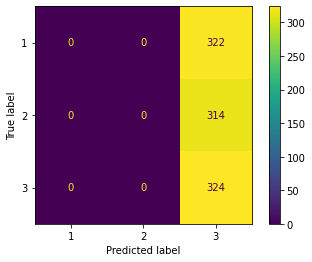


#### results for lowest loss model ####
Accuracy of: 0.3375


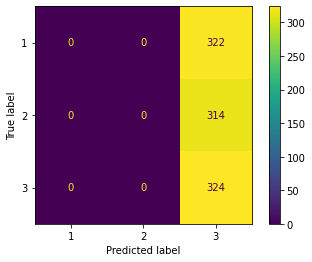


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 1.0 @ epoch 1965
Best training loss (min) 0.0056 @ epoch 2042

Best validation accuracy (max) 0.9149 @ epoch 885
Best validation loss (min) 0.3764 @ epoch 208

#### results for highest accuracy model ####
Accuracy of: 0.3379


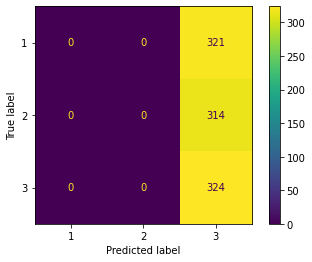


#### results for lowest loss model ####
Accuracy of: 0.3379


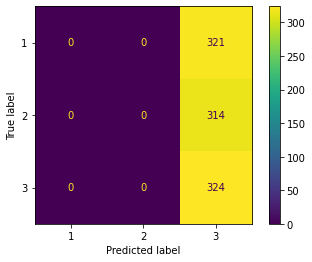


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.9732 @ epoch 2482
Best training loss (min) 0.0852 @ epoch 2382

Best validation accuracy (max) 0.8333 @ epoch 233
Best validation loss (min) 0.4867 @ epoch 302

#### results for highest accuracy model ####
Accuracy of: 0.3351


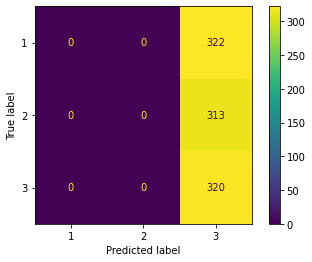


#### results for lowest loss model ####
Accuracy of: 0.3351


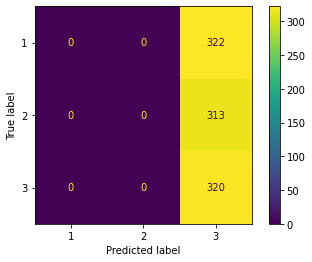

In [8]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/4/samesubject_differentsession_longer_window/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/samesubject_differentsession_longer_window/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/4/samesubject_differentsession_longer_window/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset